# Sepsis scoring system and mortality prediction

This analysis has two main goals (phases as Byron specified in his requirements)

**In the first phase** we are deploying a battery of machine learning algorithm to understand the data generated in the lab. There are several points of interests and questions to answer to, may be the more important ones are :

- Is it possible to predict mortality ? and if yes, can we do it accurately ?
- What are the most important features from the dataset ?
- Is the scoring system objective enough in predicting the outcome

**In the second phase** we focus back on the data to dig for cutoffs. This phase make sense only if we reduce the number of features to the most important ones, AND if the features have a direct effect on the outcome.

In this report, we will go through the details of the methodology as well as the results generated. 

*Details about the fundamental differences between the different algorithms used will not be discussed here, to make this report as intuitive as possible, if there is need for algorithmic explanation I will be happy to provide this*



# Datasets

We had initially two types of datasets in this study, **horizontal** data set, with mice per row and visit per columns, and a **vertical** dataset with each visit/mouse per row.
In order to use machine learning approaches to study these datasets we need data, more data. With this in mind, the usage of the horizontal dataset will be constraining as we will end up with very few instances to work with.
We will be using the vertical dataset to increase the predictive power of our models. We will make an **assumption** that each row is independent, even if it is a different visit for the same mouse. The purpose especially for the first phase is to study the combination of different features on the final outcome, which makes this assumption reasonable. Besides, the dataset contains a lot of **missing records** which forces us to handle these missing data either by removing entirely the rows having missing data as they will not be useful for the model, or do what we call **imputation** replacing these missing values by the average of a particular feature.

> spoiler : I played with the data and realized there is a lot of data to be imputed, which introduces a bias to the final model, thus I removed the rows with one or more missing data, the reduction in size is not dramatic in some cases

# Phase 1 : predicting mortality

## Methodology

The approach we adopted for the analysis of this dataset follows a standard methodology used in machine learning. We first begin by looking at the data, from a descriptive  perspective, then we try to visualize the dataset in order to have a general idea on the trends if any.

In order to apply any machine learning algorithm, we need to transform the data into a format that will minimize the error propagation due to the difference in the way different features were measured and reported. We apply several techniques like rescaling and normalization. This step is necessary to make sure our models are accurate and **generalizable.**

> a model is generalizable when it predicts accurately on a new and unknown dataset

We then need to take a look at our features one by one. We need to know what feature combination impacts the most the performance of our models. To do that, several techniques for feature selection exist, and we will apply some of them to our dataset in order to pick the most important ones to use in our models.

> Feature selection by itself is a research field. CHosing the right feature selection algorithm is very important. There are 3 types classes of feature selection approaches : **filter methods** that consider all features independent and apply statistical tests and methods to assign a scoring to each feature, **wrapper methods** that consider the selection of a set of features as a search problem, and evalustae feature importance based on a model accuracy and finally **embedded methods** that learns feature importance while building the model

We will mainly be doing classification in this analysis, but we might do some regression as well. We will be applying different approaches to our data and measure the accuracy of our models to pick the winning solution.

**It is an optimization analysis** as we study different types of features reduction combined with different classification algorithms to benchmark and pick the most accurate combination. 

The general approach in this notebook is summarized in the figure below:

![approach](/Users/Rad/Documents/Dev/sepsis_predictor_project/notebooks/images/approach.png)  



There are 4 notebooks that are exactely similar with this report, only data and results change. We will be using in this report the first dataset with full data, and no BCG as a template to explain the different steps of the analysis, **a section at the end will summarize all the results we had with all the datasets**

## Analysis Environment 

This analysis was done using open source tools mainly.

- [Python Anaconda](https://www.continuum.io/downloads)
- [Jupyter Notebook](http://jupyter.org/)

I also used [Tableau free edition](http://www.tableau.com/) for some visualizations.

## Understand the data

###  Descriptive Statistics

Let's start first by importing all libraries we need for the analysis, for reading the files, creating plots, performaing machine learning data analysis etc ..

In [1]:
%matplotlib inline
# Load libraries
import numpy as np
from numpy import arange
from numpy import set_printoptions
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv
from pandas import set_option
from pandas.tools.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RandomizedLasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from string import letters
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict
import pprint
from minepy import MINE

from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost

sns.set(style="white")
plt.rcParams['figure.figsize'] = (20.0, 10.0)


/Users/Rad/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/Rad/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Rad/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarn

Now let's create the function to read and load the data

In [2]:
# Load the data set into a dataframe
df = pd.read_csv('../data/excel_updates_danny/cs.mortality.vertical.full.nobcg.leftvright.matrix.csv')


In [3]:
# Print dataset
df.shape

(585, 44)

We have a dataset with 585 instances and 44 features  
Let's take a look at the types of each attribute

In [4]:
# Print data types for attributes

pd.set_option('display.max_rows', 600)
df.dtypes

pupID                                          object
litter                                          int64
sex                                            object
outcome                                        object
challenge.time                                 object
weight.challenge                              float64
weight                                        float64
ch.weight                                     float64
pch.weight                                    float64
time                                           object
hr.post.challenge                             float64
visit                                          object
score.overall                                  object
score.left                                     object
score.right                                    object
rights.mobile.overall                           int64
rights.shakey.overall                           int64
rights.lethargic.overall                        int64
rights.nonmobile.overall    

Let's take a look at the 20 first rows of the dataset

In [5]:
#print first 20 rows
df.head(20)

,pupID,litter,sex,outcome,challenge.time,weight.challenge,weight,ch.weight,pch.weight,time,...,rights.shakey.right,rights.lethargic.right,rights.nonmobile.right,rightss.only.right,fail_to_right.mobile.hips.right,fail_to_right.lethargic.hips.right,fail_to_right.lethargic.two.visits.right,fail_to_right.nonmobile.hips.right,obs.found.dead,observations
0,2015.07.31_F1_M7 (M)_saline_old.0.8,1,M,live,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,2015.07.31_F1_M7 (M)_saline_old.0.8,1,M,live,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,2015.07.31_F1_M7 (M)_saline_old.0.8,1,M,live,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,2015.07.31_F1_M7 (M)_saline_old.0.8,1,M,live,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,2015.07.31_F1_M7 (M)_saline_old.0.8,1,M,live,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
5,2015.07.31_F1_M7 (M)_saline_old.0.8,1,M,live,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
6,2015.07.31_F1_M8 (F)_saline_old.0.8,1,F,live,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
7,2015.07.31_F1_M8 (F)_saline_old.0.8,1,F,live,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
8,2015.07.31_F1_M8 (F)_saline_old.0.8,1,F,live,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
9,2015.07.31_F1_M8 (F)_saline_old.0.8,1,F,live,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


As we can see a lot of data is missing, we will deal with this later in our analysis  
For now let's summarize the distribution of each attribute, not all of this is informative, as some text data is transformed automatically into numerical data, but we are more interested in the distribution of the attributes (features)

In [7]:
pd.set_option('precision', 3)
df.describe()

/Users/Rad/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,litter,weight.challenge,weight,ch.weight,pch.weight,hr.post.challenge,rights.mobile.overall,rights.shakey.overall,rights.lethargic.overall,rights.nonmobile.overall,...,rights.mobile.right,rights.shakey.right,rights.lethargic.right,rights.nonmobile.right,rightss.only.right,fail_to_right.mobile.hips.right,fail_to_right.lethargic.hips.right,fail_to_right.lethargic.two.visits.right,fail_to_right.nonmobile.hips.right,obs.found.dead
count,585.000,553.000,406.000,406.000,406.000,585.000,585.000,585.000,585.000,585.000,...,532.000,532.000,532.000,532.000,532.000,532.000,532.000,532.000,532.000,585.000
mean,11.191,4.302,4.123,-0.053,-0.829,33.096,0.256,0.099,0.229,0.051,...,0.244,0.117,0.250,0.086,0.064,0.107,0.085,0.011,0.060,0.034
std,6.634,0.748,0.690,0.352,8.527,20.112,0.437,0.299,0.421,0.221,...,0.430,0.321,0.433,0.281,0.245,0.310,0.279,0.106,0.238,0.182
min,1.000,2.510,2.430,-1.960,-35.701,12.083,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.000,NaN,NaN,NaN,NaN,18.167,0.000,0.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
50%,12.000,NaN,NaN,NaN,NaN,25.333,0.000,0.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
75%,17.000,NaN,NaN,NaN,NaN,42.417,1.000,0.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
max,25.000,5.930,5.930,0.890,32.271,96.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


The table above is not that informative, there are a lot of missing values, and also categorical attributes that need to be converted

The most important thing we want to see here prior to starting any analysis is how balanced this dataset is, so we will try to take a look at the dsitribution of the outcome, which is the class we want to predict with the score

In [6]:
# class distribution
df.groupby('outcome').size()

outcome
die           160
found.dead     93
live          332
dtype: int64

As we can see the class `live` is higher than the two other, but when we merge `found.dead` with `die` we can have a dataset that is more or less balanced. That said this is a general observation, things can change later when we transform the data.

### Visualization

#### Unimodal Data Visualization

Let's look at how the data looks like before any transformation. It is always useful to lok how different attributes are distributed. 

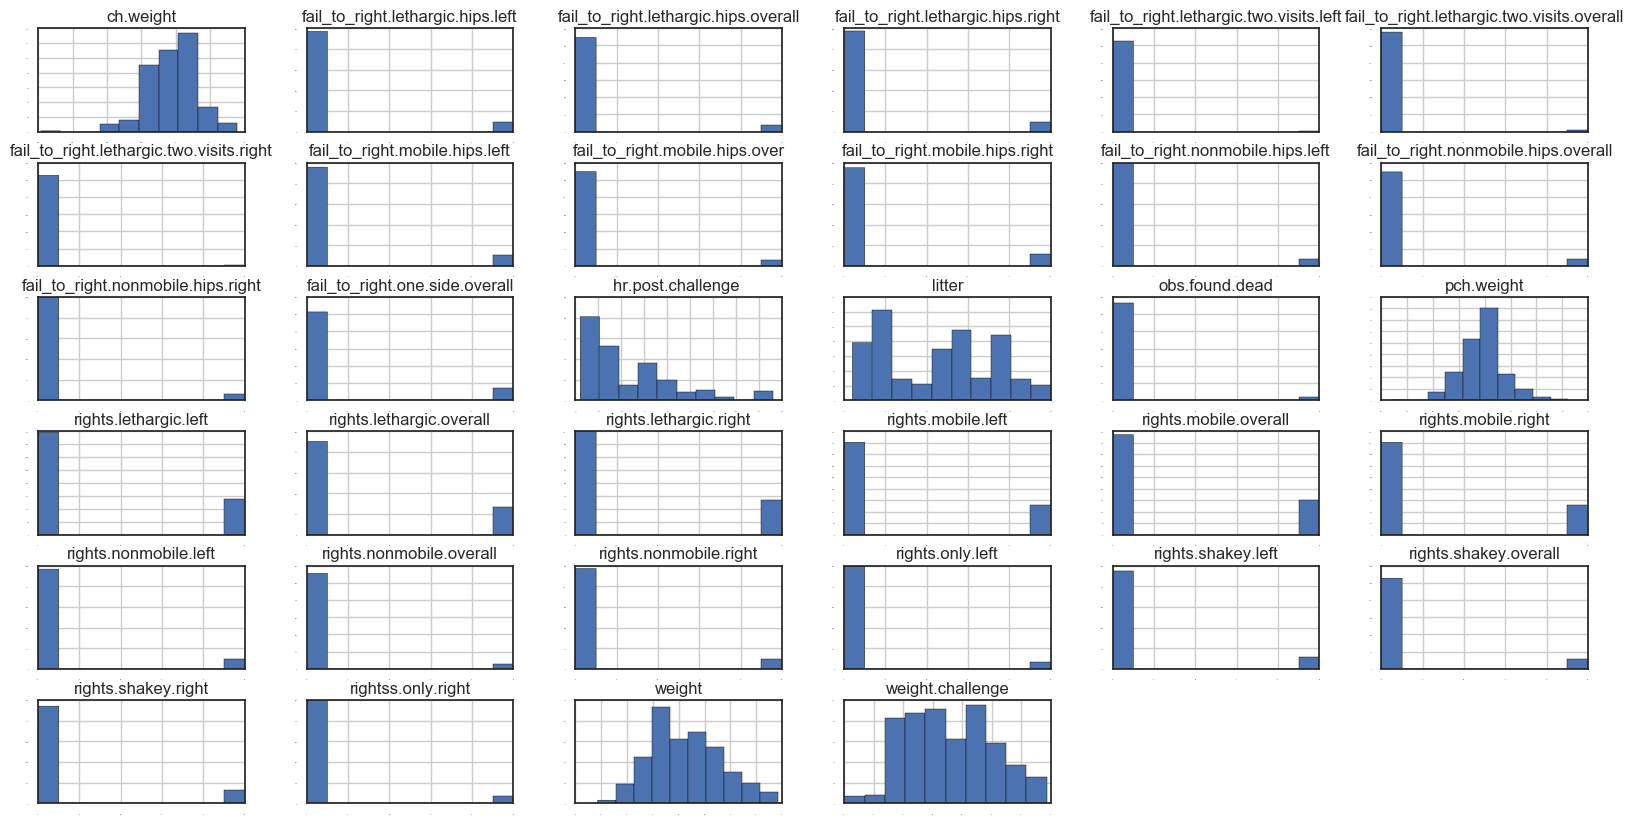

In [8]:
# histograms
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()

Because we have a lot of features that are 0/1 we don't get much out of this plot, except that all features/attributes related to `weight` seem to have a gaussian like distribution

#### Multimodal Data Visualization

Let's see if we have attributes that correlate

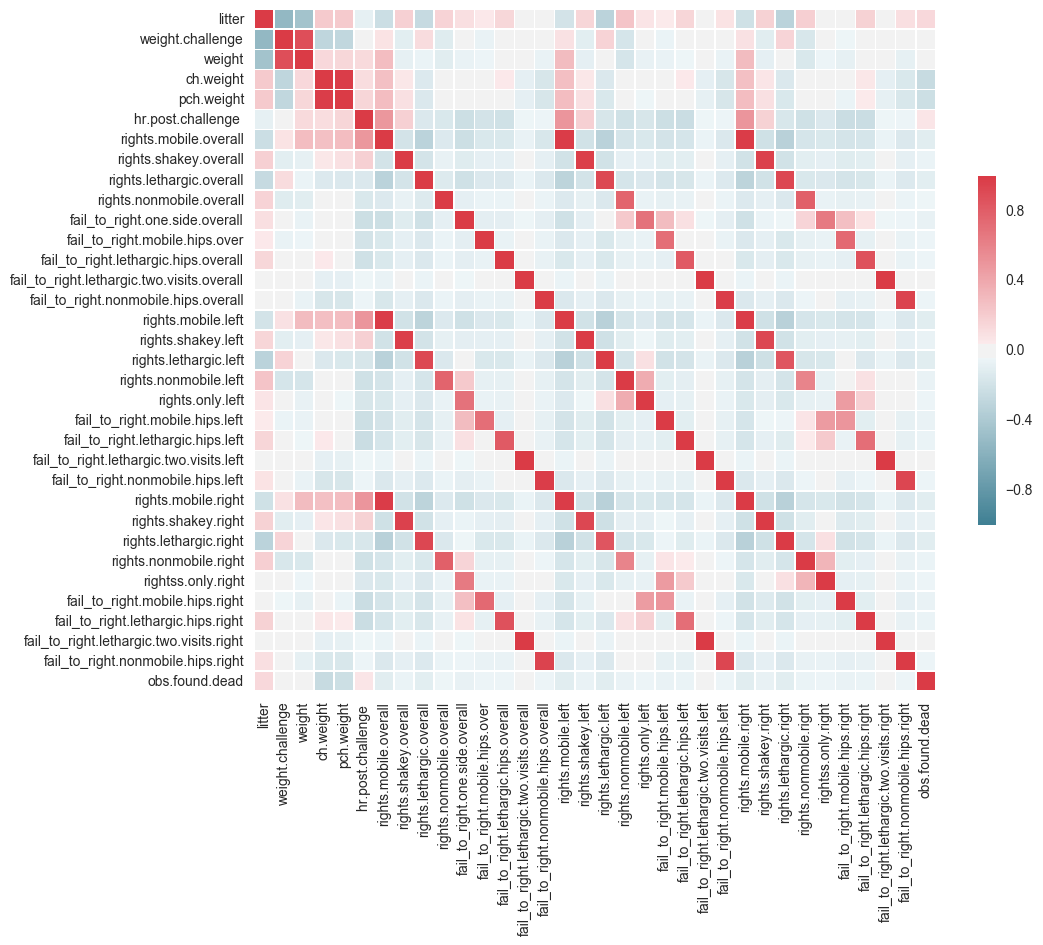

In [9]:
correlations = df.corr(method='pearson')
correlations

# Plot Correlations
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#for tick in ax.get_xticklabels():
#    tick.set_rotation(90)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

As we can see we have a lot of diagonals in this dataset, which means not all these features are going to be included in the dataset when building the final model as we have a lot of correlations

We can already spot some positive correlation between the weight and the hours post challenges even if it is a slightly positive (not a strong correlation judging by the colors). There is also a correlation between the different weights features which makes sense, and also between the scores (left, right, overall)

The top left corner seems to have some useful information

Not all the algorithms deal with correlated features equally. Some algorithms like Naive Bayes assumes attributes independence, so it may behaves in an unexpected way, some other approaches like Support Vector Machines care about it much less.

One thing we can do here, is to take the decision to reduce the number of attributes by doing a **Principal Component Aanalysis**, squeezing features that are part of the same components, transform the original dataset and see what this will give us. This will make the part 2 hard to do, we have a small dataset, we will stick with the feature selection approach.


But first of all we will need to start doing some transformation to make sure we have all the features included, not only the numerical ones, so we will have to do some transformations.

Let's list all the features we have so far.


### Data Transformation

#### Categorical Data Encoding


In [10]:
list(df)

['pupID',
 'litter',
 'sex',
 'outcome',
 'challenge.time',
 'weight.challenge',
 'weight',
 'ch.weight',
 'pch.weight',
 'time',
 'hr.post.challenge ',
 'visit',
 'score.overall',
 'score.left',
 'score.right',
 'rights.mobile.overall',
 'rights.shakey.overall',
 'rights.lethargic.overall',
 'rights.nonmobile.overall',
 'fail_to_right.one.side.overall',
 'fail_to_right.mobile.hips.over',
 'fail_to_right.lethargic.hips.overall',
 'fail_to_right.lethargic.two.visits.overall',
 'fail_to_right.nonmobile.hips.overall',
 'rights.mobile.left',
 'rights.shakey.left',
 'rights.lethargic.left',
 'rights.nonmobile.left',
 'rights.only.left',
 'fail_to_right.mobile.hips.left',
 'fail_to_right.lethargic.hips.left',
 'fail_to_right.lethargic.two.visits.left',
 'fail_to_right.nonmobile.hips.left',
 'rights.mobile.right',
 'rights.shakey.right',
 'rights.lethargic.right',
 'rights.nonmobile.right',
 'rightss.only.right',
 'fail_to_right.mobile.hips.right',
 'fail_to_right.lethargic.hips.right',
 'fai

The features that we need to transform to numerical ones are :
- sex
- outcome

The ones we will drop that are not useful here are 
- pupId
- Litter
- observations

In [11]:
df_clean = df.drop(['litter', 'pupID', 'visit', 'observations'], axis=1)

Let's now merge the **outcome** values corresponding to `die` and `found dead` to make a binary classification instead of having three classes

In [12]:
df_clean.outcome = df_clean.outcome.str.replace("found.dead","die")
df_clean.groupby('outcome').size()

outcome
die     253
live    332
dtype: int64

This is a **balanced** enough dataset.  
Now we need to codify the classes `live` and `die` with `0` and `1`

In [17]:
# Verify code for the outcome
zip(df_clean.outcome, pd.factorize(df_clean.outcome)[0])[15:20]

[('live', 0), ('live', 0), ('live', 0), ('die', 1), ('die', 1)]

In [18]:
transformed_outcome = pd.factorize(df_clean.outcome)
df_clean['outcome'] = transformed_outcome[0].astype(float)

Now we will do the same with `sex` attribute

In [20]:
zip(df_clean.sex, pd.factorize(df_clean.sex)[0])
transformed_sex = pd.factorize(df_clean.sex)
df_clean['sex'] = transformed_sex[0].astype(float)

Now let's remove the time related attributes as we are not doing any time series analysis here

In [21]:
df_clean = df_clean.drop(['challenge.time', 'time'], axis=1)

Three columns remain having `string` values while a number is expected, we will fix that by changing `FD == Found Dead` values into `0`

In [23]:
df_clean['score.left'] = df_clean['score.left'].str.replace("FD","0").astype(float)   
df_clean['score.right'] = df_clean['score.right'].str.replace("FD","0").astype(float)
df_clean['score.overall'] = df_clean['score.overall'].str.replace("FD","0").astype(float)


#### Missing Data Imputation

As explained in the begining of this document, we decided to drop all rows with at least a missing value. I tested the imputation method with the mean value per column but it altered the shape of the format introducing a bias that can be dangerous for the final model

In [24]:
#fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
#imputed_DF = pd.DataFrame(fill_NaN.fit_transform(df_clean))
#imputed_DF.columns = df_clean.columns
#imputed_DF.index = df_clean.index

imputed_DF = df_clean.dropna() 
imputed_DF.columns = df_clean.columns
#imputed_DF.index = df_clean.index

In [25]:
imputed_DF.head()

,sex,outcome,weight.challenge,weight,ch.weight,pch.weight,hr.post.challenge,score.overall,score.left,score.right,...,rights.mobile.right,rights.shakey.right,rights.lethargic.right,rights.nonmobile.right,rightss.only.right,fail_to_right.mobile.hips.right,fail_to_right.lethargic.hips.right,fail_to_right.lethargic.two.visits.right,fail_to_right.nonmobile.hips.right,obs.found.dead
32,0.0,1.0,4.31,3.56,-0.75,-17.401,35.150,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
33,0.0,1.0,4.31,4.05,-0.26,-6.032,26.167,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
35,0.0,1.0,4.31,4.33,-0.02,-0.464,12.333,6.0,6.0,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
38,0.0,1.0,4.80,4.91,-0.11,-2.292,12.333,8.0,6.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
39,0.0,1.0,4.80,4.24,-0.56,-11.667,35.150,0.0,0.0,5.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0


In [26]:
#df_clean_no_nas = df_clean.dropna()
#0df_clean_no_nas.head()
df_clean_2 = imputed_DF

In [27]:
df_clean_2.groupby('outcome').size()

outcome
0.0    228
1.0    164
dtype: int64

The drop of the missing value didnt affect the balance in the dataset with a slightly higher number of mice that lived

Now let's drop the outcome column as we will not be counting it as feature

In [28]:
df_final = df_clean_2.drop(['outcome', 'obs.found.dead'], axis=1)


#### Scaling Data : Normalization

Now we need to compare apples to apples, we have different features with different scales we will reduce all the features to the same one by doing a data normalization

In [31]:
#df_scaled = preprocessing.scale(df_final)
scaler = StandardScaler().fit(df_final)
normalized_df = scaler.transform(df_final)
df_scaled_df = pd.DataFrame(normalized_df, columns = df_final.columns)
df_scaled_df.head()

,sex,weight.challenge,weight,ch.weight,pch.weight,hr.post.challenge,score.overall,score.left,score.right,rights.mobile.overall,...,fail_to_right.nonmobile.hips.left,rights.mobile.right,rights.shakey.right,rights.lethargic.right,rights.nonmobile.right,rightss.only.right,fail_to_right.mobile.hips.right,fail_to_right.lethargic.hips.right,fail_to_right.lethargic.two.visits.right,fail_to_right.nonmobile.hips.right
0,-1.047,0.103,-0.837,-1.959,-1.924,0.104,-1.994,-1.949,-1.956,-0.589,...,3.606,-0.585,-0.395,-0.522,-0.303,-0.261,-0.328,-0.323,-0.125,3.606
1,-1.047,0.103,-0.122,-0.586,-0.610,-0.368,-1.609,-1.573,-1.580,-0.589,...,-0.277,-0.585,-0.395,-0.522,-0.303,-0.261,-0.328,-0.323,8.021,-0.277
2,-1.047,0.103,0.287,0.087,0.034,-1.095,0.315,0.309,0.303,-0.589,...,-0.277,-0.585,-0.395,1.915,-0.303,-0.261,-0.328,-0.323,-0.125,-0.277
3,-1.047,0.771,1.133,-0.165,-0.177,-1.095,1.085,0.309,-0.827,1.697,...,-0.277,-0.585,-0.395,-0.522,-0.303,-0.261,3.052,-0.323,-0.125,-0.277
4,-1.047,0.771,0.155,-1.427,-1.261,0.104,-1.994,-1.949,-0.074,-0.589,...,3.606,-0.585,-0.395,-0.522,3.298,3.831,-0.328,-0.323,-0.125,-0.277


In [32]:
df_scaled_df.describe()

,sex,weight.challenge,weight,ch.weight,pch.weight,hr.post.challenge,score.overall,score.left,score.right,rights.mobile.overall,...,fail_to_right.nonmobile.hips.left,rights.mobile.right,rights.shakey.right,rights.lethargic.right,rights.nonmobile.right,rightss.only.right,fail_to_right.mobile.hips.right,fail_to_right.lethargic.hips.right,fail_to_right.lethargic.two.visits.right,fail_to_right.nonmobile.hips.right
count,3.920e+02,3.920e+02,3.920e+02,3.920e+02,3.920e+02,3.920e+02,3.920e+02,3.920e+02,3.920e+02,3.920e+02,...,3.920e+02,3.920e+02,3.920e+02,3.920e+02,3.920e+02,3.920e+02,3.920e+02,3.920e+02,3.920e+02,3.920e+02
mean,-1.722e-16,1.071e-16,1.163e-15,-6.330e-17,-7.746e-17,-8.836e-17,5.098e-18,1.257e-16,3.863e-16,-5.715e-16,...,-1.881e-16,1.994e-16,2.068e-17,1.069e-15,4.871e-16,-3.512e-17,2.368e-16,1.835e-16,-3.171e-16,1.385e-16
std,1.001e+00,1.001e+00,1.001e+00,1.001e+00,1.001e+00,1.001e+00,1.001e+00,1.001e+00,1.001e+00,1.001e+00,...,1.001e+00,1.001e+00,1.001e+00,1.001e+00,1.001e+00,1.001e+00,1.001e+00,1.001e+00,1.001e+00,1.001e+00
min,-1.047e+00,-2.351e+00,-2.487e+00,-5.350e+00,-4.041e+00,-1.095e+00,-1.994e+00,-1.949e+00,-1.956e+00,-5.891e-01,...,-2.774e-01,-5.852e-01,-3.954e-01,-5.222e-01,-3.032e-01,-2.610e-01,-3.276e-01,-3.228e-01,-1.247e-01,-2.774e-01
25%,-1.047e+00,-6.505e-01,-7.389e-01,-6.418e-01,-6.907e-01,-7.884e-01,-5.508e-01,-8.199e-01,-8.269e-01,-5.891e-01,...,-2.774e-01,-5.852e-01,-3.954e-01,-5.222e-01,-3.032e-01,-2.610e-01,-3.276e-01,-3.228e-01,-1.247e-01,-2.774e-01
50%,9.551e-01,-1.019e-01,-7.839e-02,1.429e-01,8.794e-02,-3.459e-01,3.152e-01,3.091e-01,3.025e-01,-5.891e-01,...,-2.774e-01,-5.852e-01,-3.954e-01,-5.222e-01,-3.032e-01,-2.610e-01,-3.276e-01,-3.228e-01,-1.247e-01,-2.774e-01
75%,9.551e-01,7.705e-01,6.807e-01,5.633e-01,5.121e-01,5.249e-01,1.085e+00,1.062e+00,1.055e+00,1.697e+00,...,-2.774e-01,1.709e+00,-3.954e-01,-5.222e-01,-3.032e-01,-2.610e-01,-3.276e-01,-3.228e-01,-1.247e-01,-2.774e-01
max,9.551e-01,2.311e+00,2.622e+00,2.637e+00,3.820e+00,3.303e+00,1.085e+00,1.062e+00,1.055e+00,1.697e+00,...,3.606e+00,1.709e+00,2.529e+00,1.915e+00,3.298e+00,3.831e+00,3.052e+00,3.098e+00,8.021e+00,3.606e+00


Let's see the effect of this standardization on the correlation between features !

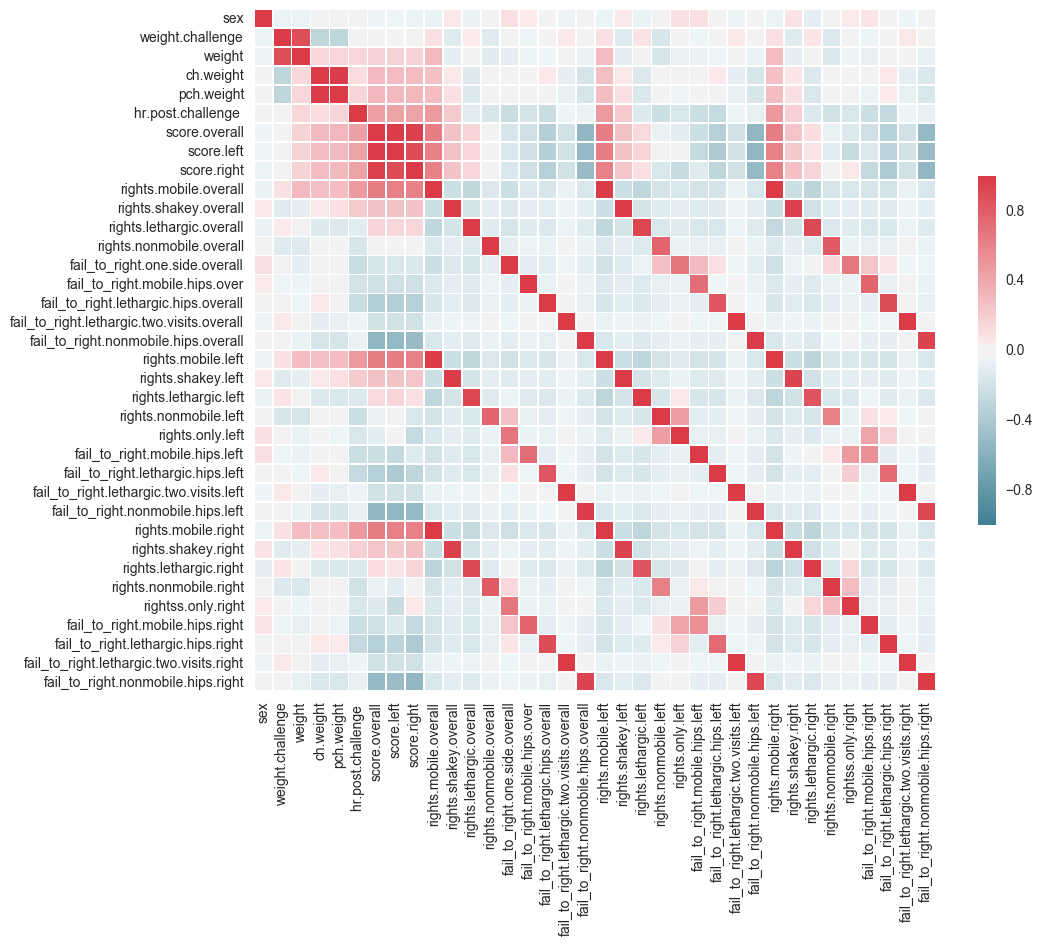

In [33]:
correlations = df_scaled_df.corr(method='pearson')
correlations

# Plot Correlations
corr = df_scaled_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#for tick in ax.get_xticklabels():
#    tick.set_rotation(90)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

**What we see here is the impact of data normalization on the extraction of meaningful information, here correlation, between different features**, after standardizing the data we can clearly see a block on the top left corner of the correlation matrix that already tells something about the features that will impact mostly the outcome.

What we need to do now is proceed for feature selection applying different methods and test this process with different classifiers in order to study the best combination of feature selection and model accuracy (algorithm)

## Predicting outcome WITHOUT feature selection

In [34]:
X = df_scaled_df
Y = df_clean_2["outcome"]
names = df_scaled_df.columns

It is a good idea to use a validation hold-out set. This is a sample of the data that we hold back from our analysis and modeling. We use it right at the end of our project to confirm the accuracy of our final model. It is a smoke test that we can use to see if we messed up and to give us confidence on our estimates of accuracy on unseen data. We will use 80% of the dataset for modeling and hold back 20% for validation.

In [36]:
# Validation dataset

validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,test_size=validation_size, random_state=seed)

### Base Line Models


LR: 0.782661 (0.059212)
LDA: 0.795464 (0.069392)
KNN: 0.760685 (0.088701)
CART: 0.776310 (0.051248)


/Users/Rad/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


NB: 0.734879 (0.057135)
SVM: 0.773085 (0.054942)


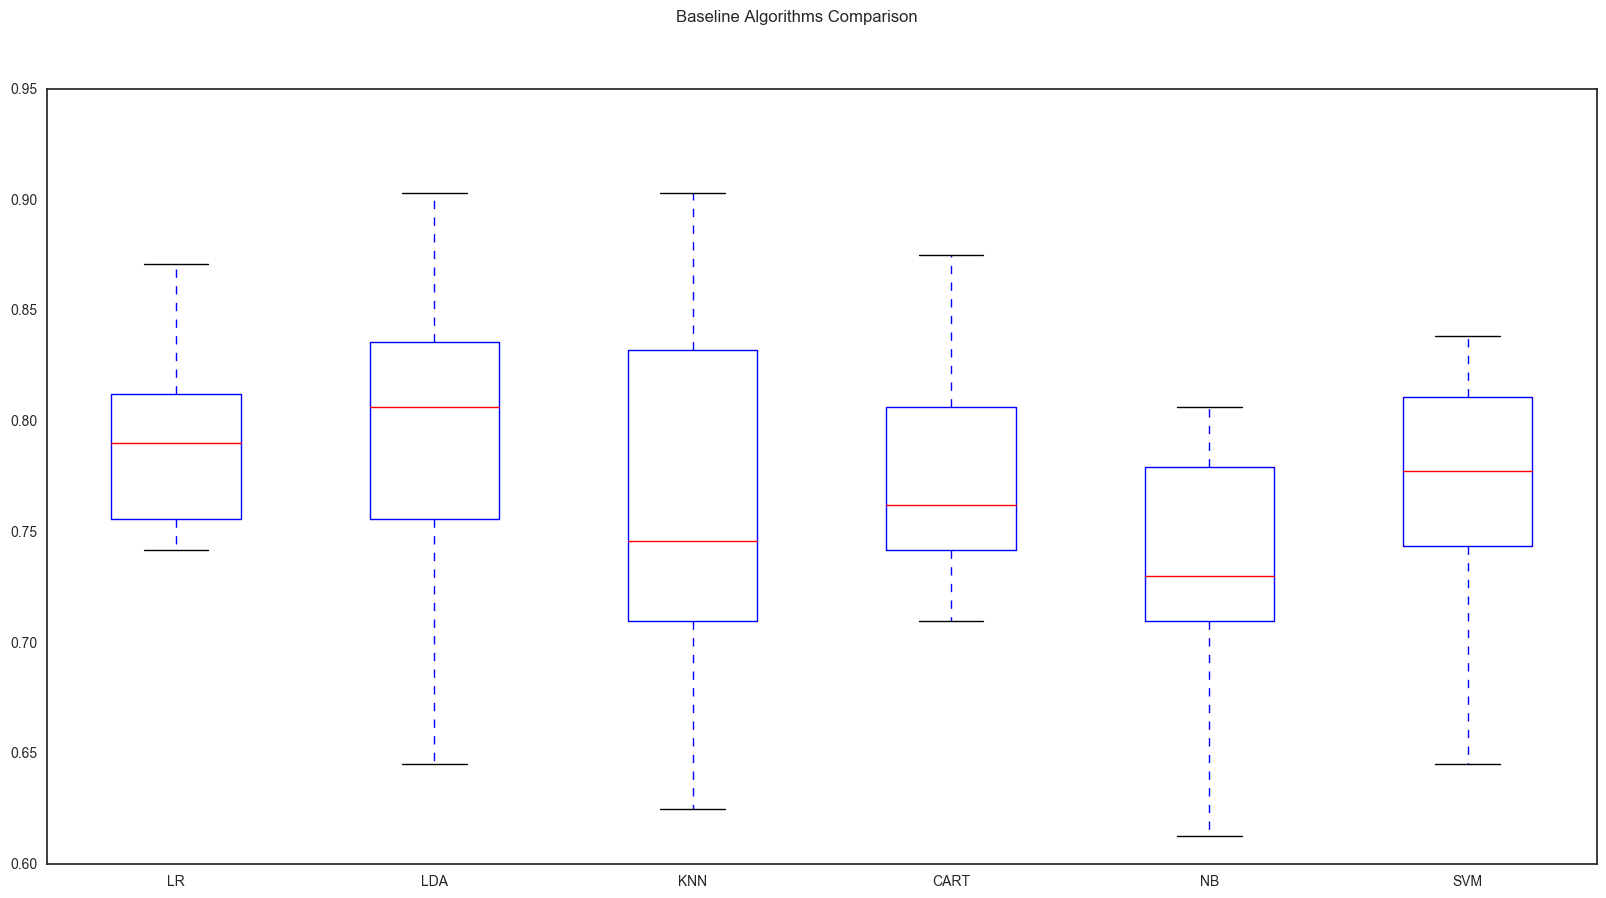

In [37]:
def base_line_models(training_set, outcome):
    # Test options and evaluation metric
    num_folds = 10
    num_instances = len(training_set)
    seed = 7
    scoring = 'accuracy'

    # Spot-Check Algorithms
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))
    results = []
    names = []
    for name, model in models:
        kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        cv_results = cross_validation.cross_val_score(model, training_set, outcome, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Baseline Algorithms Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

base_line_models(X_train, Y_train)

### Ensemble Models


AB: 0.872077 (0.032209)
GBM: 0.872177 (0.062808)
RF: 0.804940 (0.061960)
ET: 0.811391 (0.072972)
XGB: 0.868851 (0.072187)


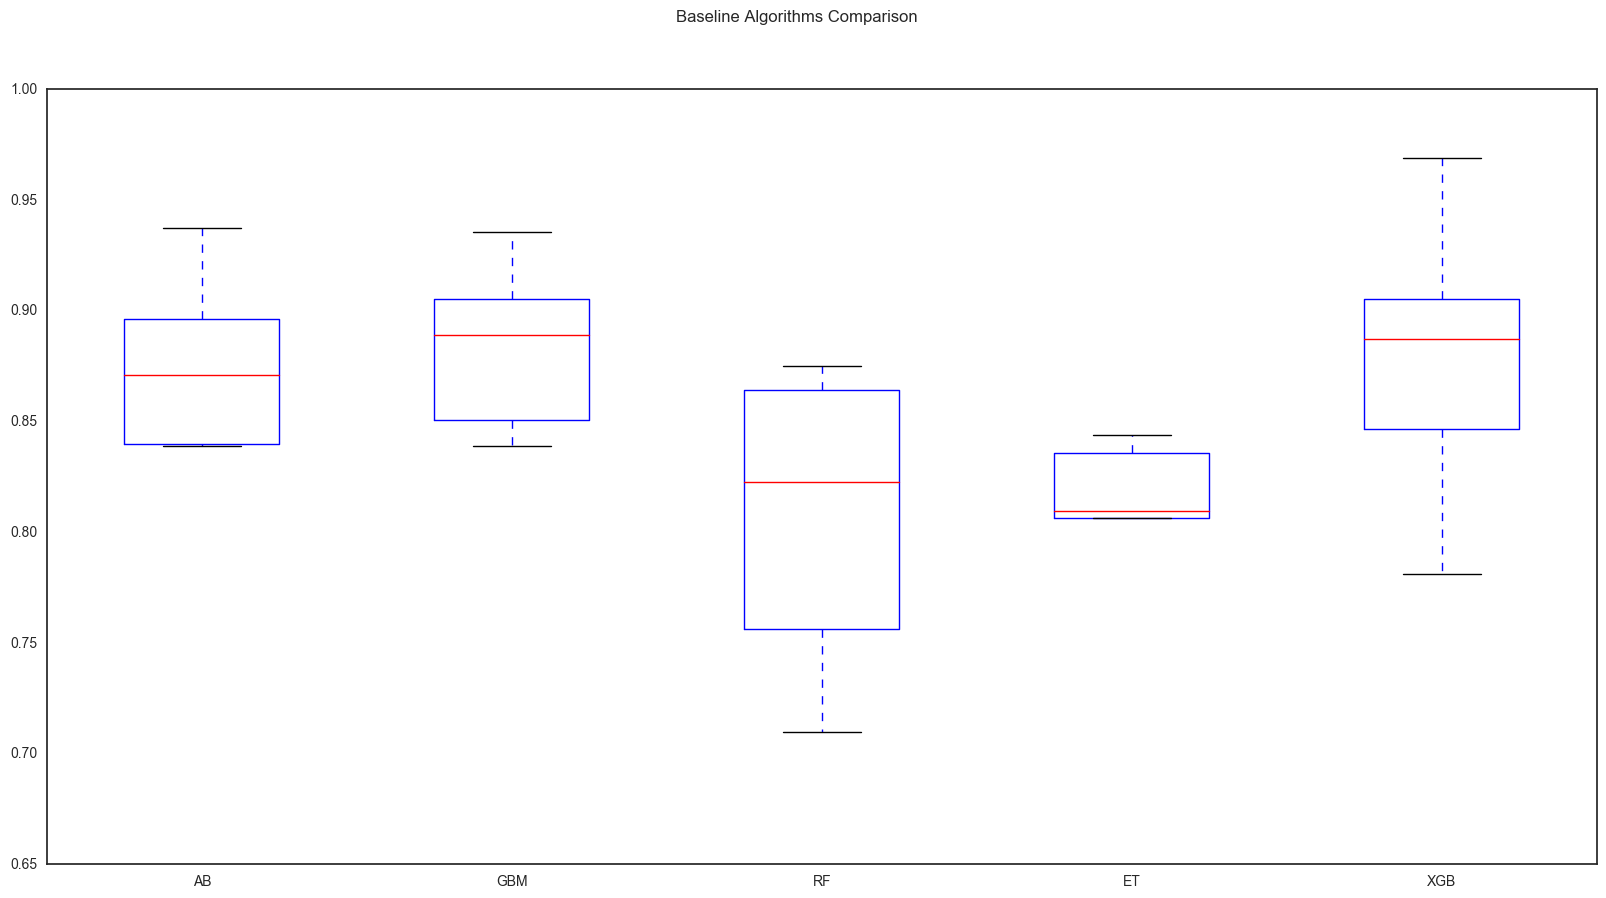

In [38]:
def ensemble_models(training_set, outcome):
    # Test options and evaluation metric
    num_folds = 10
    num_instances = len(training_set)
    seed = 7
    scoring = 'accuracy'

    # ensembles
    ensembles = []
    ensembles.append(('AB', AdaBoostClassifier()))
    ensembles.append(('GBM', GradientBoostingClassifier()))
    ensembles.append(('RF', RandomForestClassifier()))
    ensembles.append(('ET', ExtraTreesClassifier()))
    ensembles.append(('XGB', xgboost.XGBClassifier()))
    results = []
    names = []
    for name, model in ensembles:
        kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        cv_results = cross_validation.cross_val_score(model, training_set, outcome, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Baseline Algorithms Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

ensemble_models(X_train, Y_train)

### Model Validations

Validation based on LR
0.79746835443
[[40 10]
 [ 6 23]]
[[40 10]
 [ 6 23]]
             precision    recall  f1-score   support

        0.0       0.87      0.80      0.83        50
        1.0       0.70      0.79      0.74        29

avg / total       0.81      0.80      0.80        79



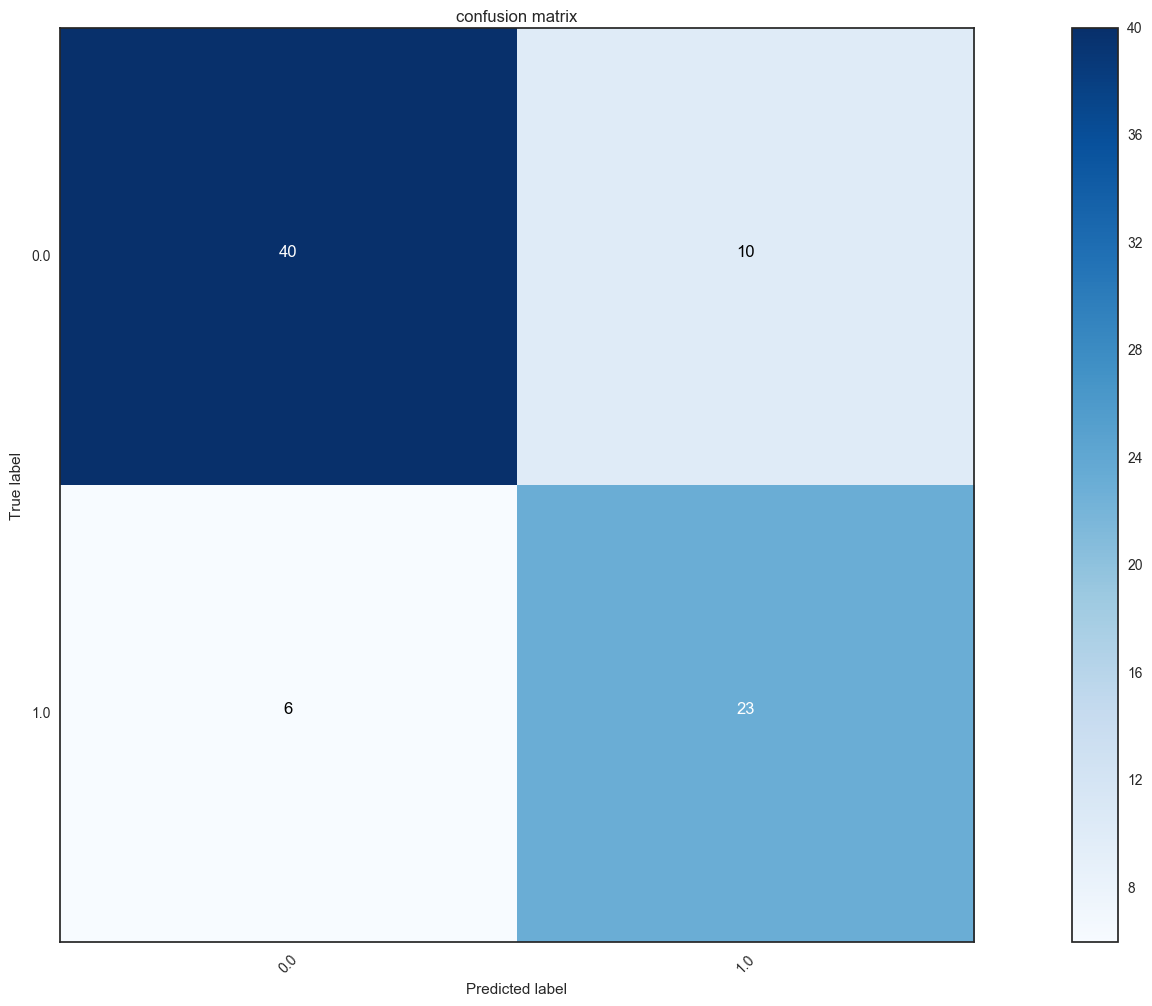

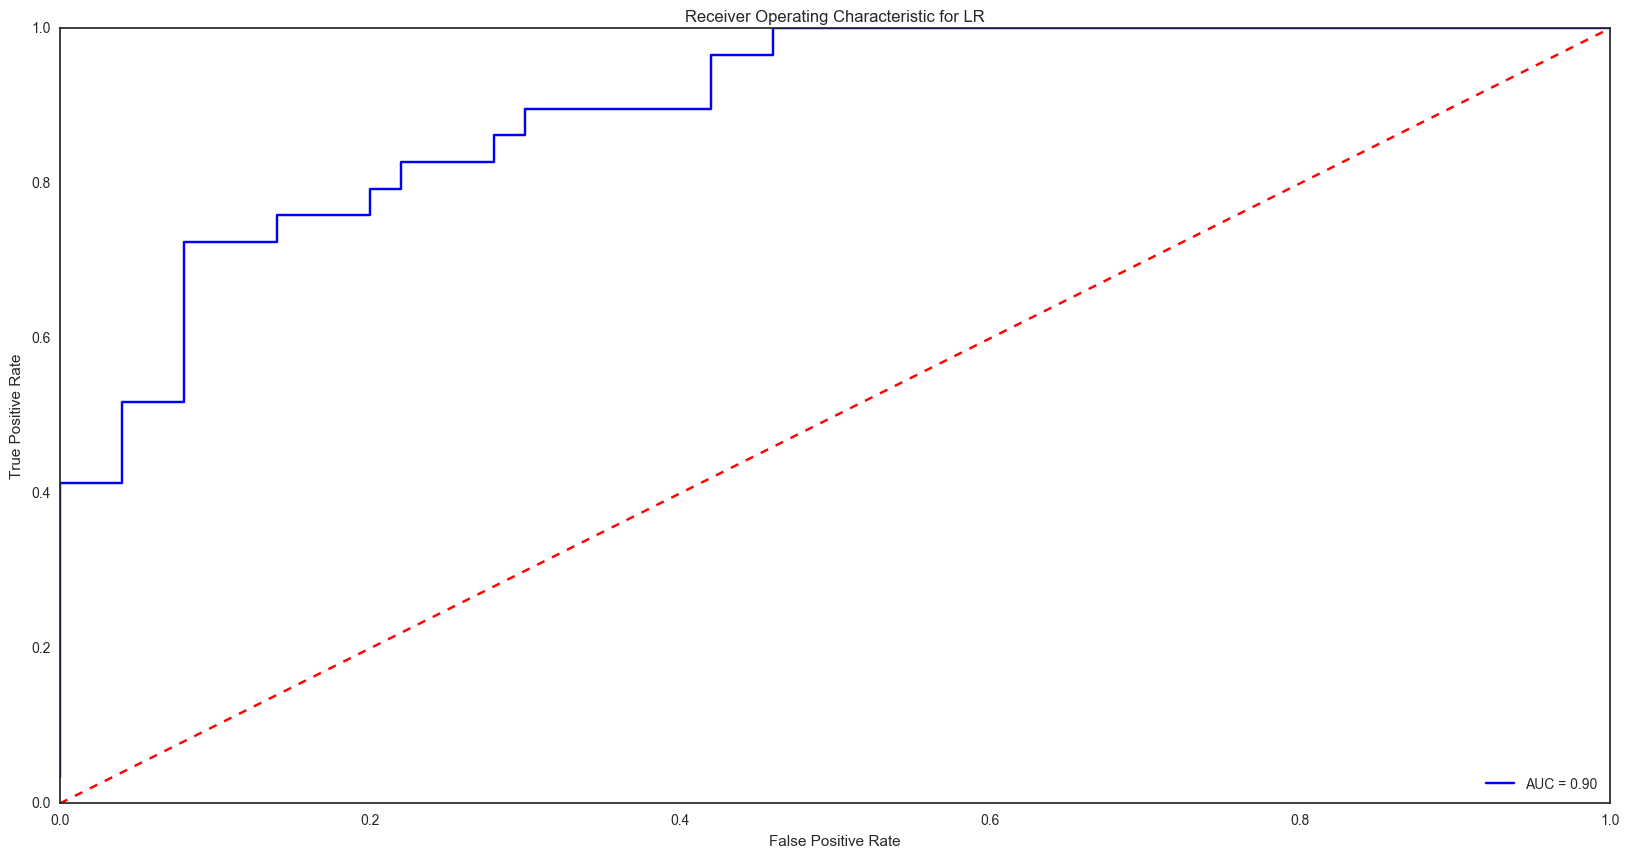

Validation based on LDA
0.784810126582
[[39 11]
 [ 6 23]]
[[39 11]
 [ 6 23]]
             precision    recall  f1-score   support

        0.0       0.87      0.78      0.82        50
        1.0       0.68      0.79      0.73        29

avg / total       0.80      0.78      0.79        79



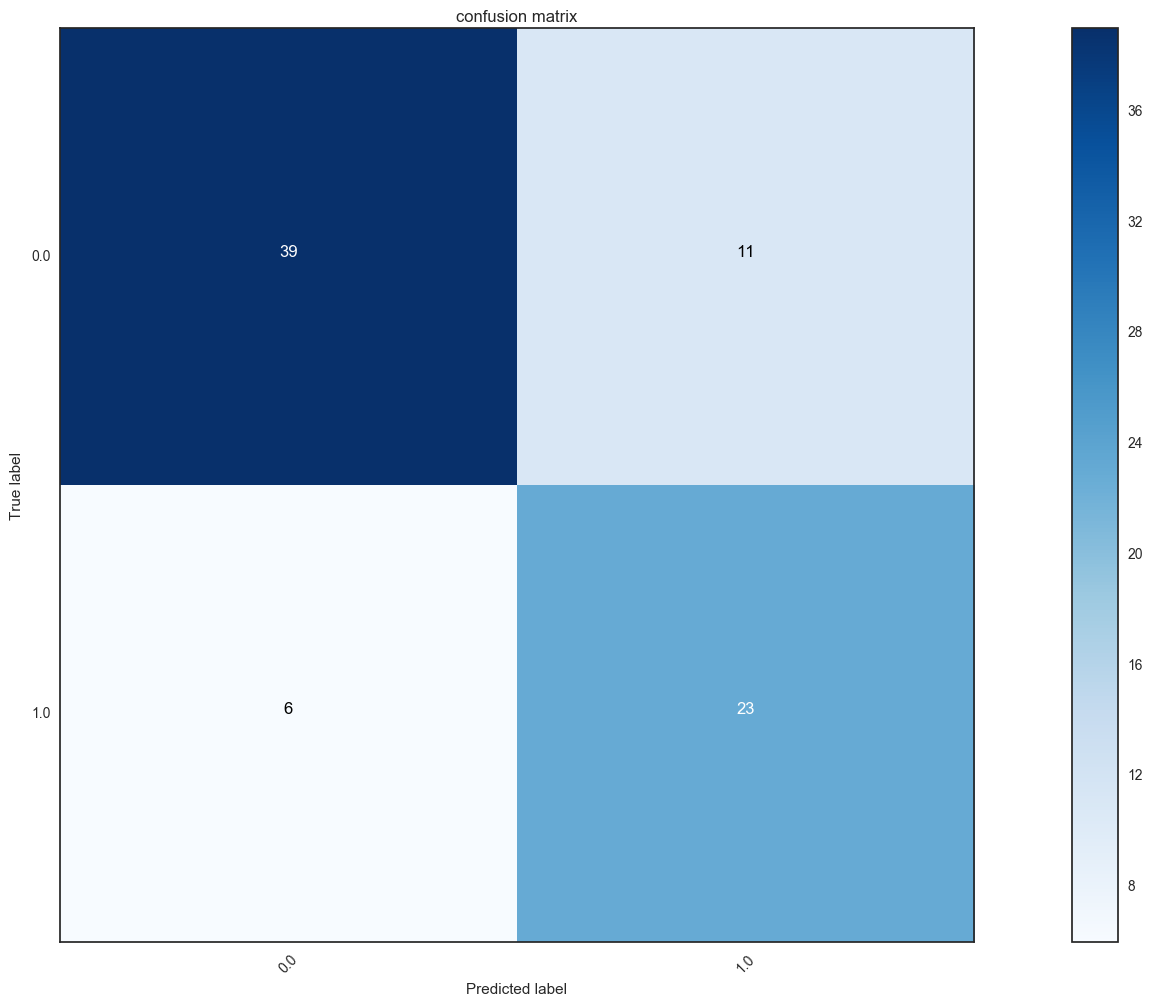

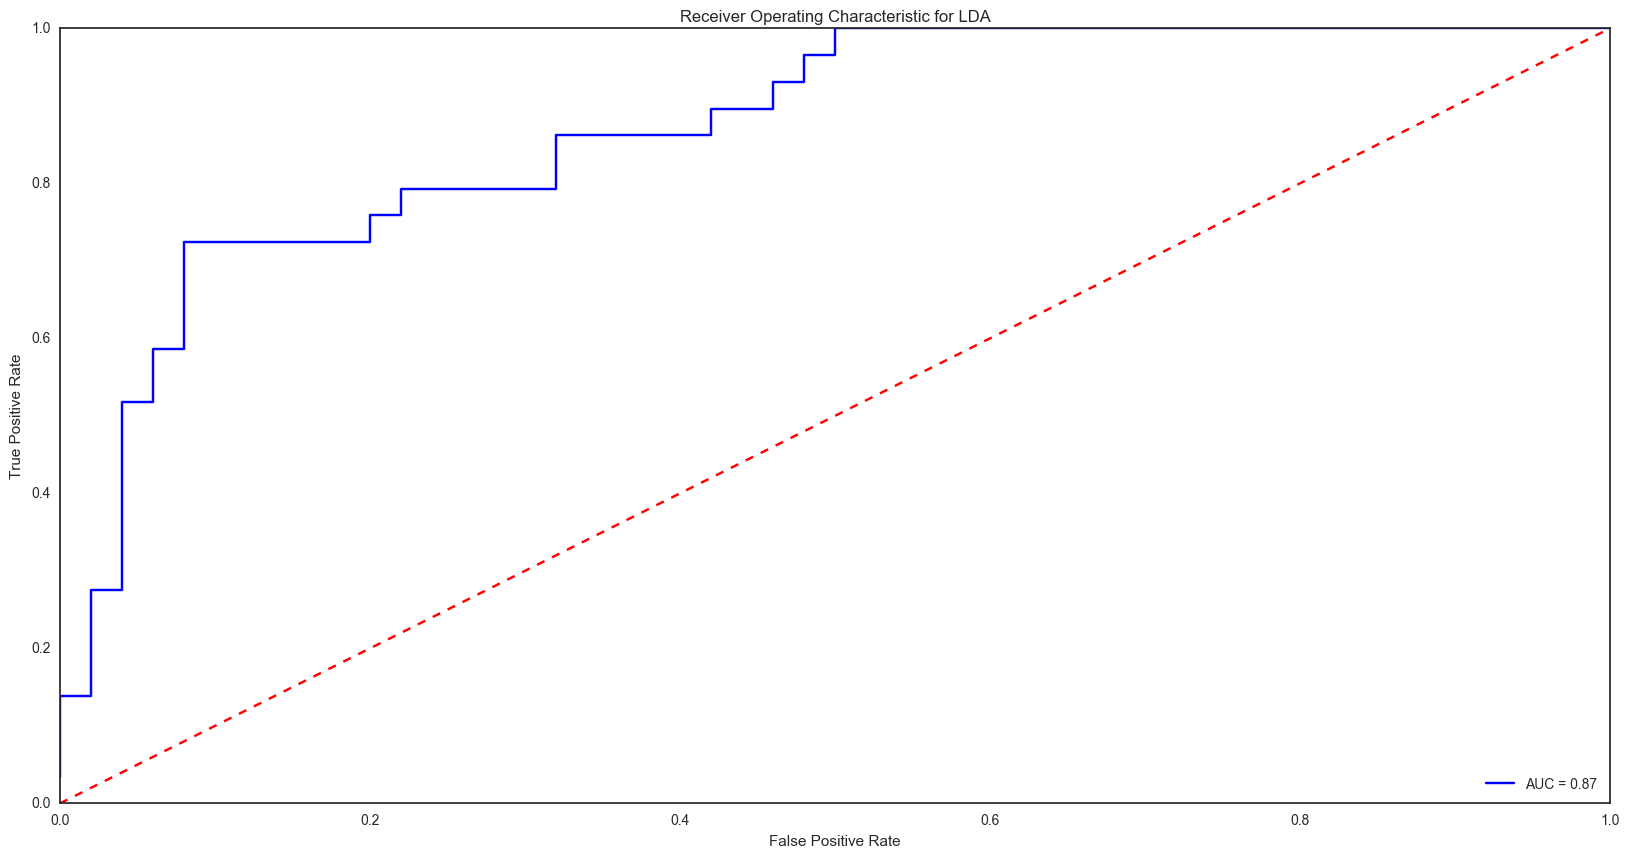

Validation based on KNN
0.79746835443
[[38 12]
 [ 4 25]]
[[38 12]
 [ 4 25]]
             precision    recall  f1-score   support

        0.0       0.90      0.76      0.83        50
        1.0       0.68      0.86      0.76        29

avg / total       0.82      0.80      0.80        79



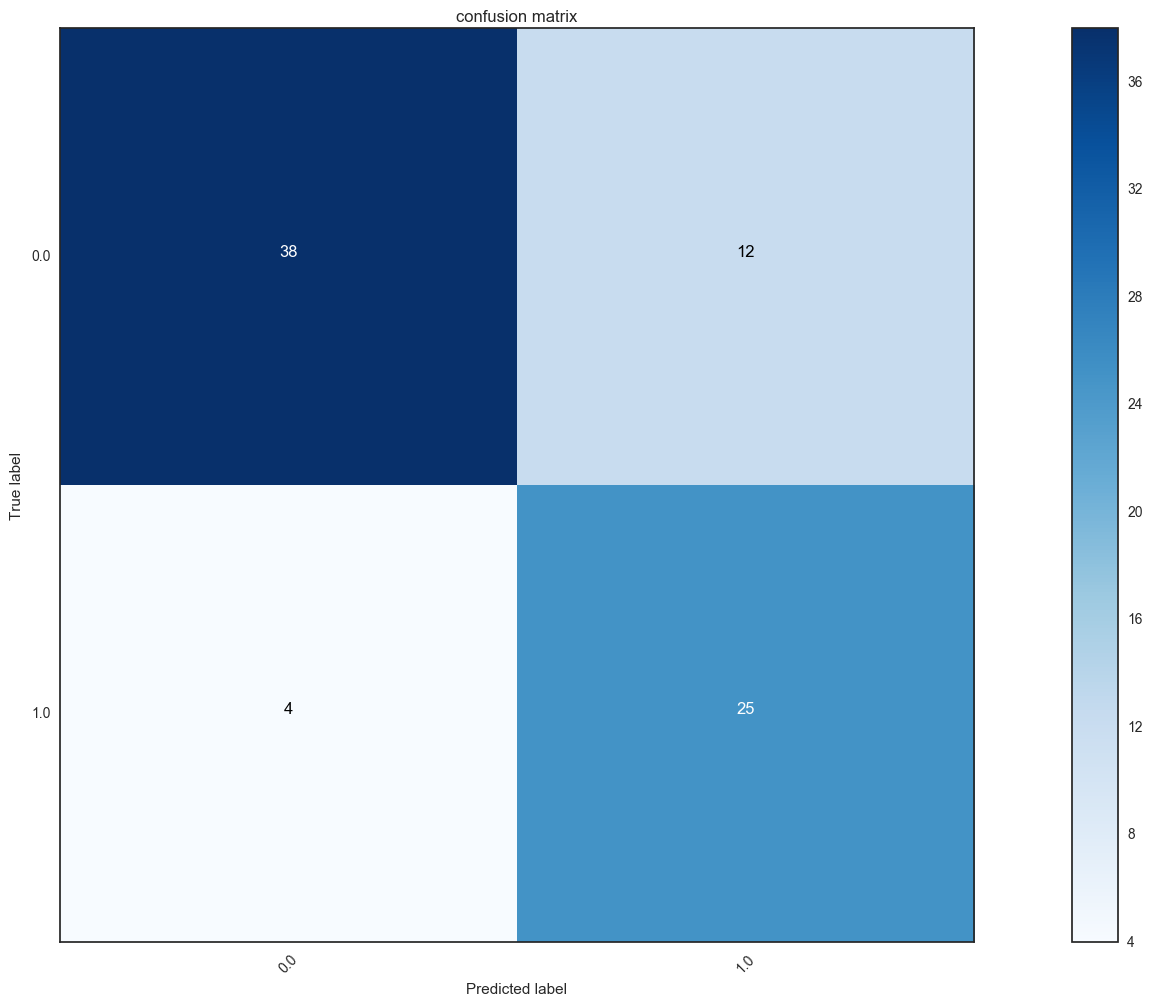

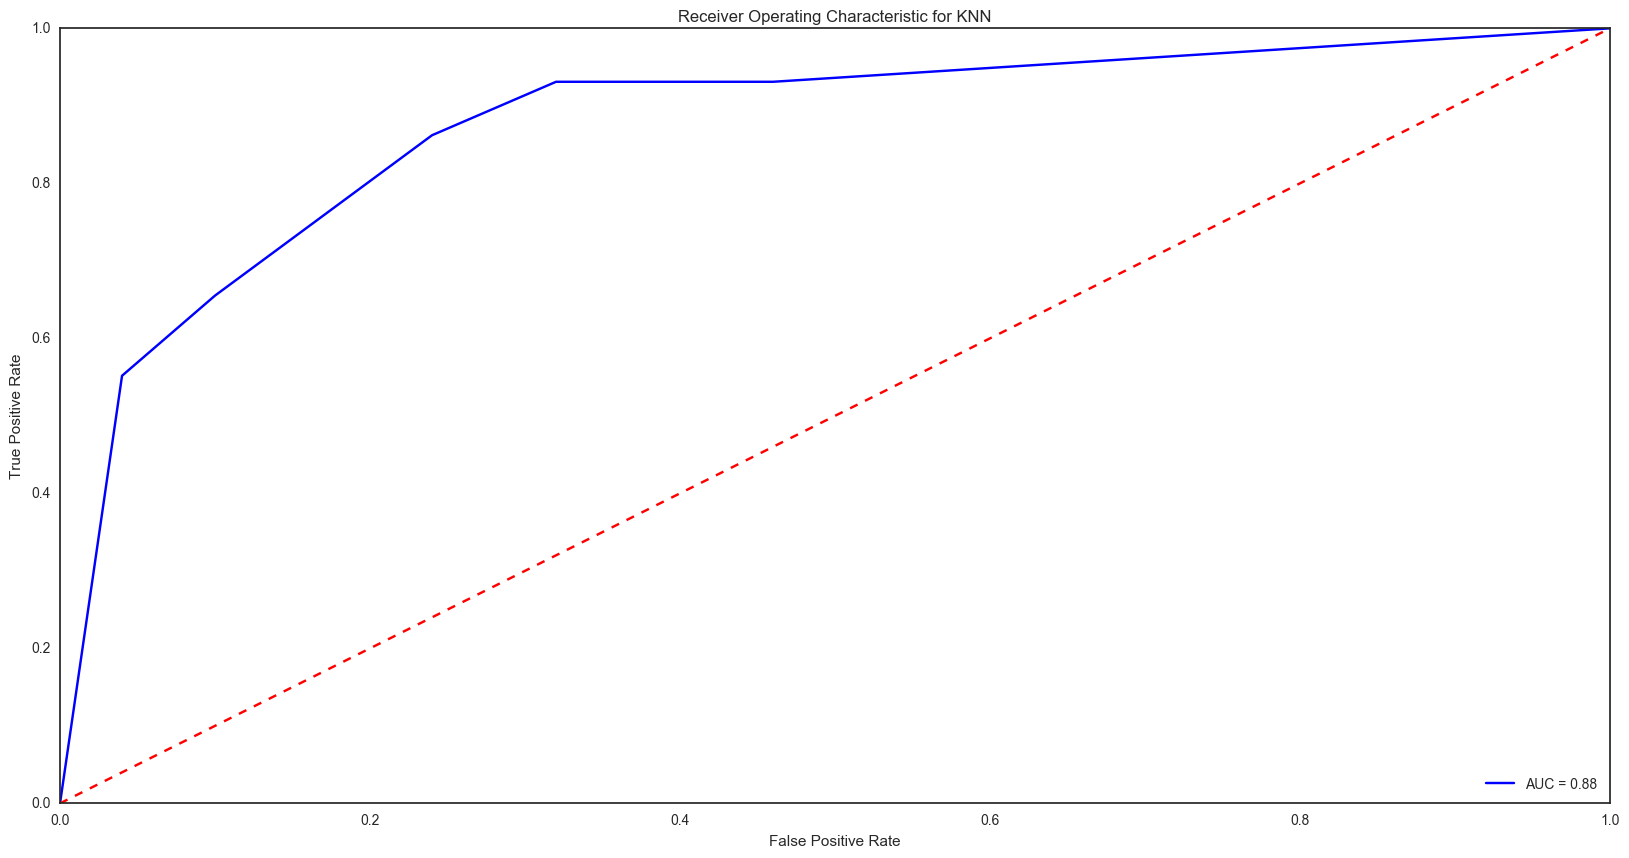

Validation based on CART
0.810126582278
[[41  9]
 [ 6 23]]
[[41  9]
 [ 6 23]]
             precision    recall  f1-score   support

        0.0       0.87      0.82      0.85        50
        1.0       0.72      0.79      0.75        29

avg / total       0.82      0.81      0.81        79



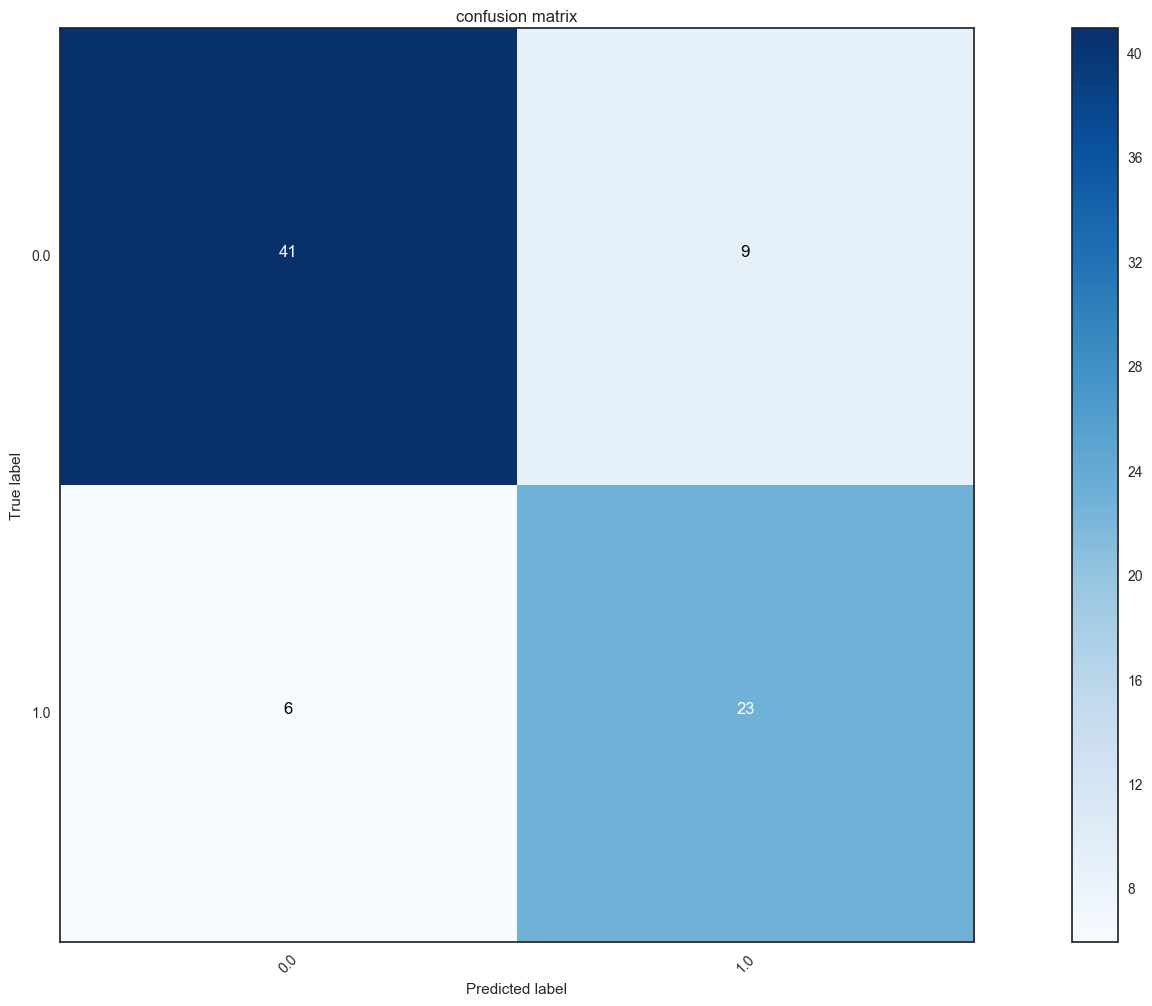

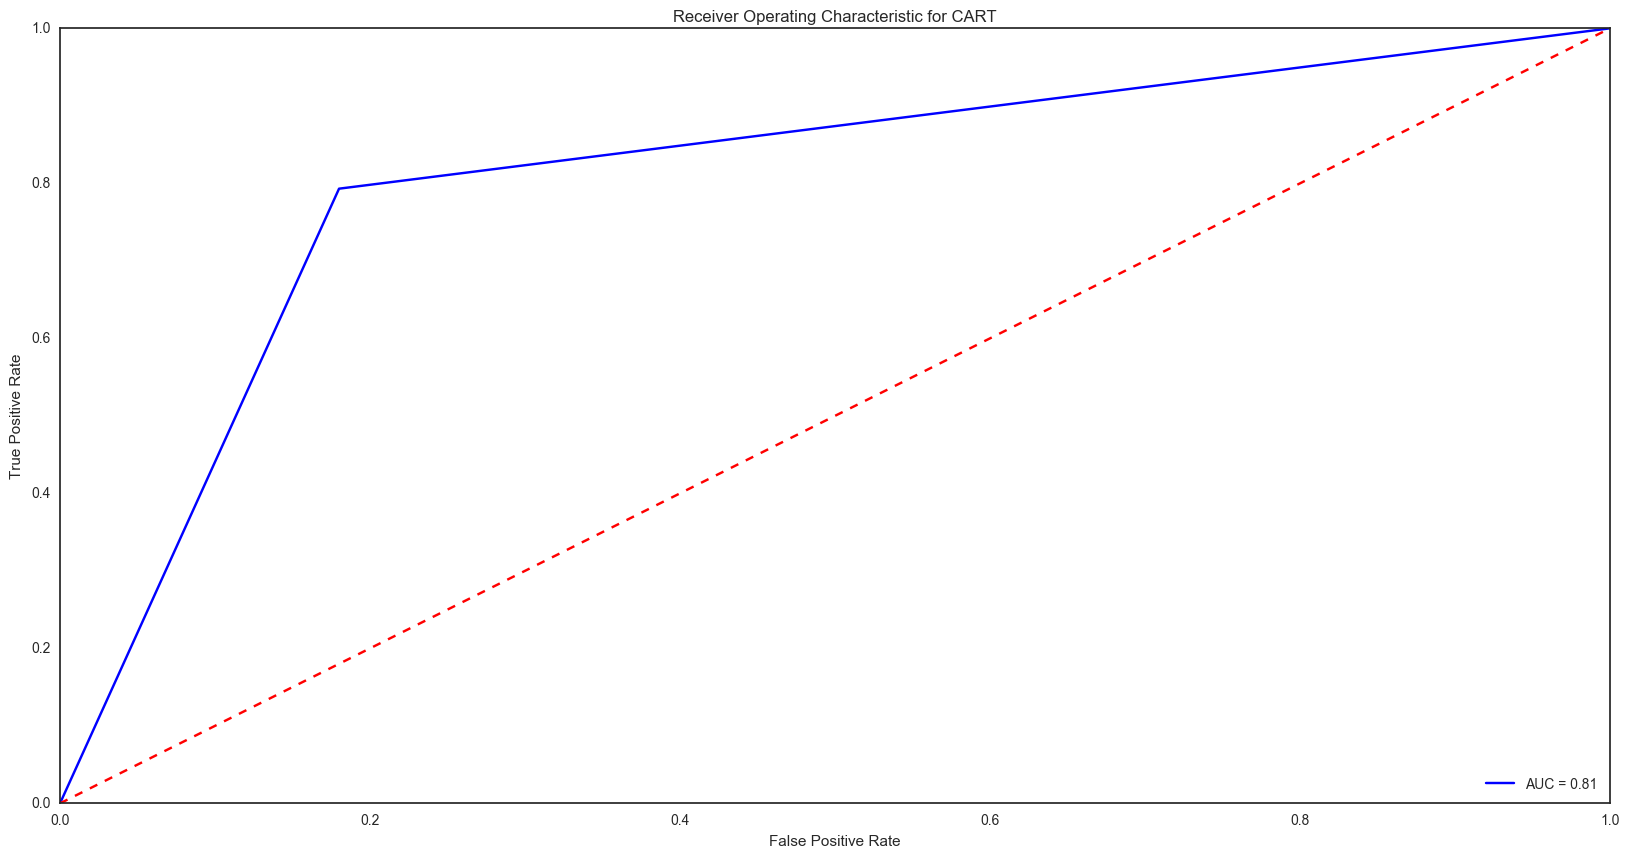

Validation based on NB
0.79746835443
[[49  1]
 [15 14]]
[[49  1]
 [15 14]]
             precision    recall  f1-score   support

        0.0       0.77      0.98      0.86        50
        1.0       0.93      0.48      0.64        29

avg / total       0.83      0.80      0.78        79



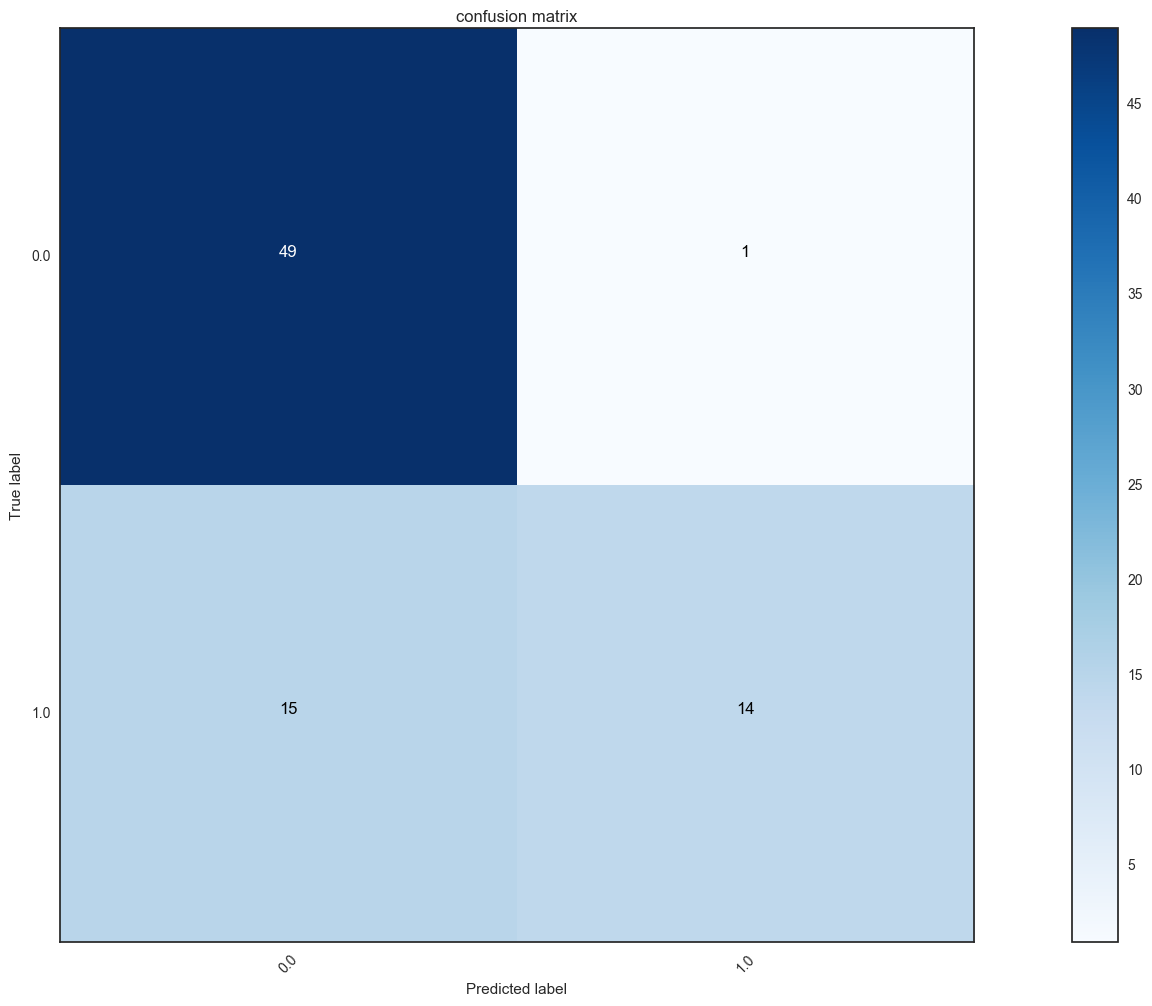

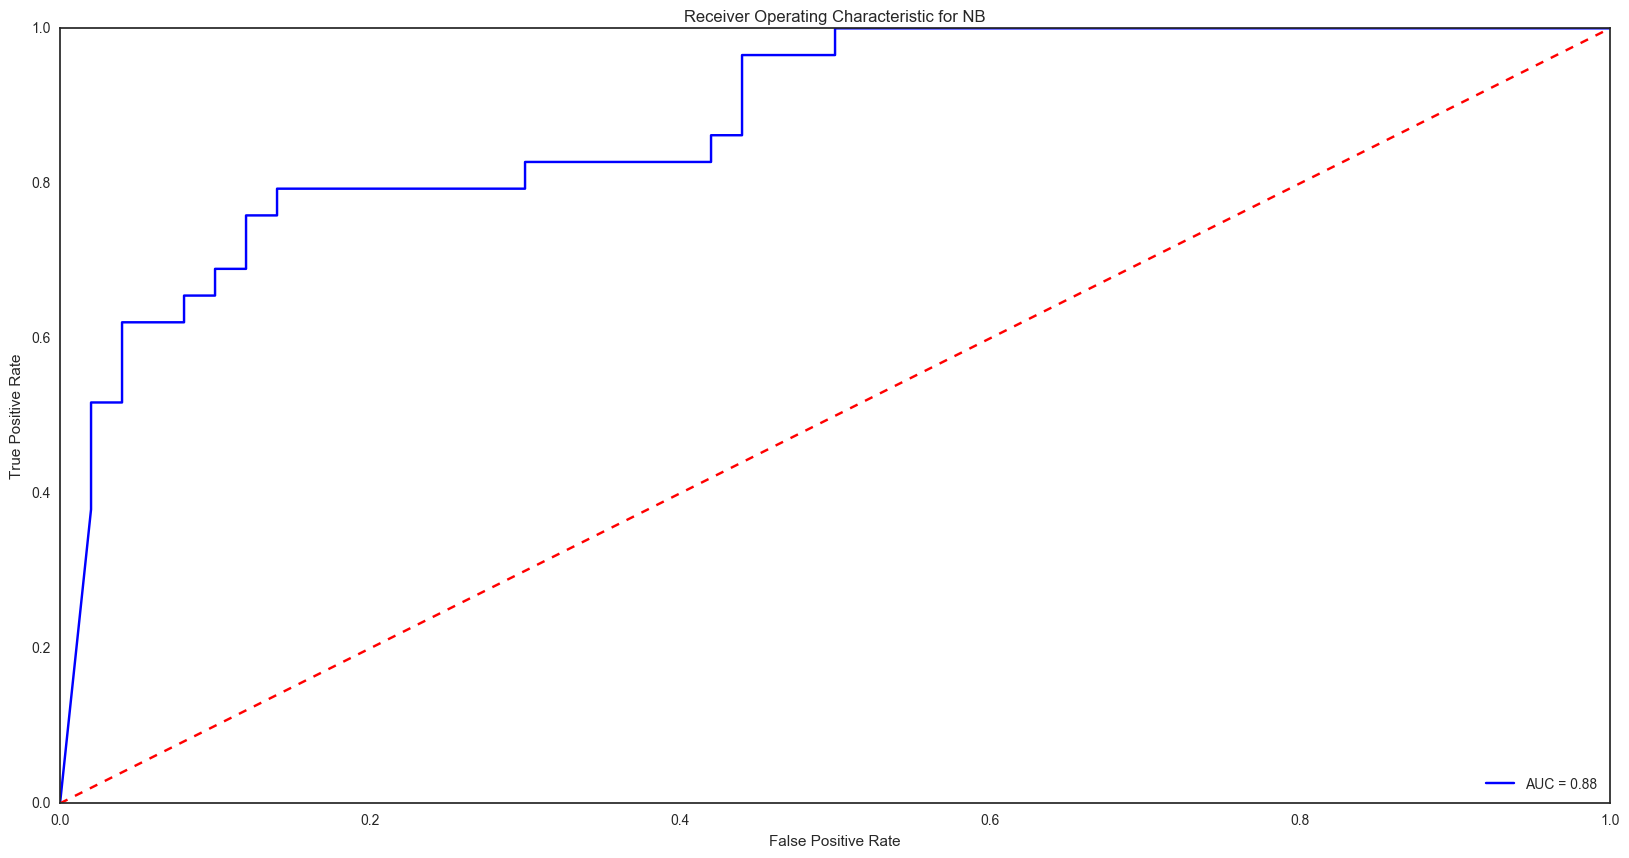

Validation based on SVM
0.79746835443
[[40 10]
 [ 6 23]]
[[40 10]
 [ 6 23]]
             precision    recall  f1-score   support

        0.0       0.87      0.80      0.83        50
        1.0       0.70      0.79      0.74        29

avg / total       0.81      0.80      0.80        79



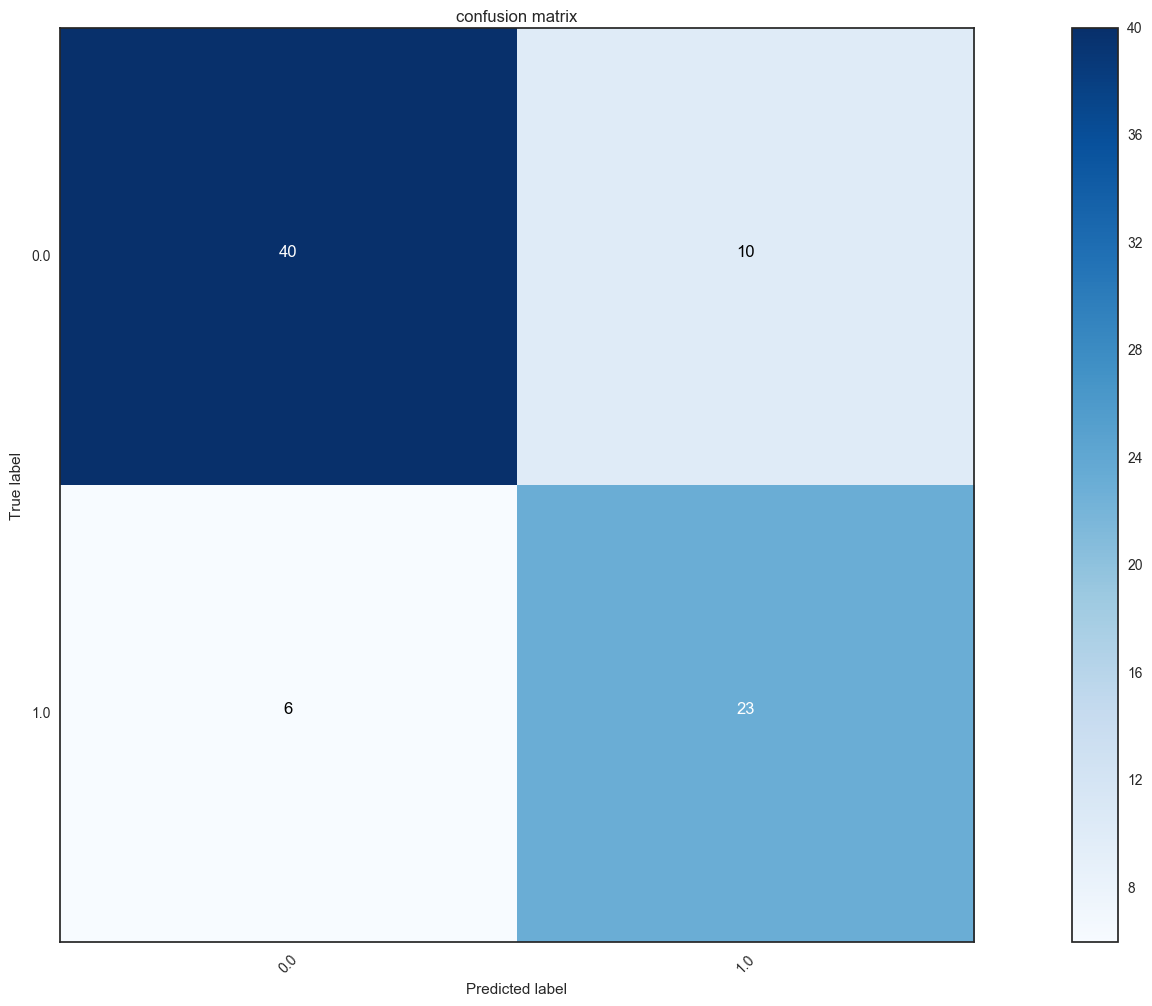

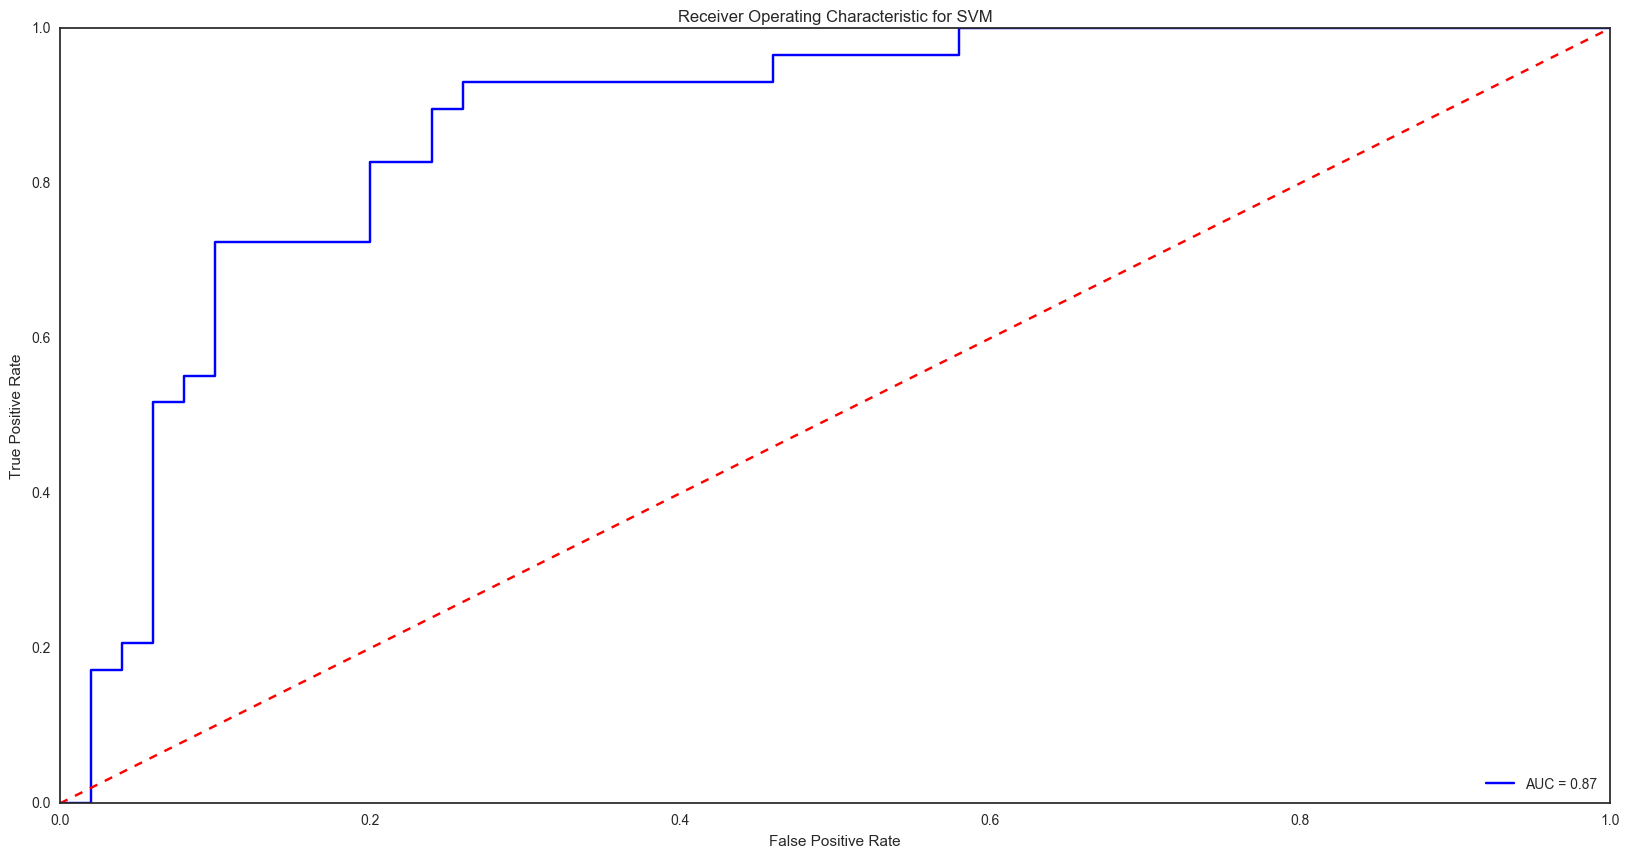

Validation based on AB
0.822784810127
[[41  9]
 [ 5 24]]
[[41  9]
 [ 5 24]]
             precision    recall  f1-score   support

        0.0       0.89      0.82      0.85        50
        1.0       0.73      0.83      0.77        29

avg / total       0.83      0.82      0.82        79



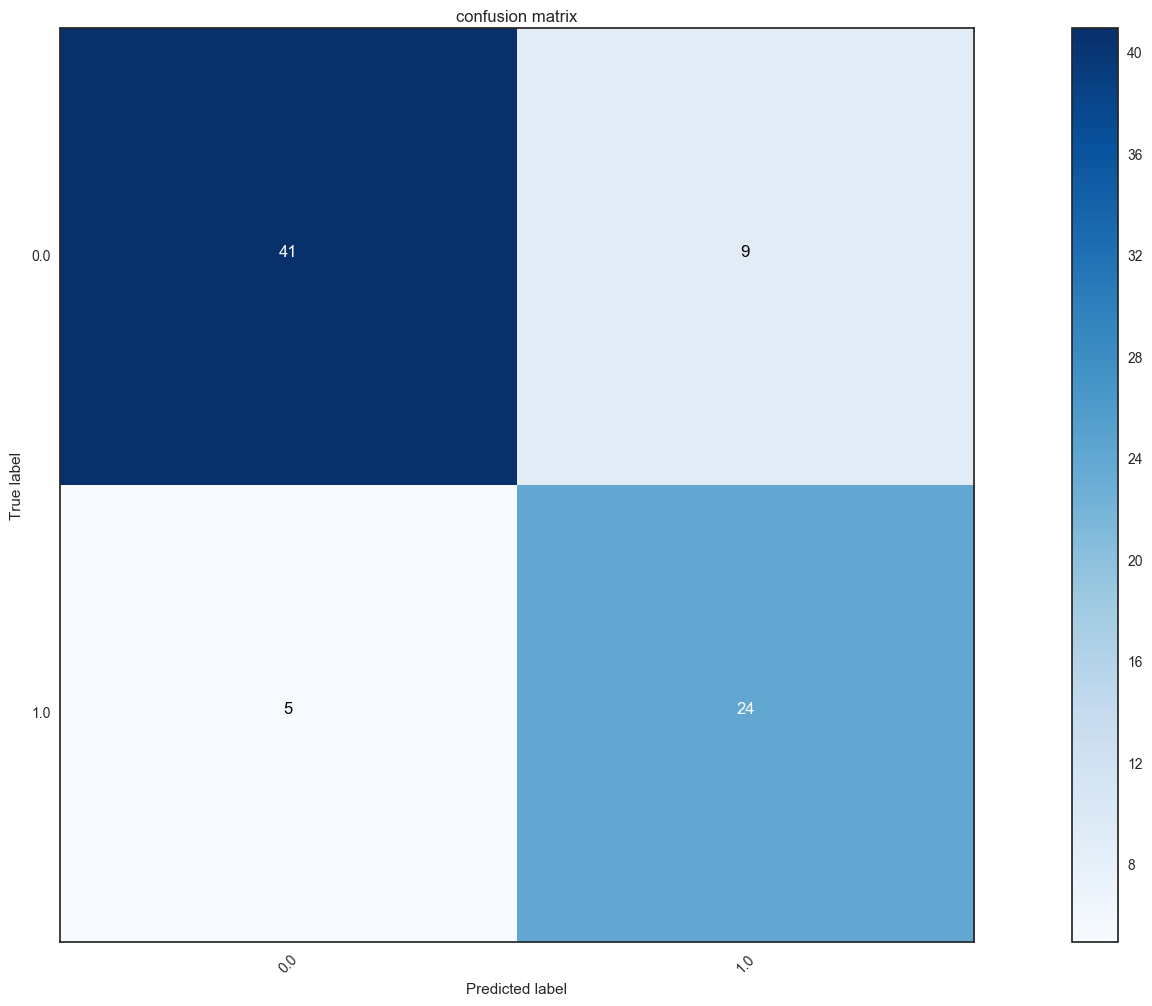

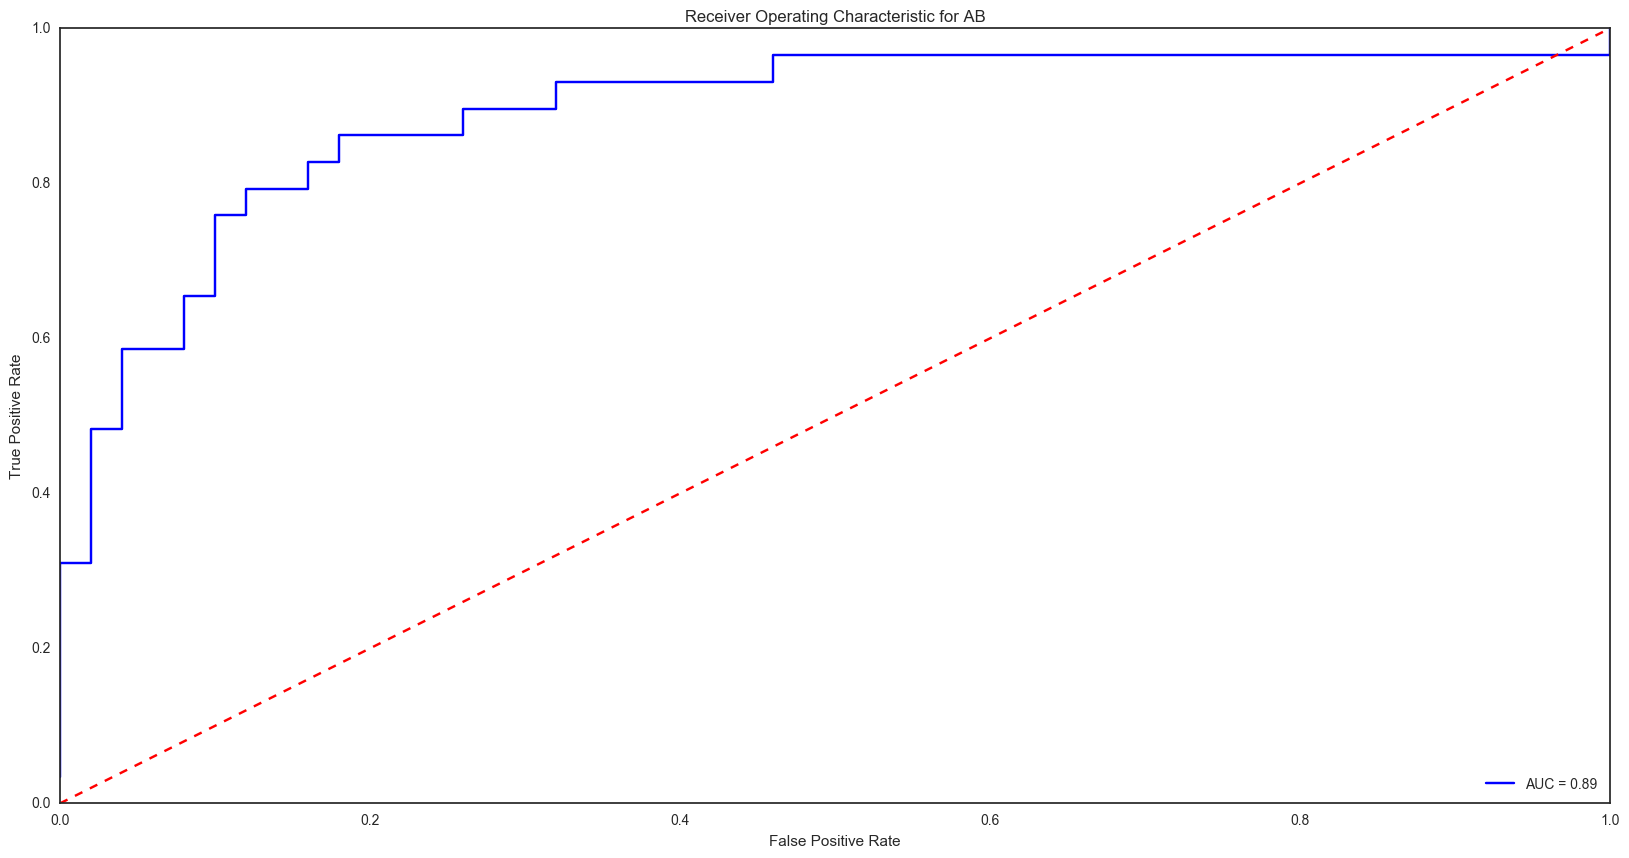

Validation based on GBM
0.835443037975
[[41  9]
 [ 4 25]]
[[41  9]
 [ 4 25]]
             precision    recall  f1-score   support

        0.0       0.91      0.82      0.86        50
        1.0       0.74      0.86      0.79        29

avg / total       0.85      0.84      0.84        79



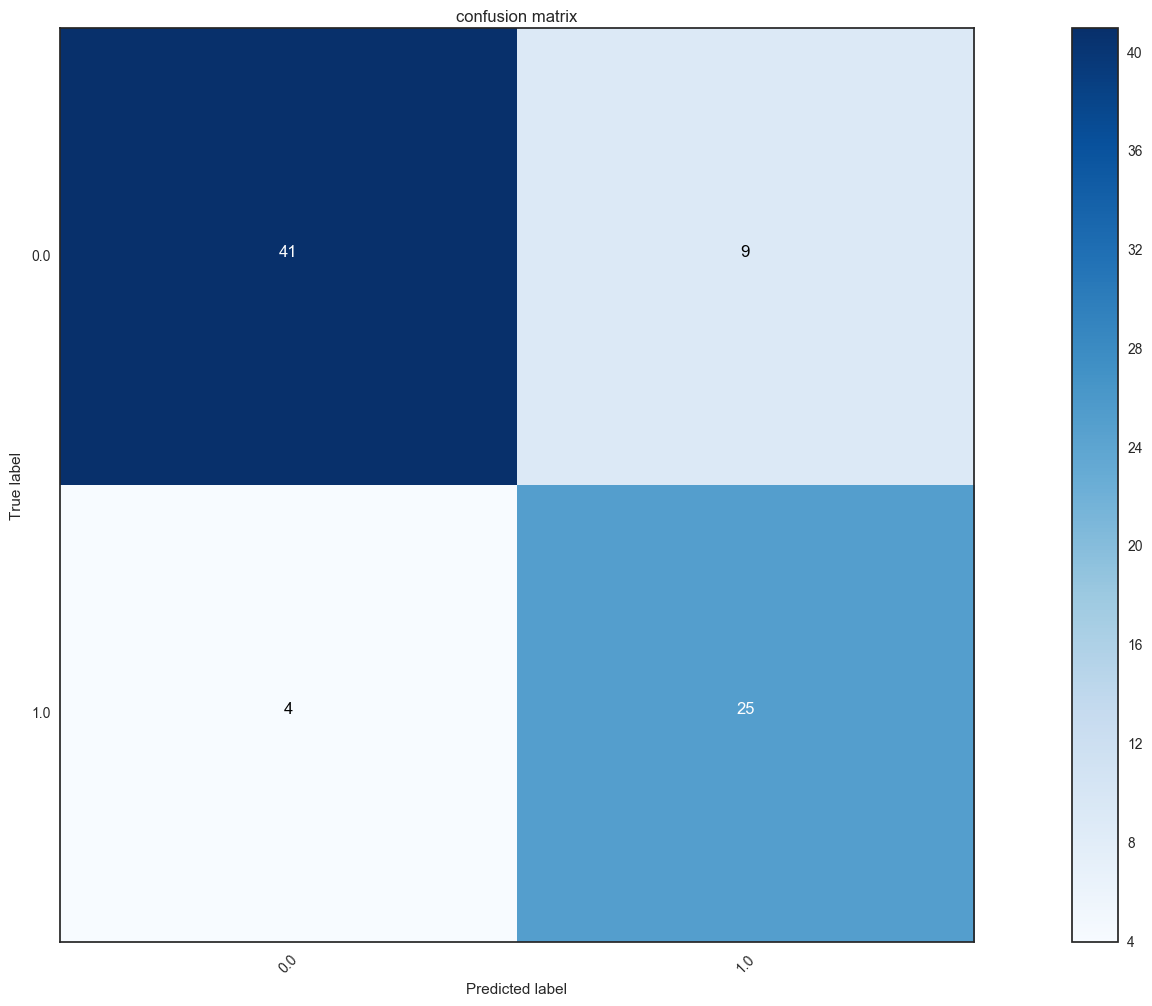

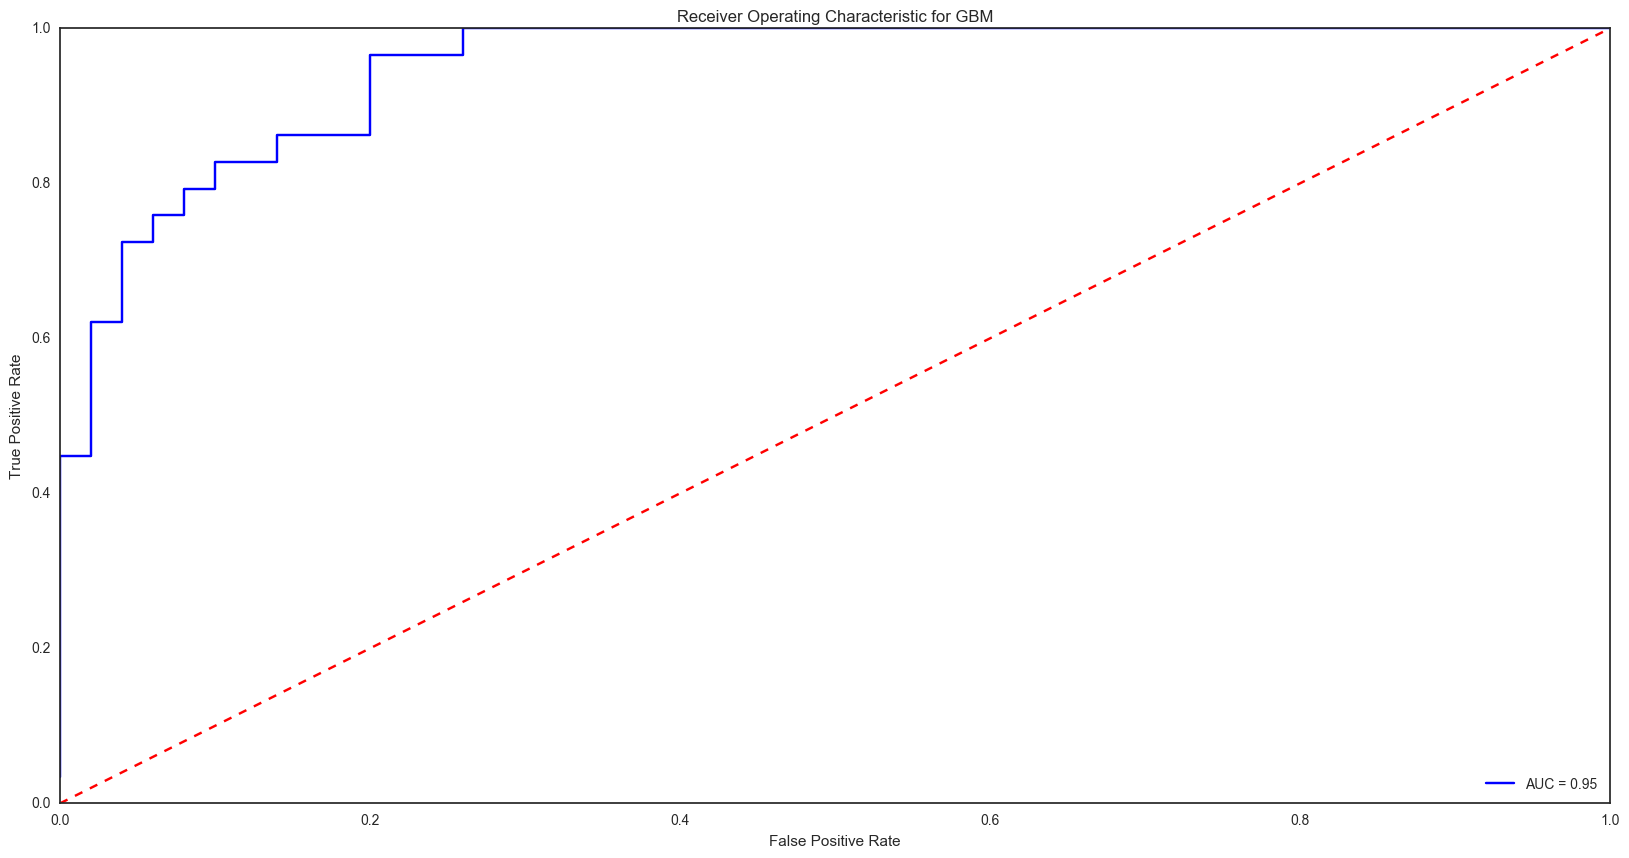

Validation based on RF
0.79746835443
[[40 10]
 [ 6 23]]
[[40 10]
 [ 6 23]]
             precision    recall  f1-score   support

        0.0       0.87      0.80      0.83        50
        1.0       0.70      0.79      0.74        29

avg / total       0.81      0.80      0.80        79



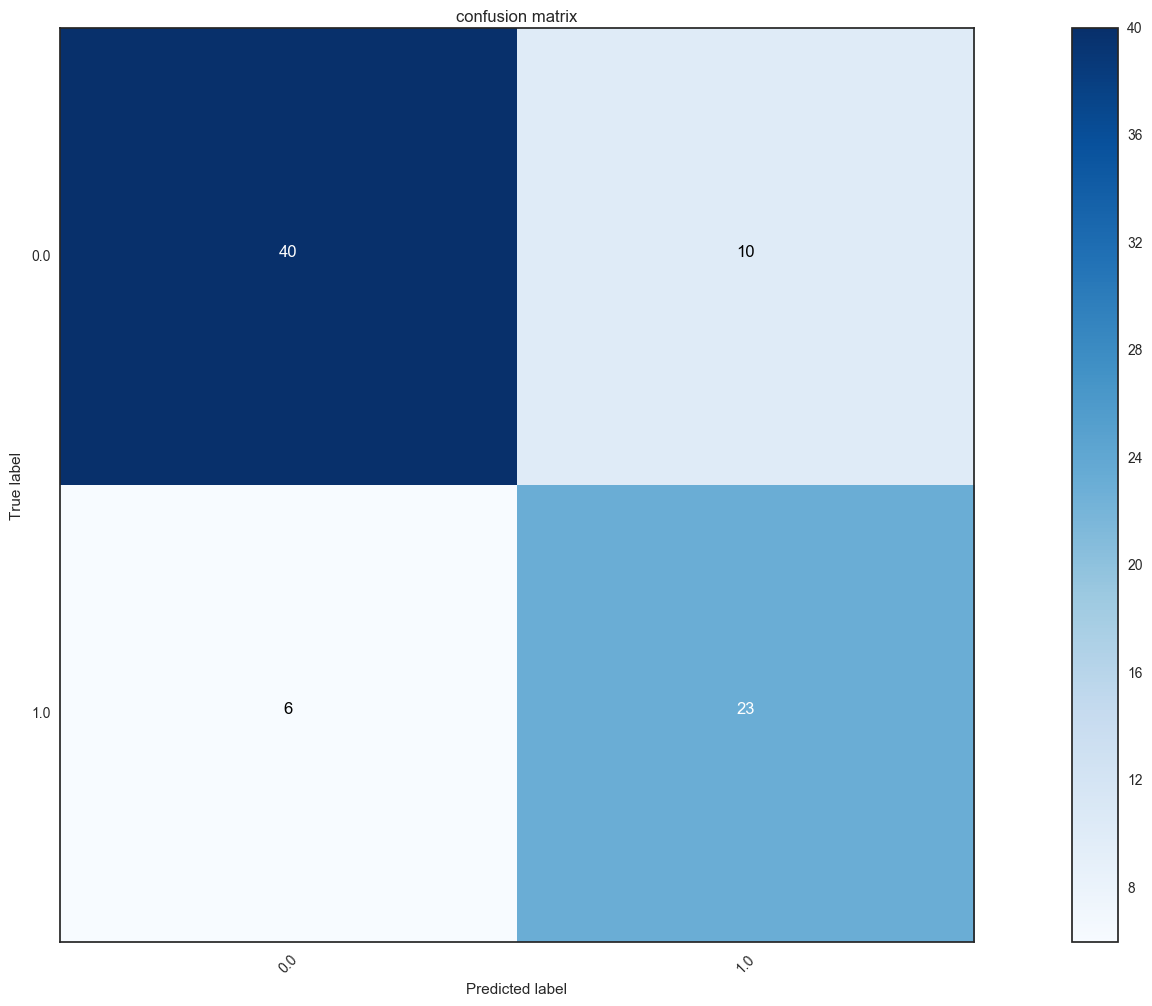

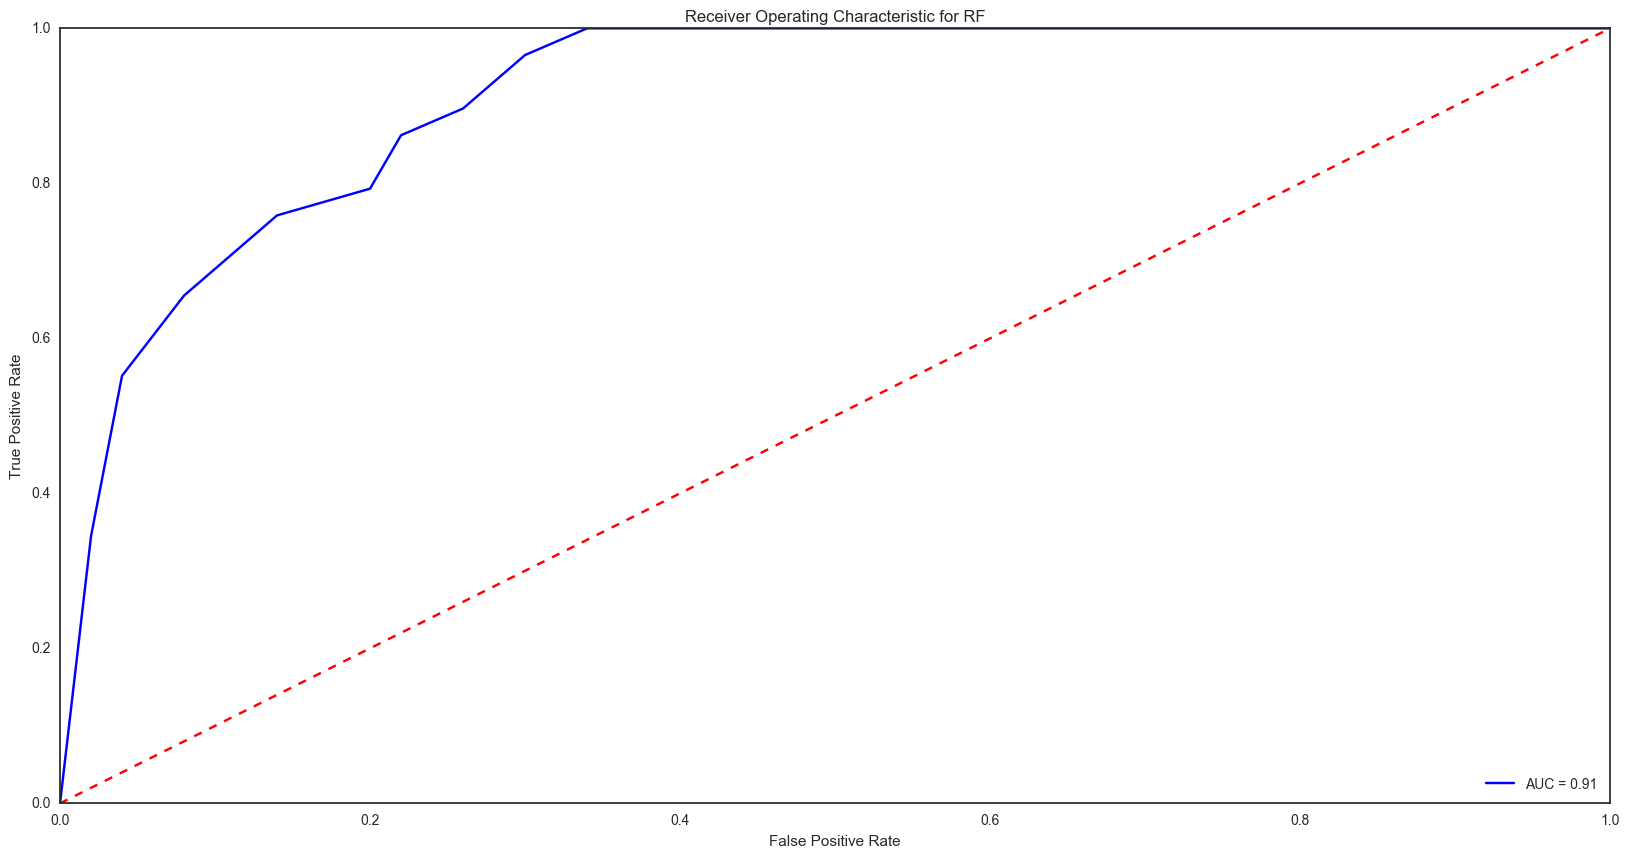

Validation based on ET
0.784810126582
[[40 10]
 [ 7 22]]
[[40 10]
 [ 7 22]]
             precision    recall  f1-score   support

        0.0       0.85      0.80      0.82        50
        1.0       0.69      0.76      0.72        29

avg / total       0.79      0.78      0.79        79



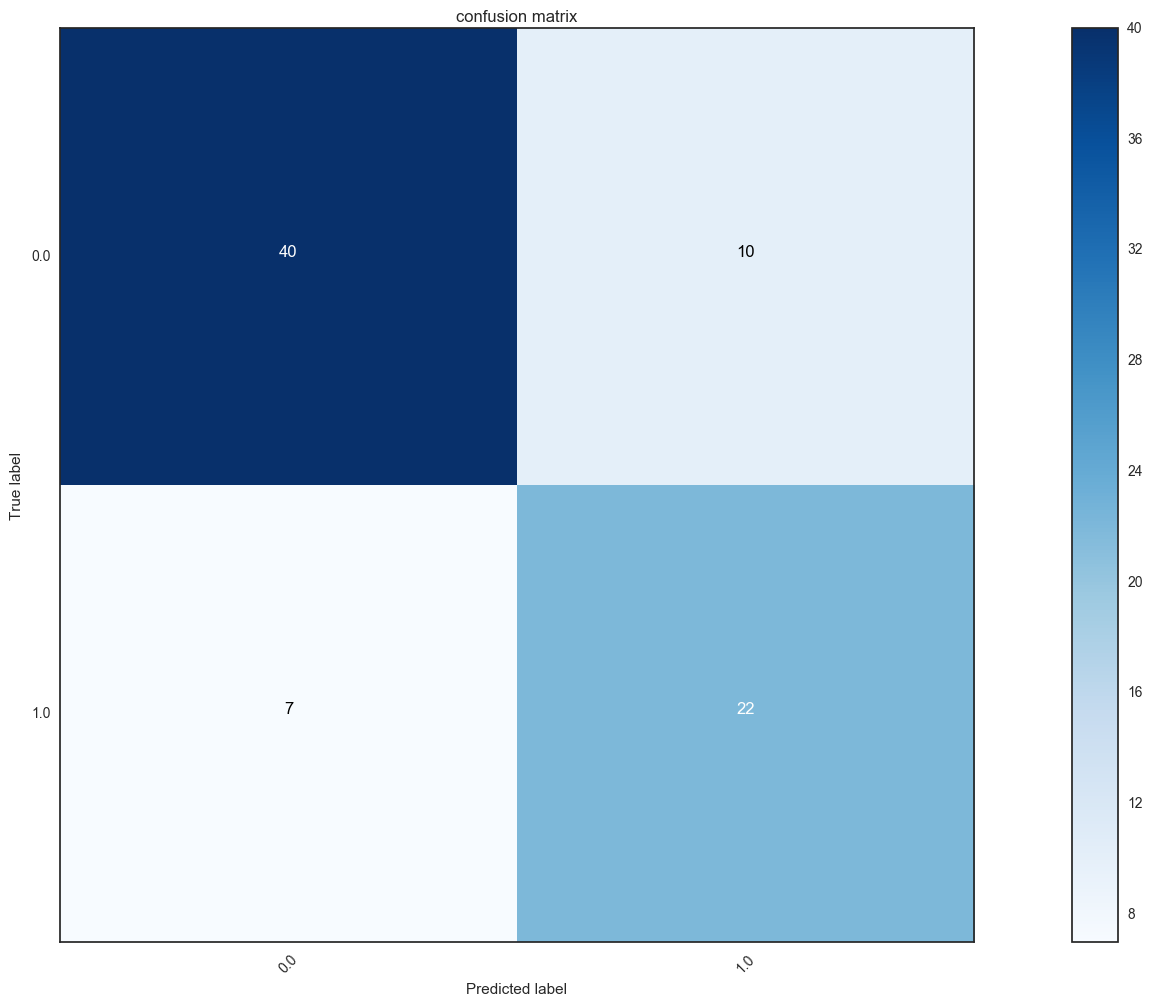

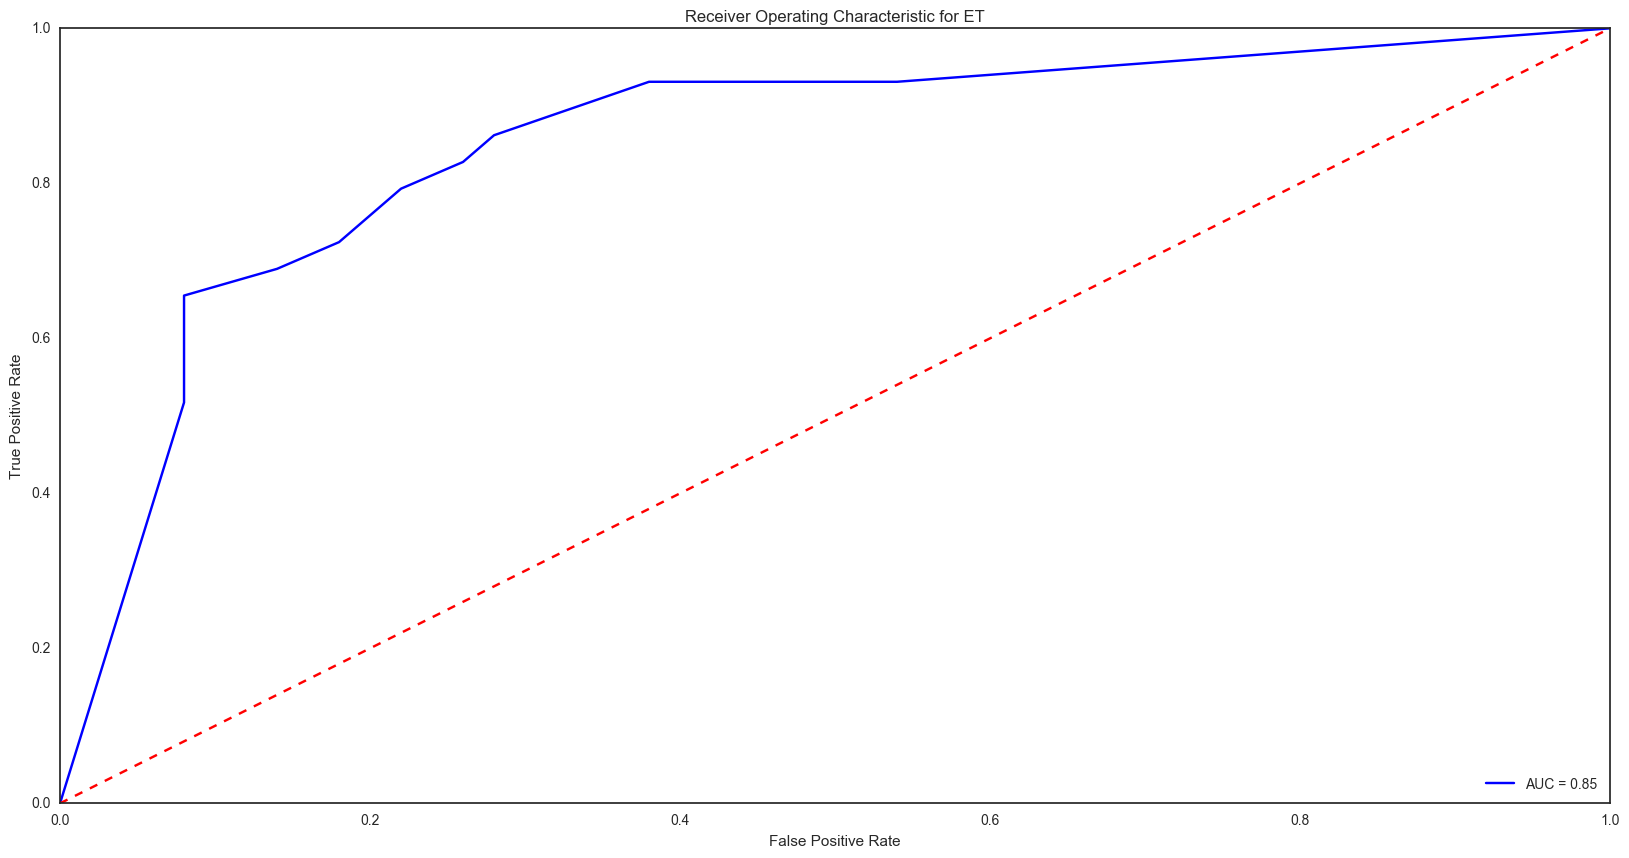

Validation based on XGB
0.835443037975
[[40 10]
 [ 3 26]]
[[40 10]
 [ 3 26]]
             precision    recall  f1-score   support

        0.0       0.93      0.80      0.86        50
        1.0       0.72      0.90      0.80        29

avg / total       0.85      0.84      0.84        79



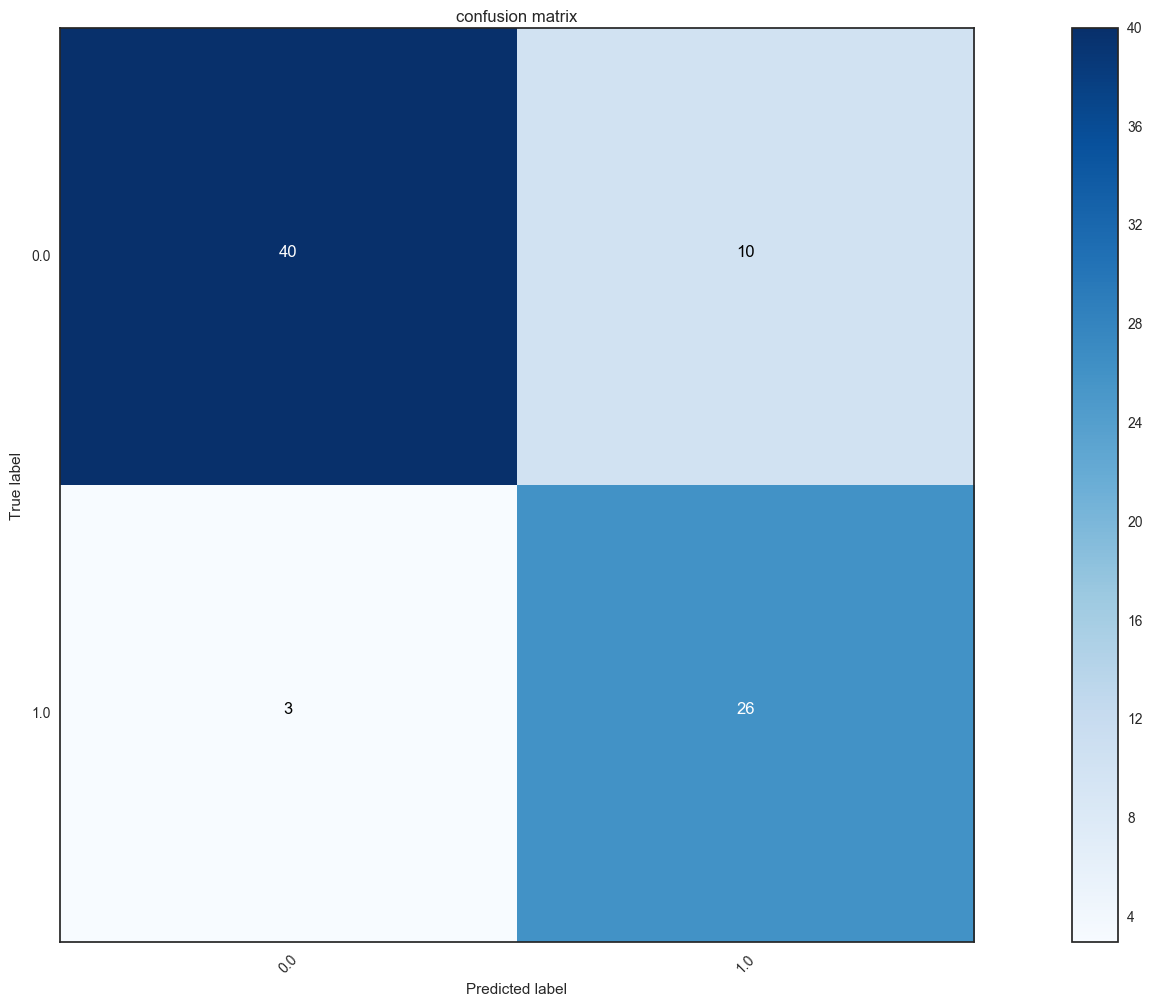

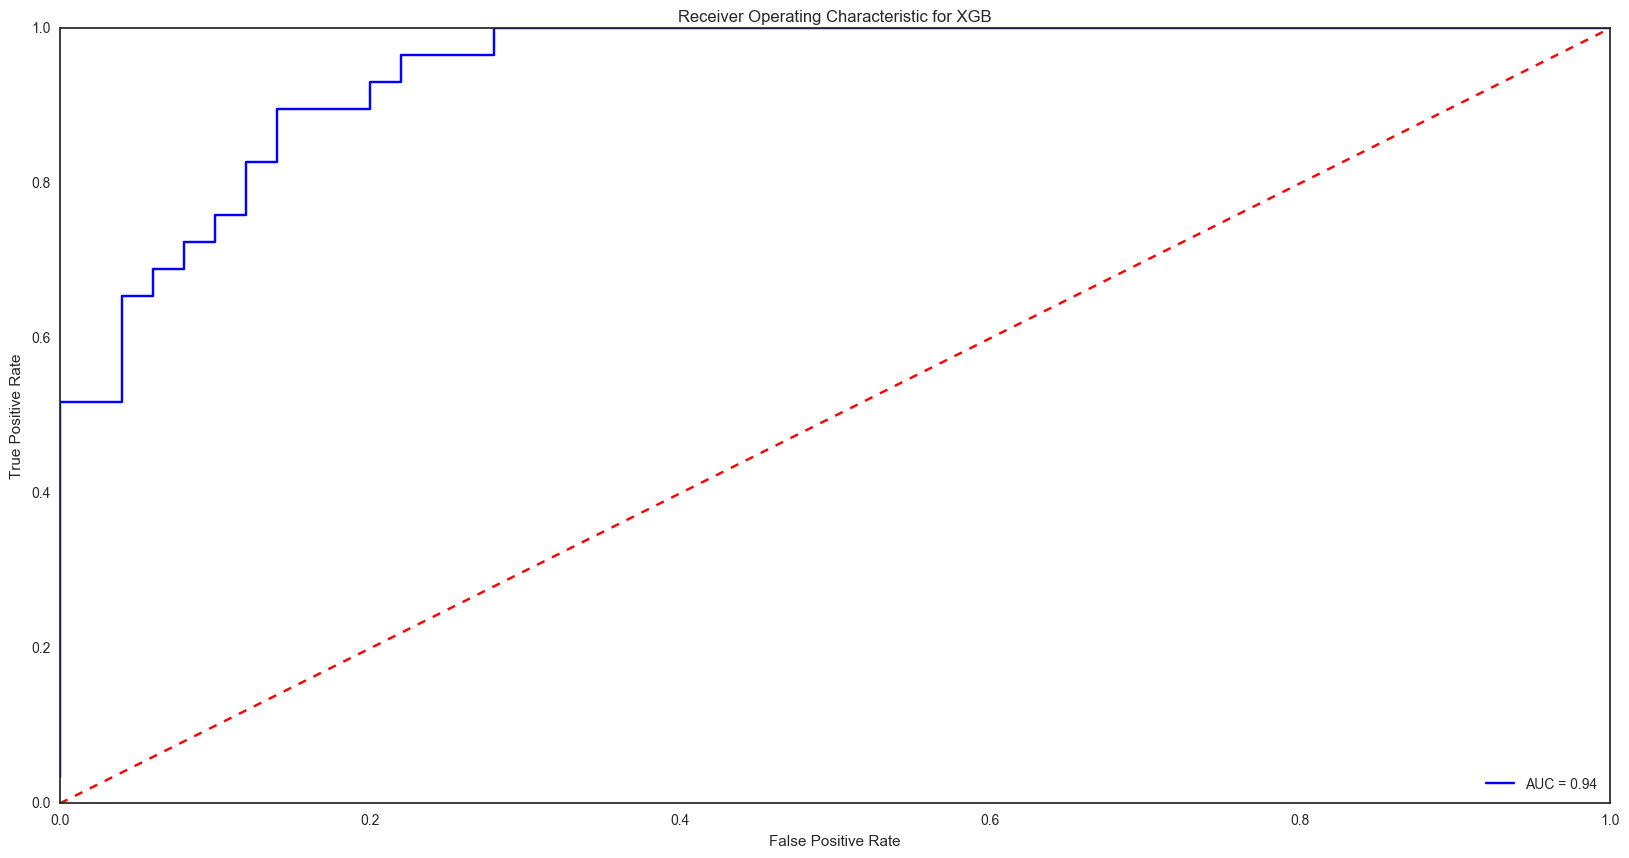

In [39]:
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def validate_models(training_set, outcome, validation_data, validation_outcome):
    
    models = []
    
    #baselines
    
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(probability=True)))
    
    #ensemble
    
    models.append(('AB', AdaBoostClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('ET', ExtraTreesClassifier()))
    models.append(('XGB', xgboost.XGBClassifier()))

    
    for name, model in models:
        mod = model
        mod.fit(training_set, outcome)
        # estimate accuracy on validation dataset
        predictions = mod.predict(validation_data)
        print "Validation based on " + name
        print(accuracy_score(validation_outcome, predictions))
        print(confusion_matrix(validation_outcome, predictions))
        cfmat = confusion_matrix(validation_outcome, predictions)
        plot_confusion_matrix(cfmat, classes=[0.0, 1.0] , title='confusion matrix')
        
        print(classification_report(validation_outcome, predictions))

        # calculate the fpr and tpr for all thresholds of the classification
        probs = mod.predict_proba(validation_data)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(validation_outcome, preds)
        roc_auc = auc(fpr, tpr)
        
        # method I: plt
        plt.figure(2)
        plt.title('Receiver Operating Characteristic for ' + name)
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
validate_models(X_train, Y_train, X_validation, Y_validation)

## Predicting outcome WITH feature selection


	Corr.	Linear reg	MIC	RF	RFE	Ridge	Stability	XGB	Mean
sex	0.0	0.15	0.0	0.04	0.55	0.25	0.0	0.03	0.04
weight.challenge	0.0	0.57	1.0	0.26	0.81	0.32	0.0	1.0	0.44
weight	0.02	0.52	0.3	0.23	0.77	0.26	0.0	0.35	0.28
ch.weight	0.13	0.85	0.35	0.24	1.0	0.39	0.0	0.33	0.34
pch.weight	0.15	1.0	0.44	0.49	1.0	0.87	0.0	0.44	0.46
hr.post.challenge 	0.2	0.19	0.56	0.71	0.68	0.32	0.0	0.52	0.42
score.overall	0.98	0.18	0.73	1.0	0.9	0.13	0.0	0.16	0.45
score.left	1.0	0.67	0.75	0.61	1.0	1.0	0.0	0.23	0.71
score.right	0.89	0.61	0.69	0.21	0.32	0.68	0.0	0.09	0.46
rights.mobile.overall	0.31	0.54	0.32	0.0	0.74	0.35	0.0	0.0	0.32
rights.shakey.overall	0.04	0.23	0.05	0.0	0.16	0.11	0.0	0.0	0.04
rights.lethargic.overall	0.02	0.61	0.02	0.01	1.0	0.51	0.0	0.01	0.02
rights.nonmobile.overall	0.0	0.59	0.0	0.0	0.84	0.65	0.0	0.01	0.01
fail_to_right.one.side.overall	0.07	0.03	0.07	0.0	0.1	0.1	0.0	0.01	0.05
fail_to_right.mobile.hips.over	0.0	0.01	0.0	0.0	0.06	0.07	0.0	0.0	0.0
fail_to_right.lethargic.hips.overall	0.1	0.16	0.11	0.0	0

/Users/Rad/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:74: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/Rad/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:76: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


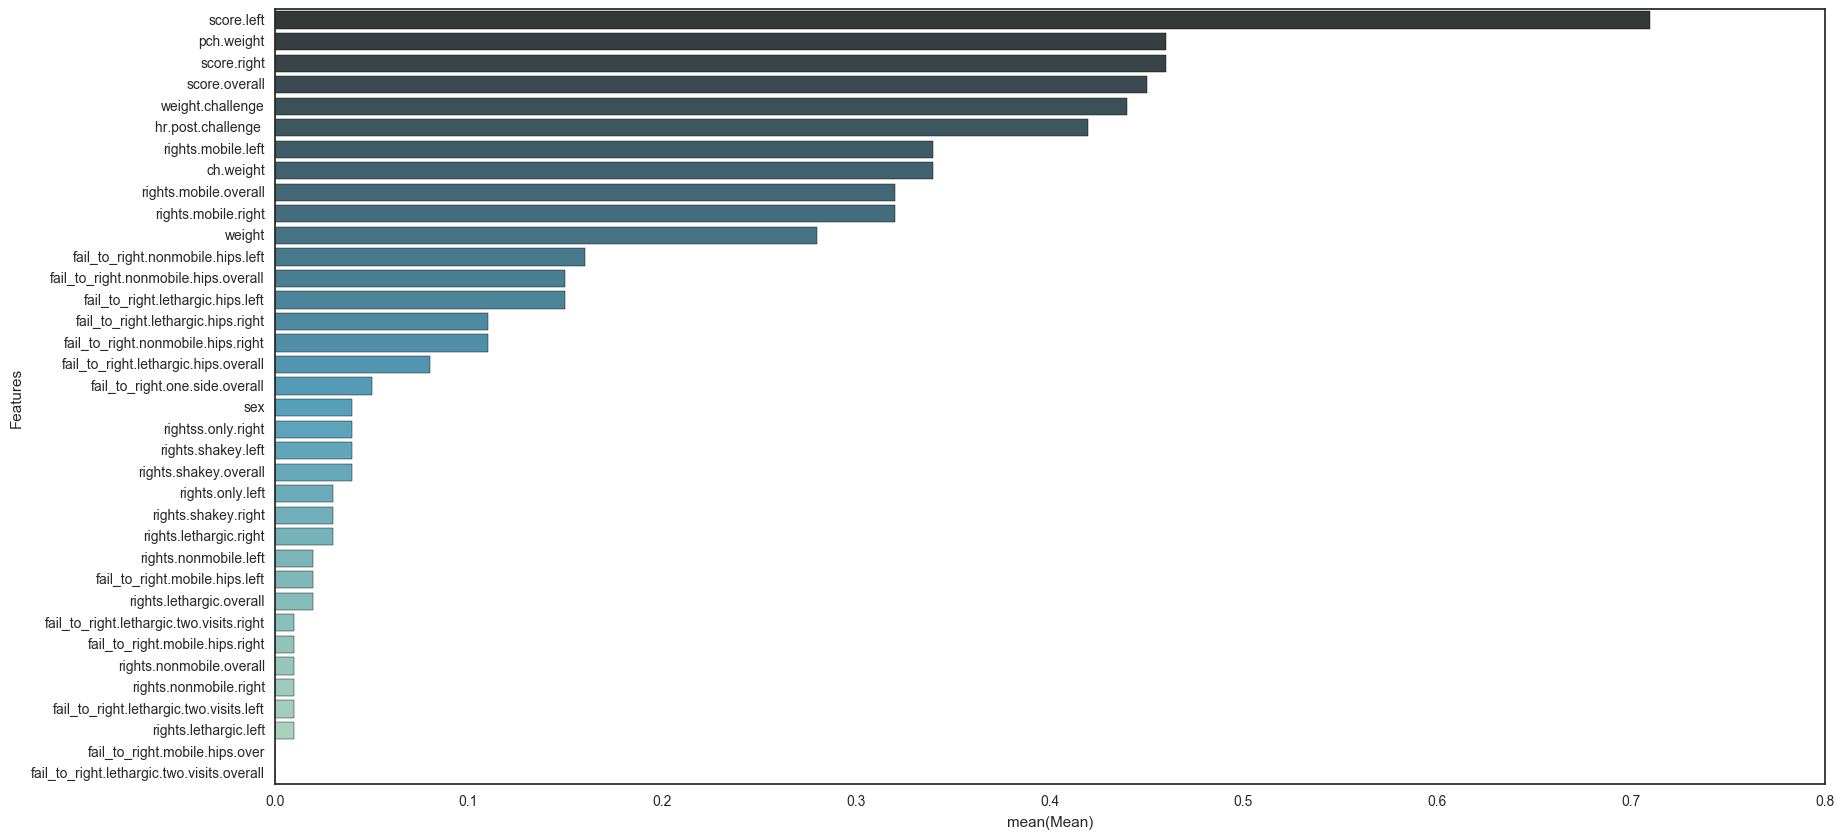

In [40]:
X = df_scaled_df
Y = df_clean_2["outcome"]
names = df_scaled_df.columns

names = X.columns
X = X.values
Y = Y.values

ranks = {}
 
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))
 
lr = LinearRegression(normalize=True)
lr.fit(X, Y)
ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), names)
 
ridge = Ridge(alpha=7)
ridge.fit(X, Y)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)
 
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["Stability"] = rank_to_dict(np.abs(rlasso.scores_), names)

rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X,Y)
ranks["RFE"] = rank_to_dict(map(float, rfe.ranking_), names, order=-1)
 
rf = RandomForestRegressor()
rf.fit(X,Y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)

xgb = xgboost.XGBRegressor()
xgb.fit(X,Y)
ranks["XGB"] = rank_to_dict(xgb.feature_importances_, names)
 
f, pval  = f_regression(X, Y, center=True)
ranks["Corr."] = rank_to_dict(f, names)
 
mine = MINE()
mic_scores = []
for i in range(X.shape[1]):
    mine.compute_score(X[:,i], Y)
    m = mine.mic()
    mic_scores.append(m)

ranks["MIC"] = rank_to_dict(mic_scores, names) 
 
r = {}
for name in names:
    r[name] = round(np.median([ranks[method][name] 
                             for method in ranks.keys()]), 2)

methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print "\t%s" % "\t".join(methods)
for name in names:
    print "%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods])))


results_FS = pd.DataFrame(columns=methods)
for name in names:
    results_FS.loc[name] = map(float, [ranks[method][name] for method in methods])

results_FS['Features'] = results_FS.index
results_FS.reset_index(level=0, inplace=True)
results_FS.sort(['Ridge'], ascending=False).head()
results_FS = results_FS.drop(['index'], axis=1)
ax = sns.barplot(y="Features", x="Mean", data=results_FS.sort(['Mean'], ascending=False), orient='h', palette="GnBu_d")

In [41]:
X = df_scaled_df
Y = df_clean_2["outcome"]
names = df_scaled_df.columns

X = X[["weight.challenge", "pch.weight", "score.left", "score.right", "score.overall", "hr.post.challenge "]]

# Validation dataset

validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,test_size=validation_size, random_state=seed)



### Base line Models



LR: 0.795665 (0.075804)
LDA: 0.818044 (0.061963)
KNN: 0.763609 (0.062758)
CART: 0.804839 (0.049125)
NB: 0.824496 (0.077055)
SVM: 0.801915 (0.073106)


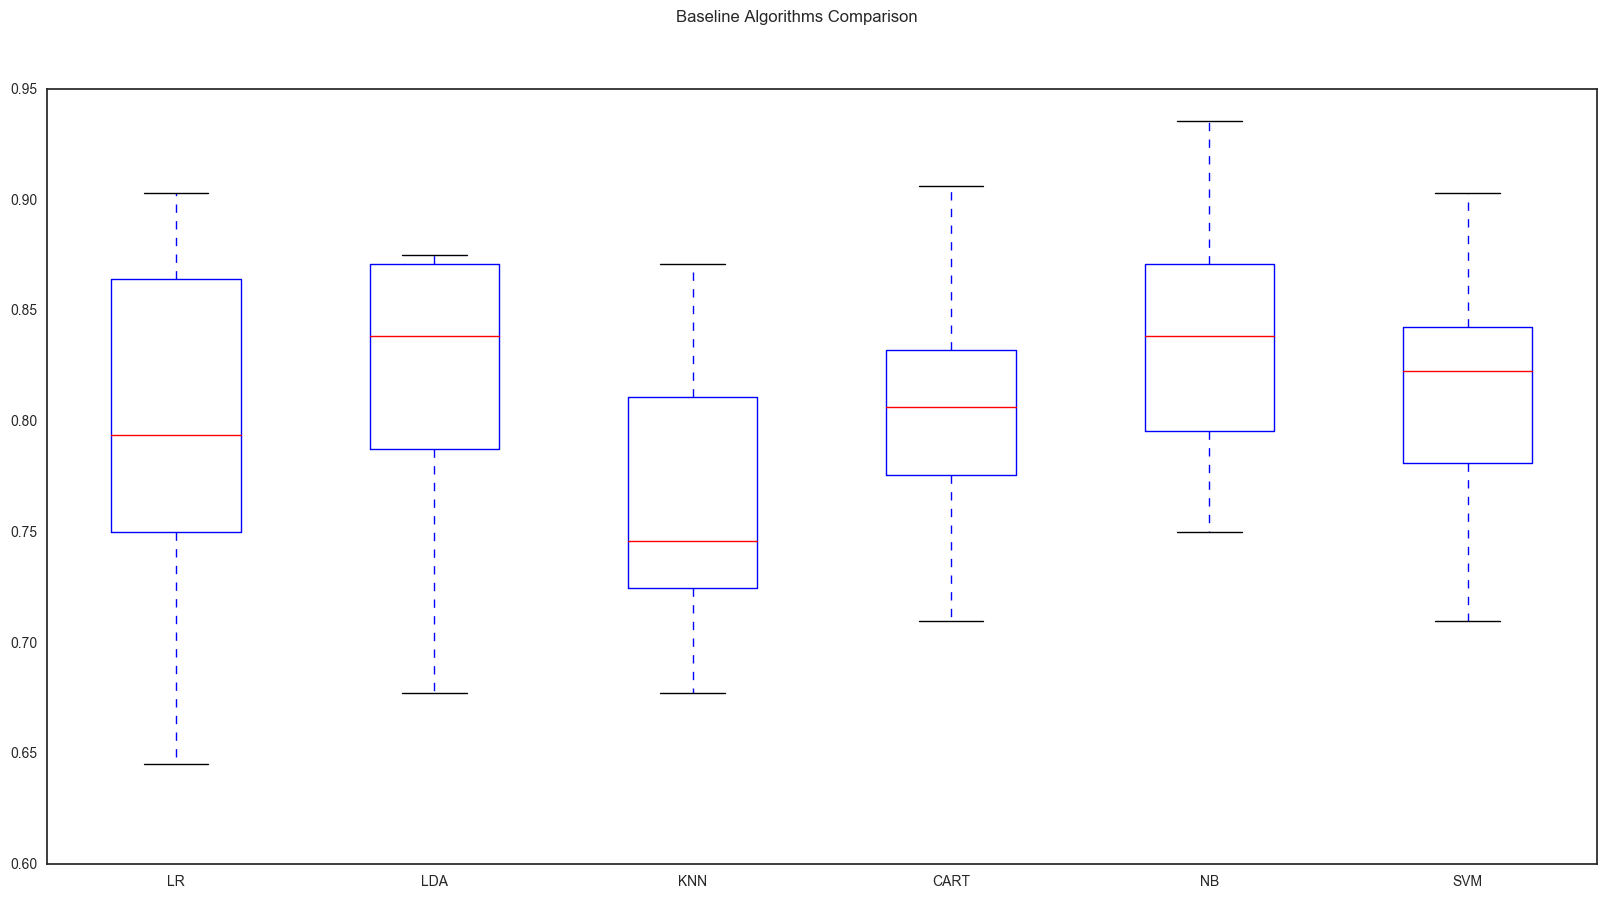

In [42]:
def base_line_models(training_set, outcome):
    # Test options and evaluation metric
    num_folds = 10
    num_instances = len(training_set)
    seed = 7
    scoring = 'accuracy'

    # Spot-Check Algorithms
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))
    results = []
    names = []
    for name, model in models:
        kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        cv_results = cross_validation.cross_val_score(model, training_set, outcome, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Baseline Algorithms Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

base_line_models(X_train, Y_train)

### Ensemble Methods

AB: 0.856048 (0.038896)
GBM: 0.868750 (0.046874)
RF: 0.817742 (0.084342)
ET: 0.792540 (0.065459)
XGB: 0.891028 (0.061705)


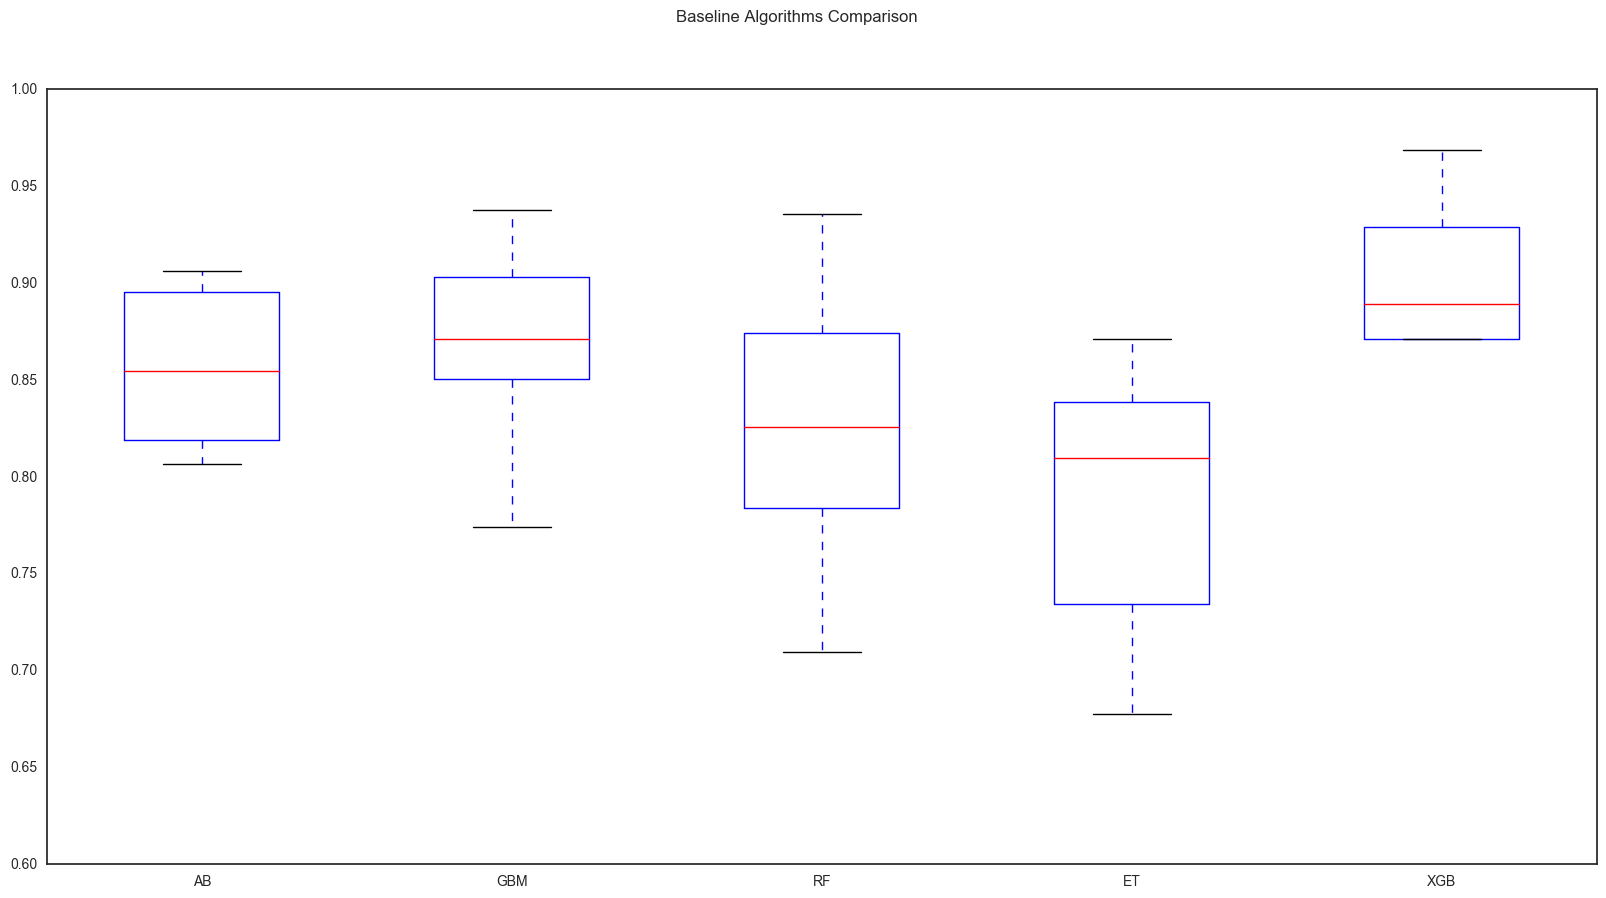

In [43]:
def ensemble_models(training_set, outcome):
    # Test options and evaluation metric
    num_folds = 10
    num_instances = len(training_set)
    seed = 7
    scoring = 'accuracy'

    # ensembles
    ensembles = []
    ensembles.append(('AB', AdaBoostClassifier()))
    ensembles.append(('GBM', GradientBoostingClassifier()))
    ensembles.append(('RF', RandomForestClassifier()))
    ensembles.append(('ET', ExtraTreesClassifier()))
    ensembles.append(('XGB', xgboost.XGBClassifier()))
    results = []
    names = []
    for name, model in ensembles:
        kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        cv_results = cross_validation.cross_val_score(model, training_set, outcome, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Baseline Algorithms Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

ensemble_models(X_train, Y_train)

### Model Validation


Validation based on LR
0.835443037975
[[42  8]
 [ 5 24]]
[[42  8]
 [ 5 24]]
             precision    recall  f1-score   support

        0.0       0.89      0.84      0.87        50
        1.0       0.75      0.83      0.79        29

avg / total       0.84      0.84      0.84        79



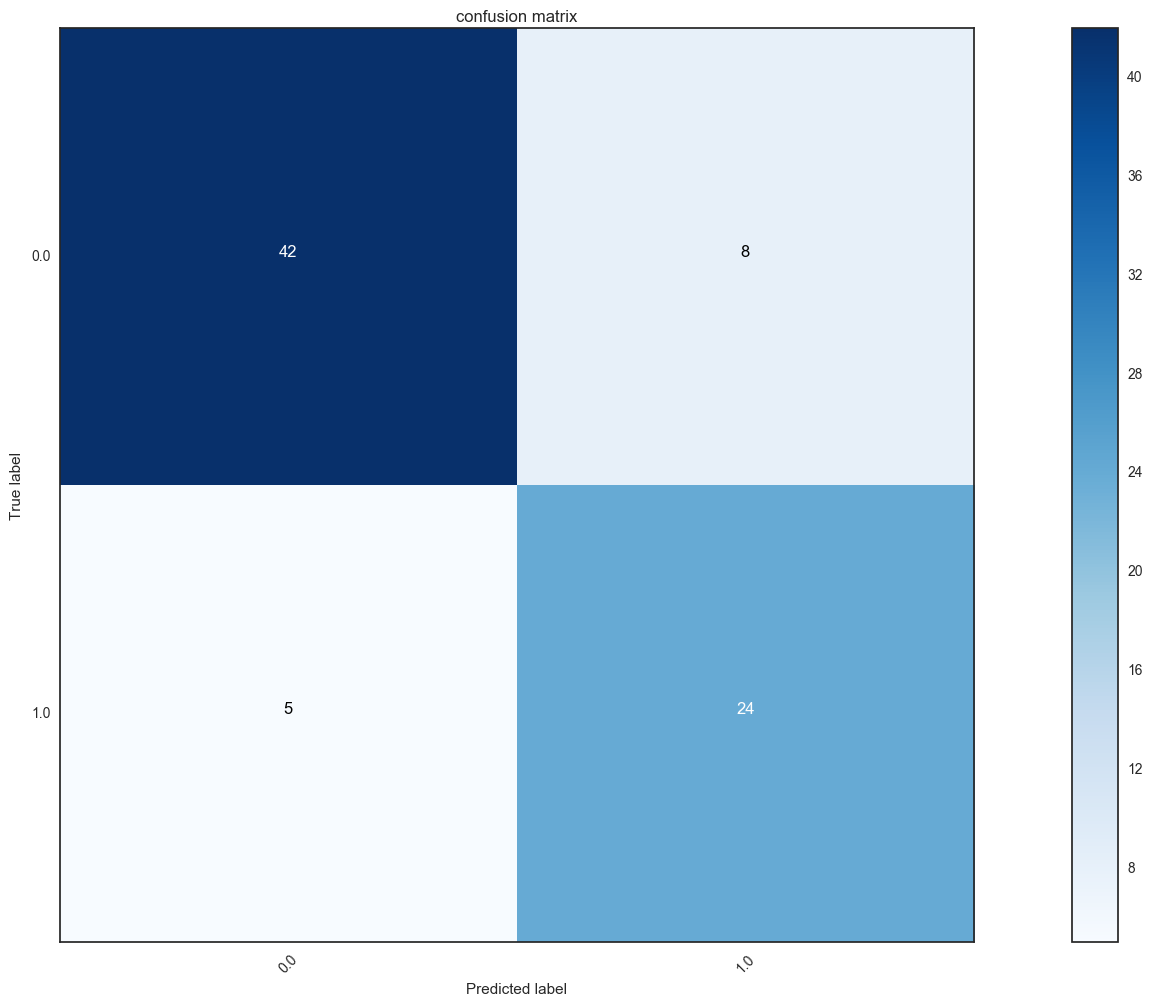

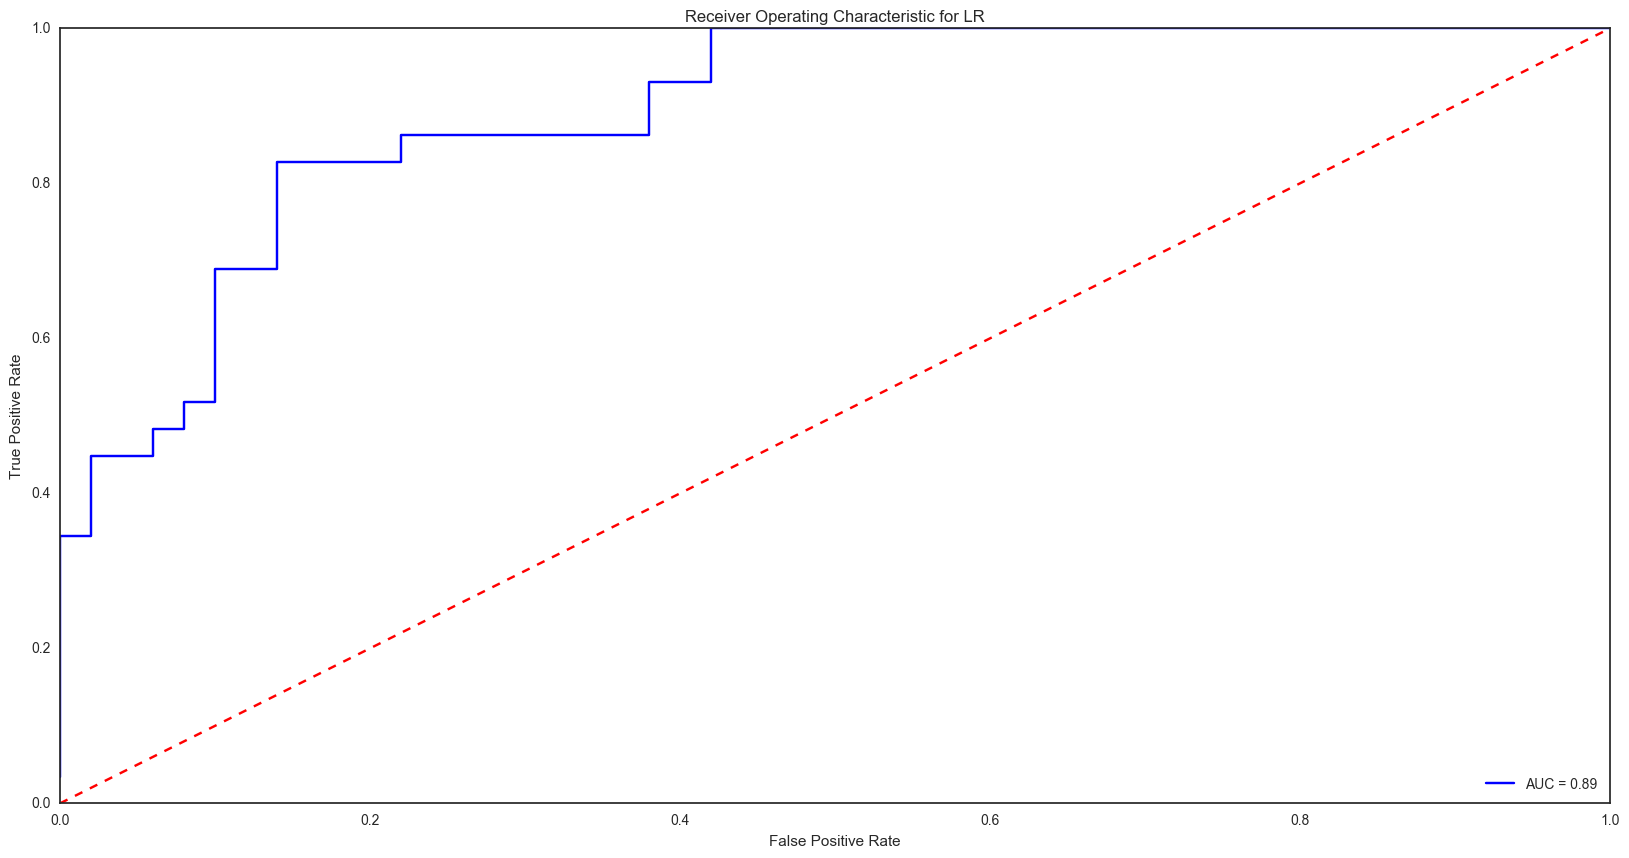

Validation based on LDA
0.835443037975
[[44  6]
 [ 7 22]]
[[44  6]
 [ 7 22]]
             precision    recall  f1-score   support

        0.0       0.86      0.88      0.87        50
        1.0       0.79      0.76      0.77        29

avg / total       0.83      0.84      0.83        79



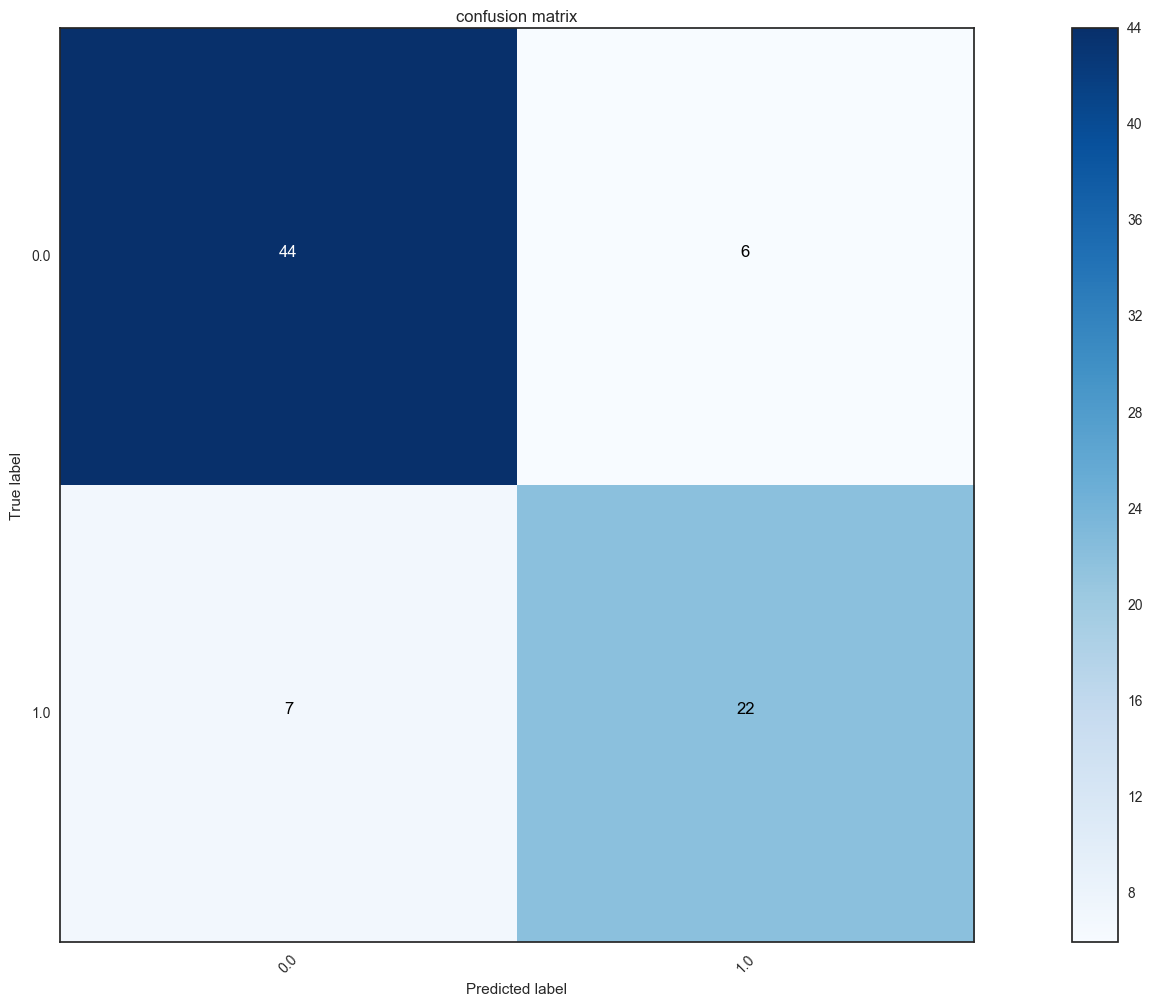

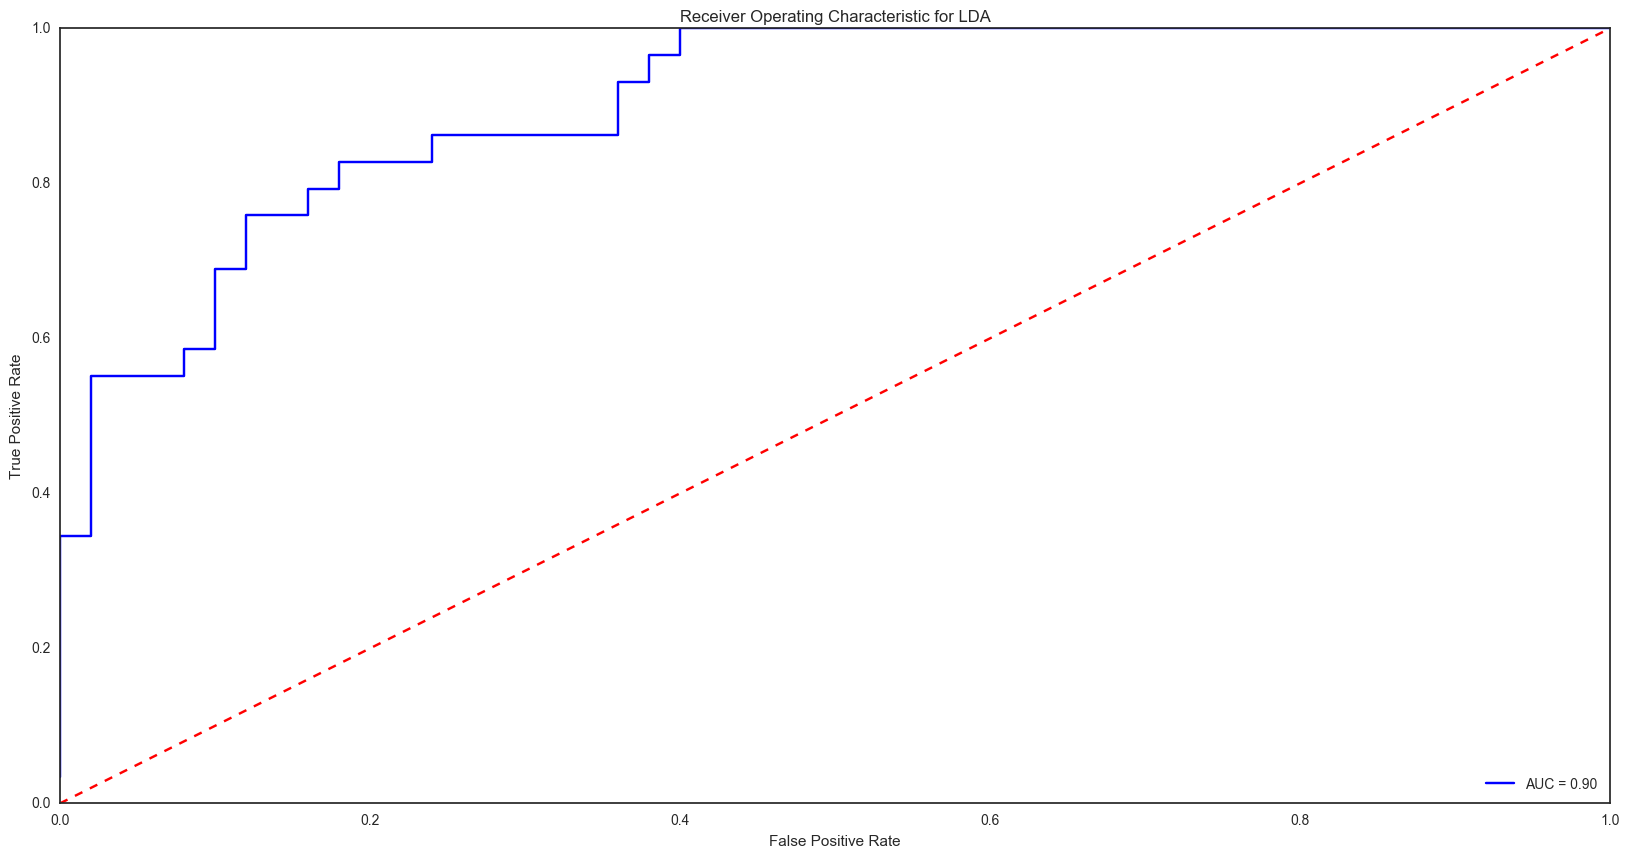

Validation based on KNN
0.848101265823
[[42  8]
 [ 4 25]]
[[42  8]
 [ 4 25]]
             precision    recall  f1-score   support

        0.0       0.91      0.84      0.87        50
        1.0       0.76      0.86      0.81        29

avg / total       0.86      0.85      0.85        79



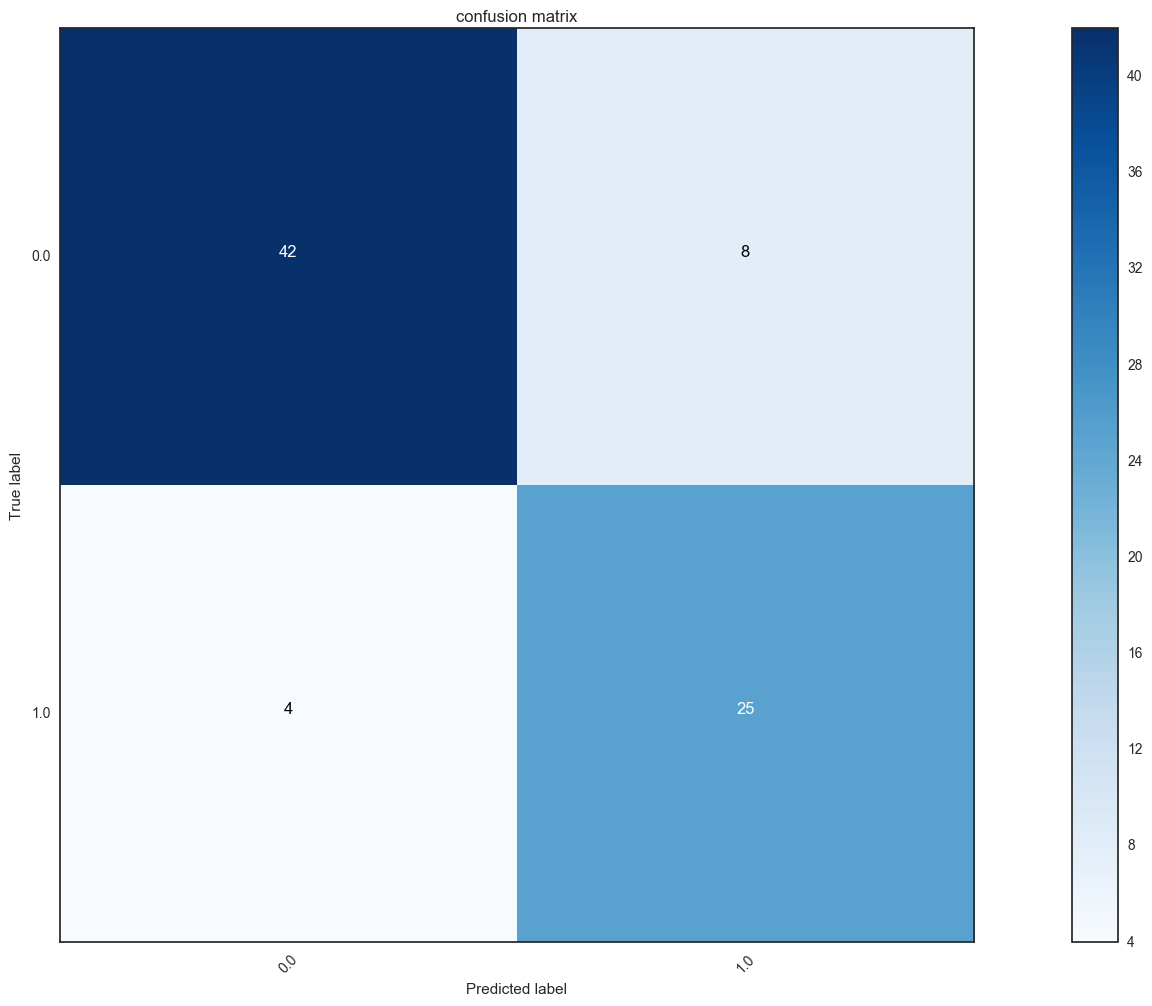

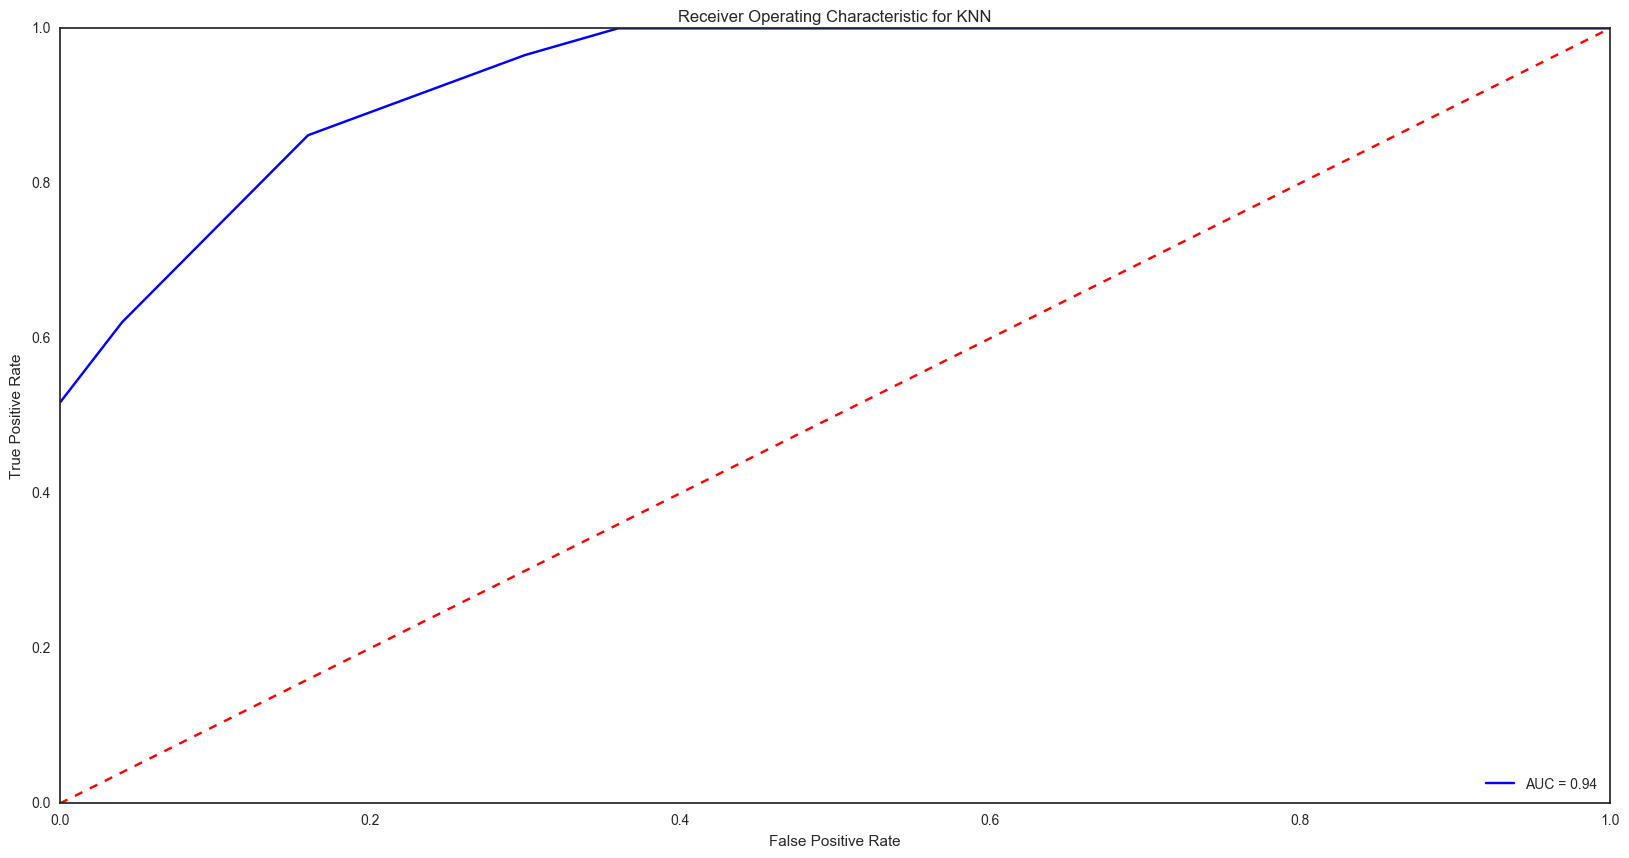

Validation based on CART
0.810126582278
[[41  9]
 [ 6 23]]
[[41  9]
 [ 6 23]]
             precision    recall  f1-score   support

        0.0       0.87      0.82      0.85        50
        1.0       0.72      0.79      0.75        29

avg / total       0.82      0.81      0.81        79



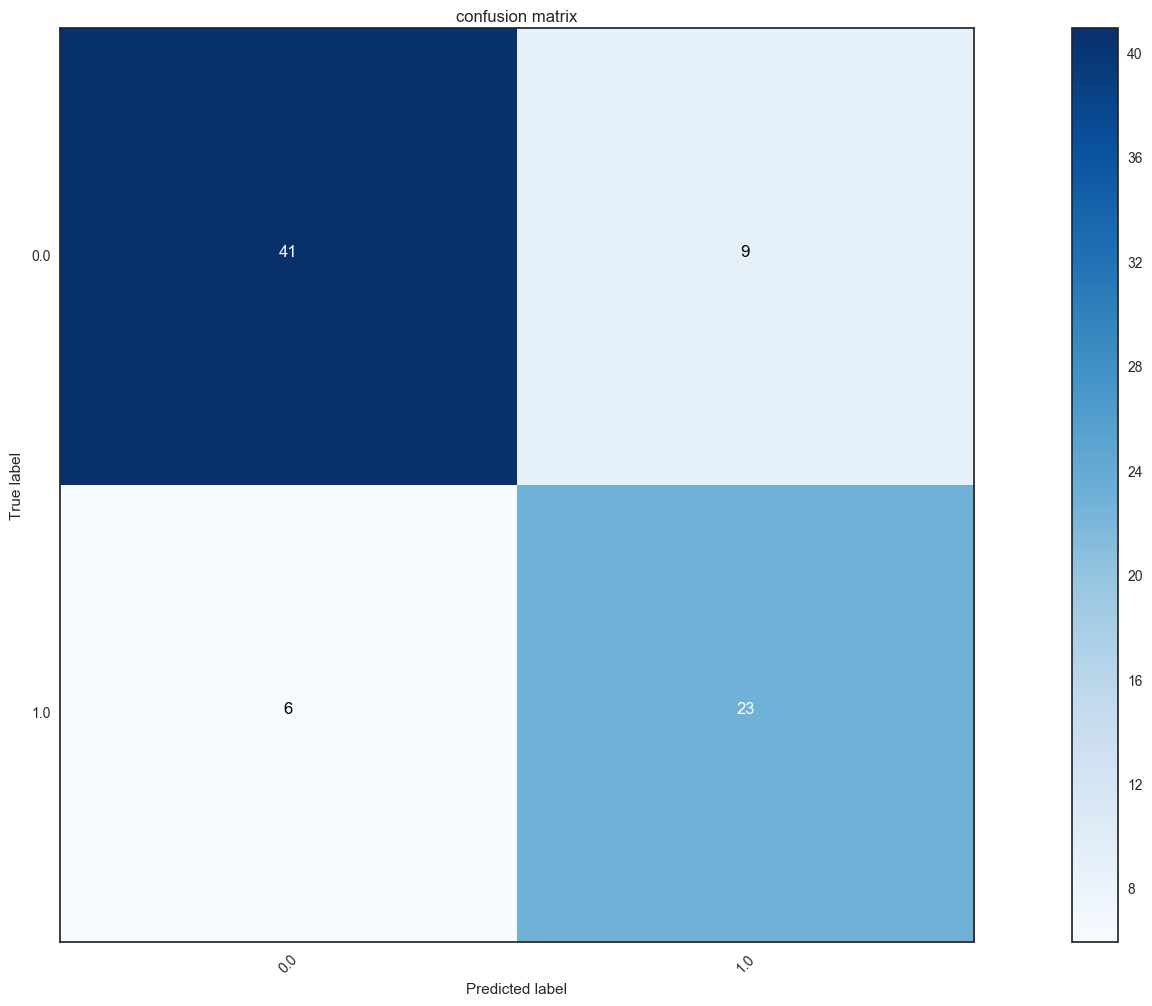

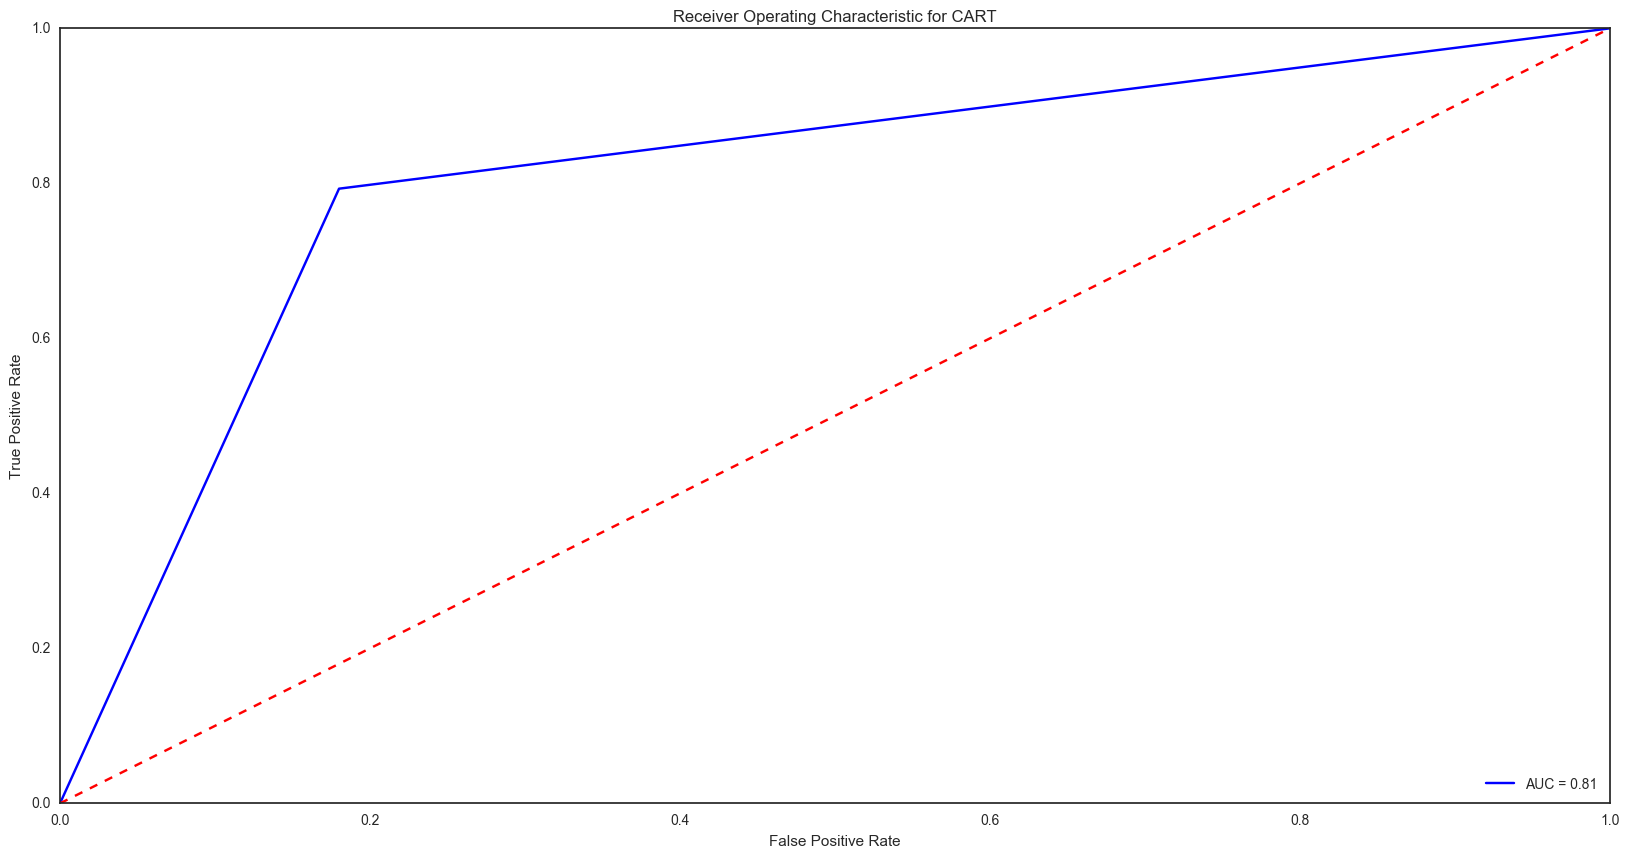

Validation based on NB
0.810126582278
[[40 10]
 [ 5 24]]
[[40 10]
 [ 5 24]]
             precision    recall  f1-score   support

        0.0       0.89      0.80      0.84        50
        1.0       0.71      0.83      0.76        29

avg / total       0.82      0.81      0.81        79



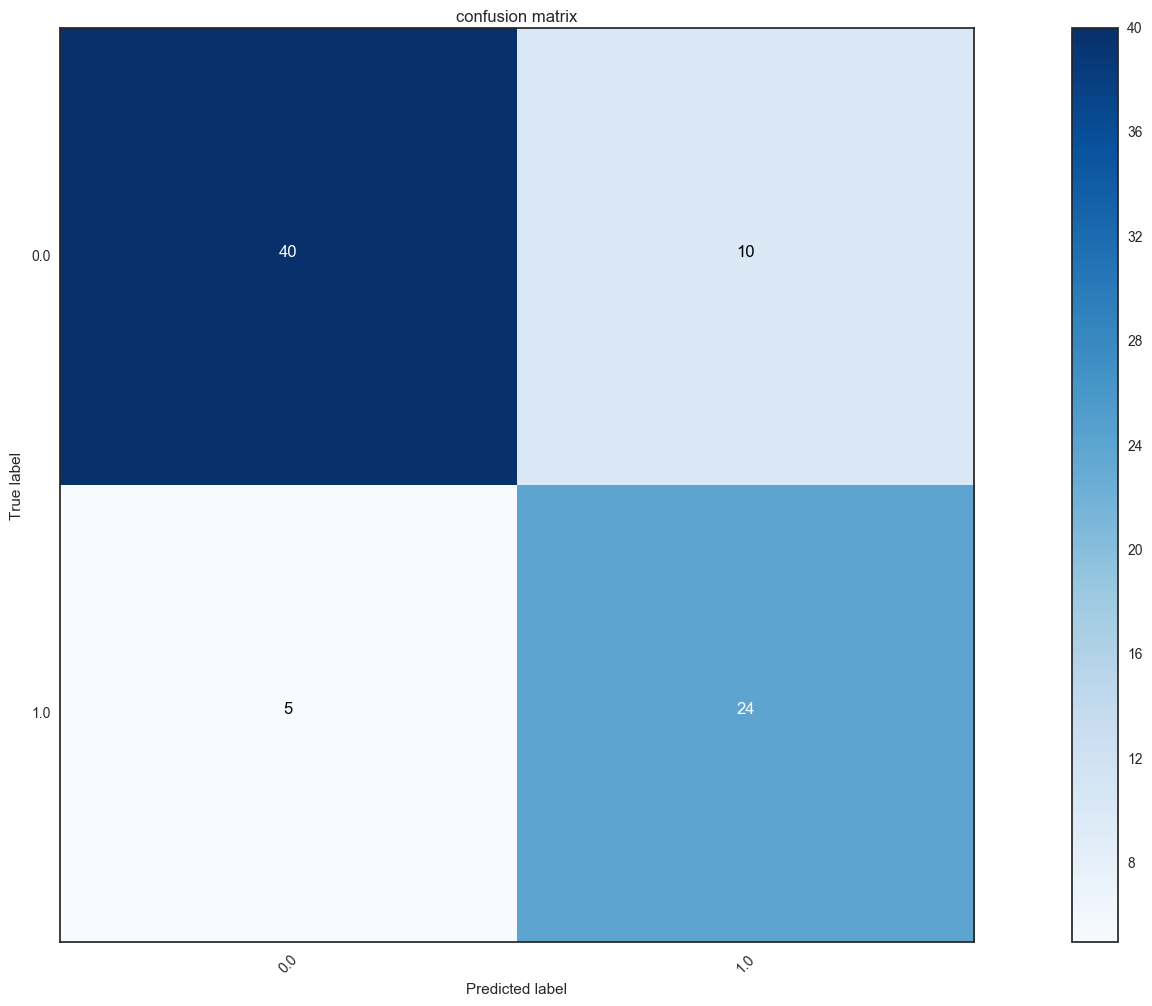

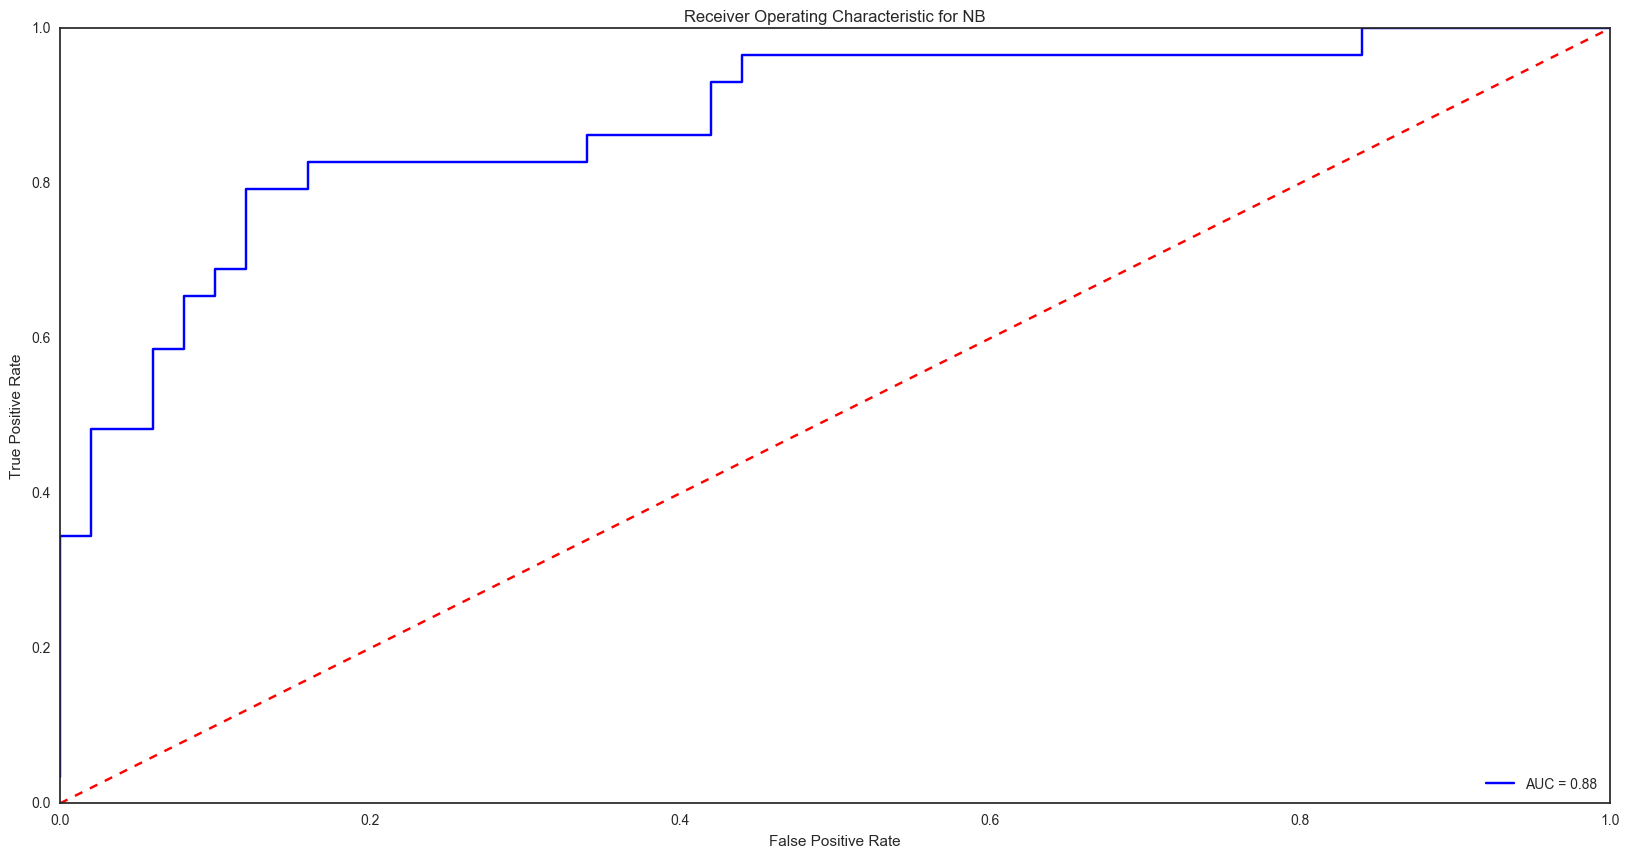

Validation based on SVM
0.79746835443
[[39 11]
 [ 5 24]]
[[39 11]
 [ 5 24]]
             precision    recall  f1-score   support

        0.0       0.89      0.78      0.83        50
        1.0       0.69      0.83      0.75        29

avg / total       0.81      0.80      0.80        79



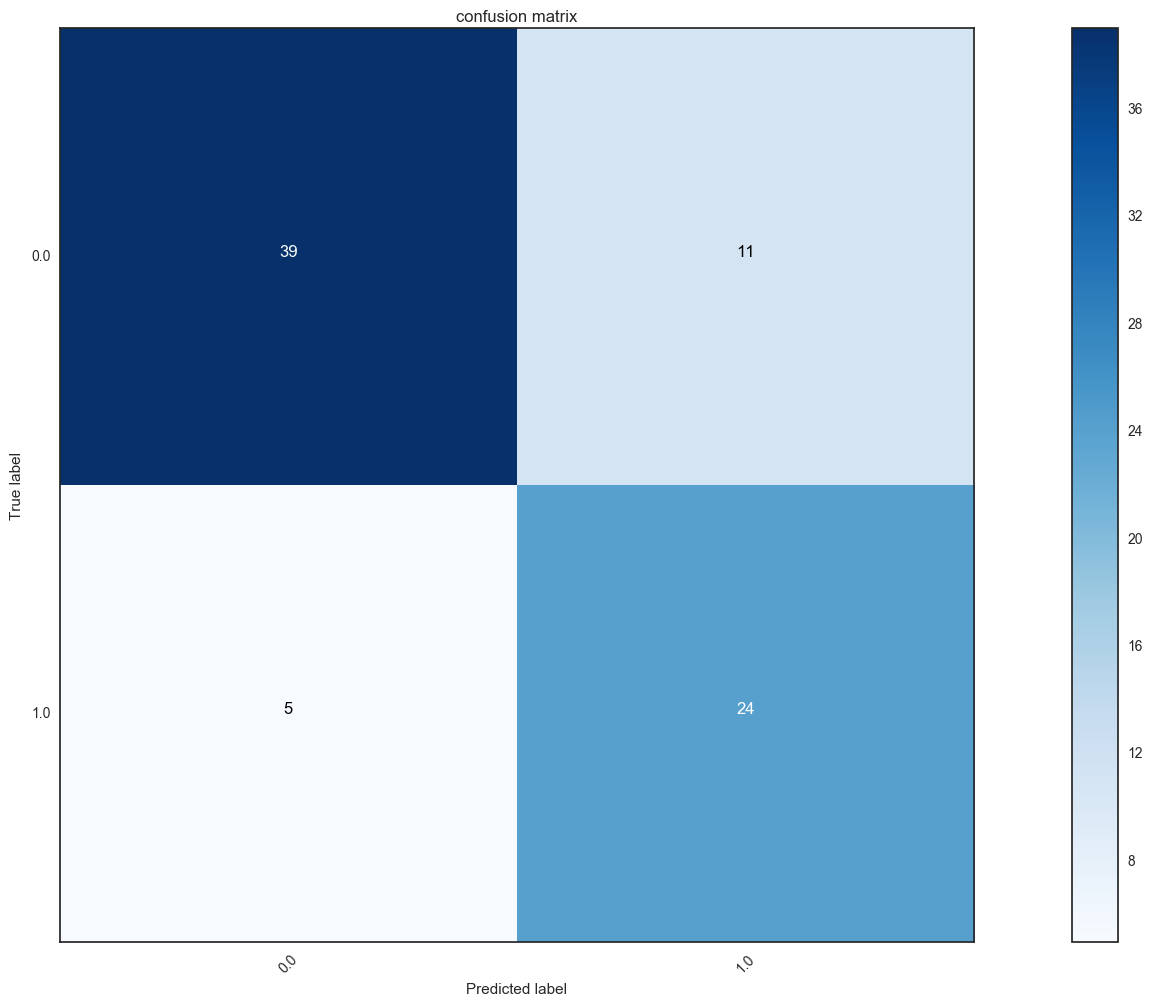

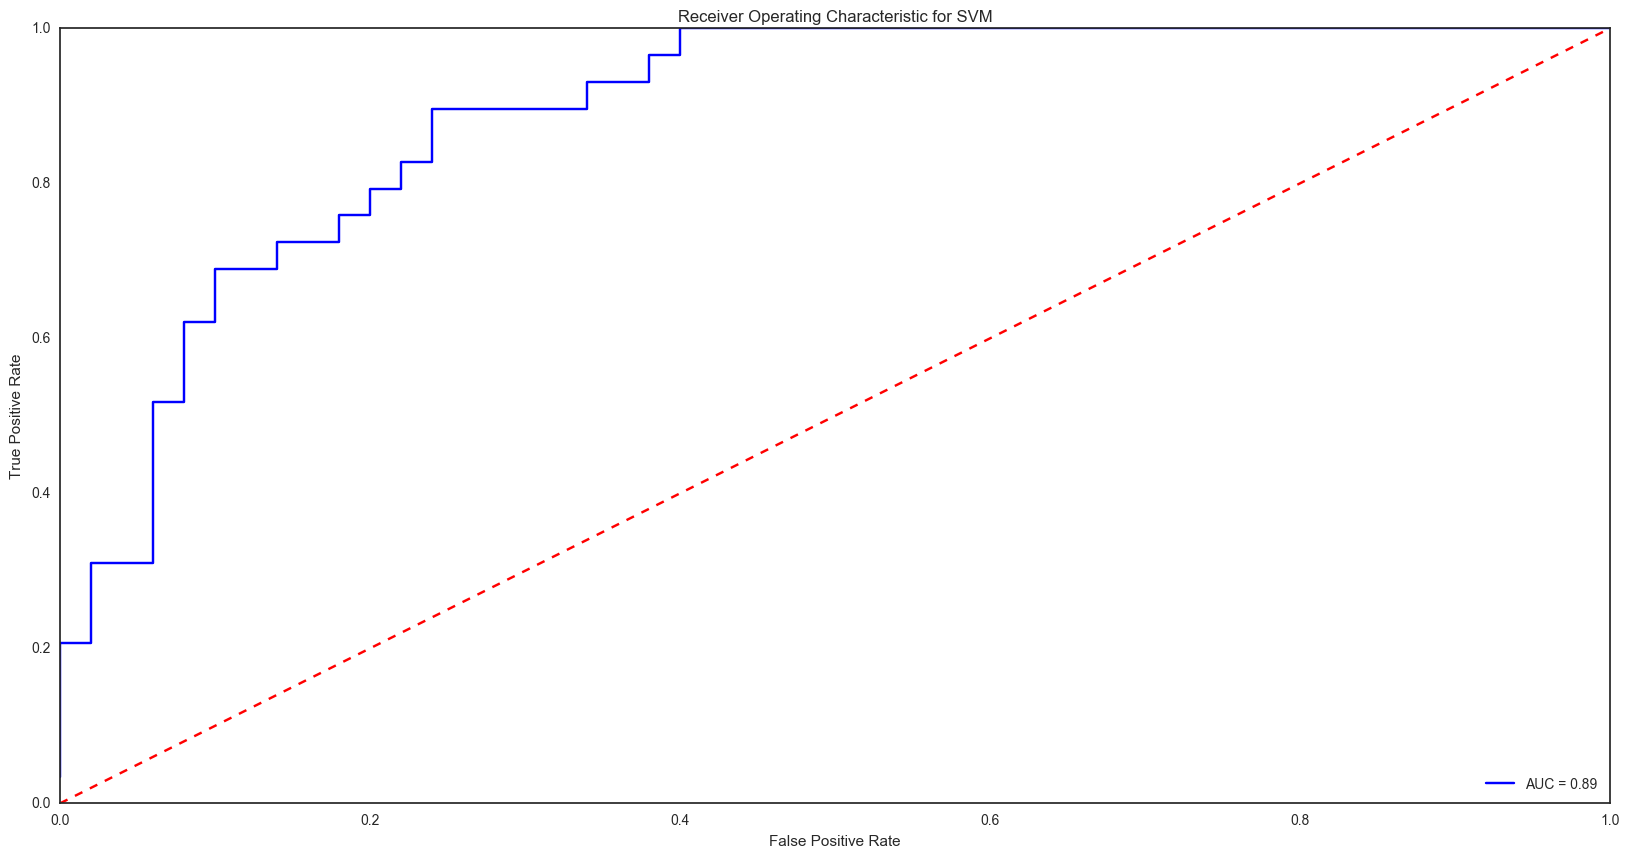

Validation based on AB
0.886075949367
[[46  4]
 [ 5 24]]
[[46  4]
 [ 5 24]]
             precision    recall  f1-score   support

        0.0       0.90      0.92      0.91        50
        1.0       0.86      0.83      0.84        29

avg / total       0.89      0.89      0.89        79



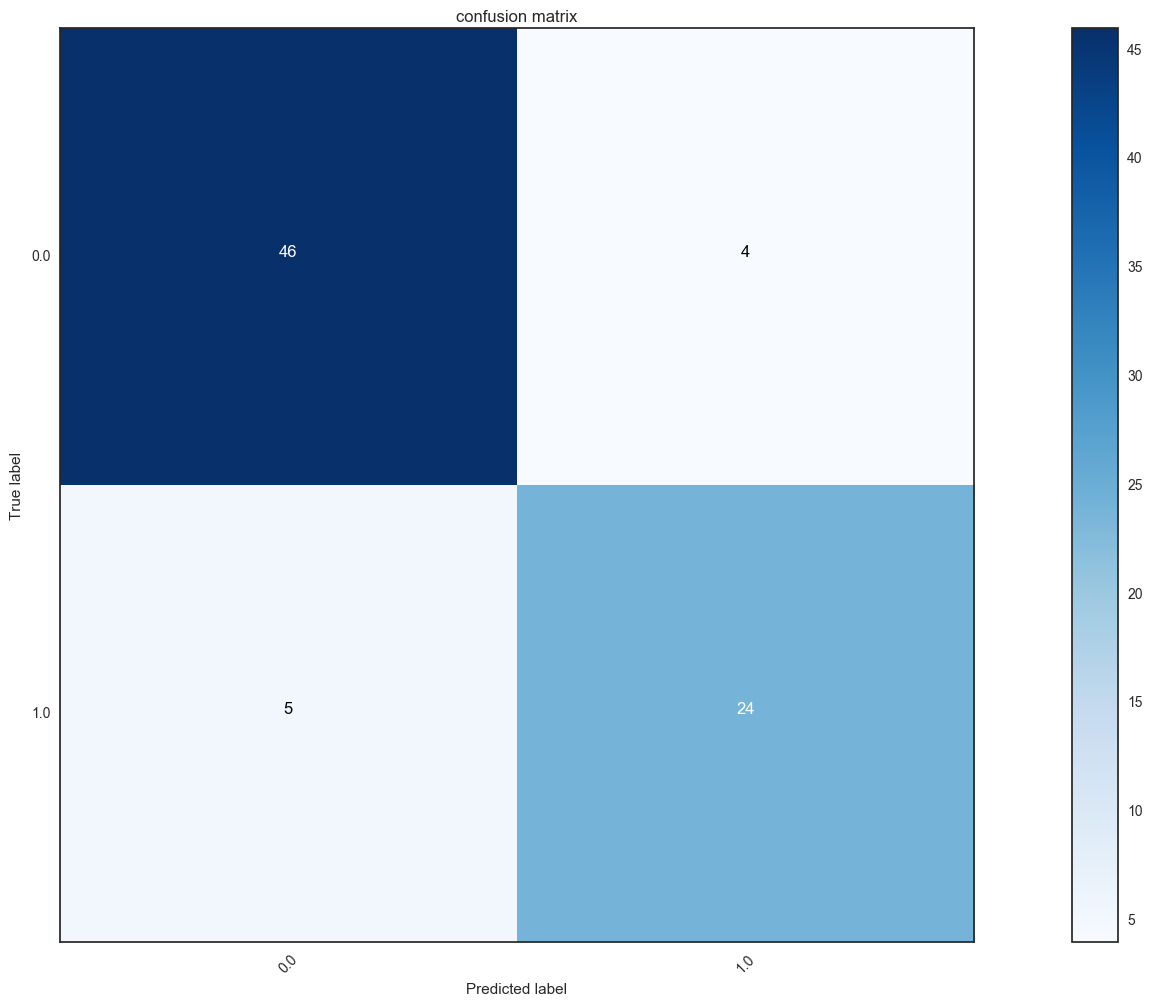

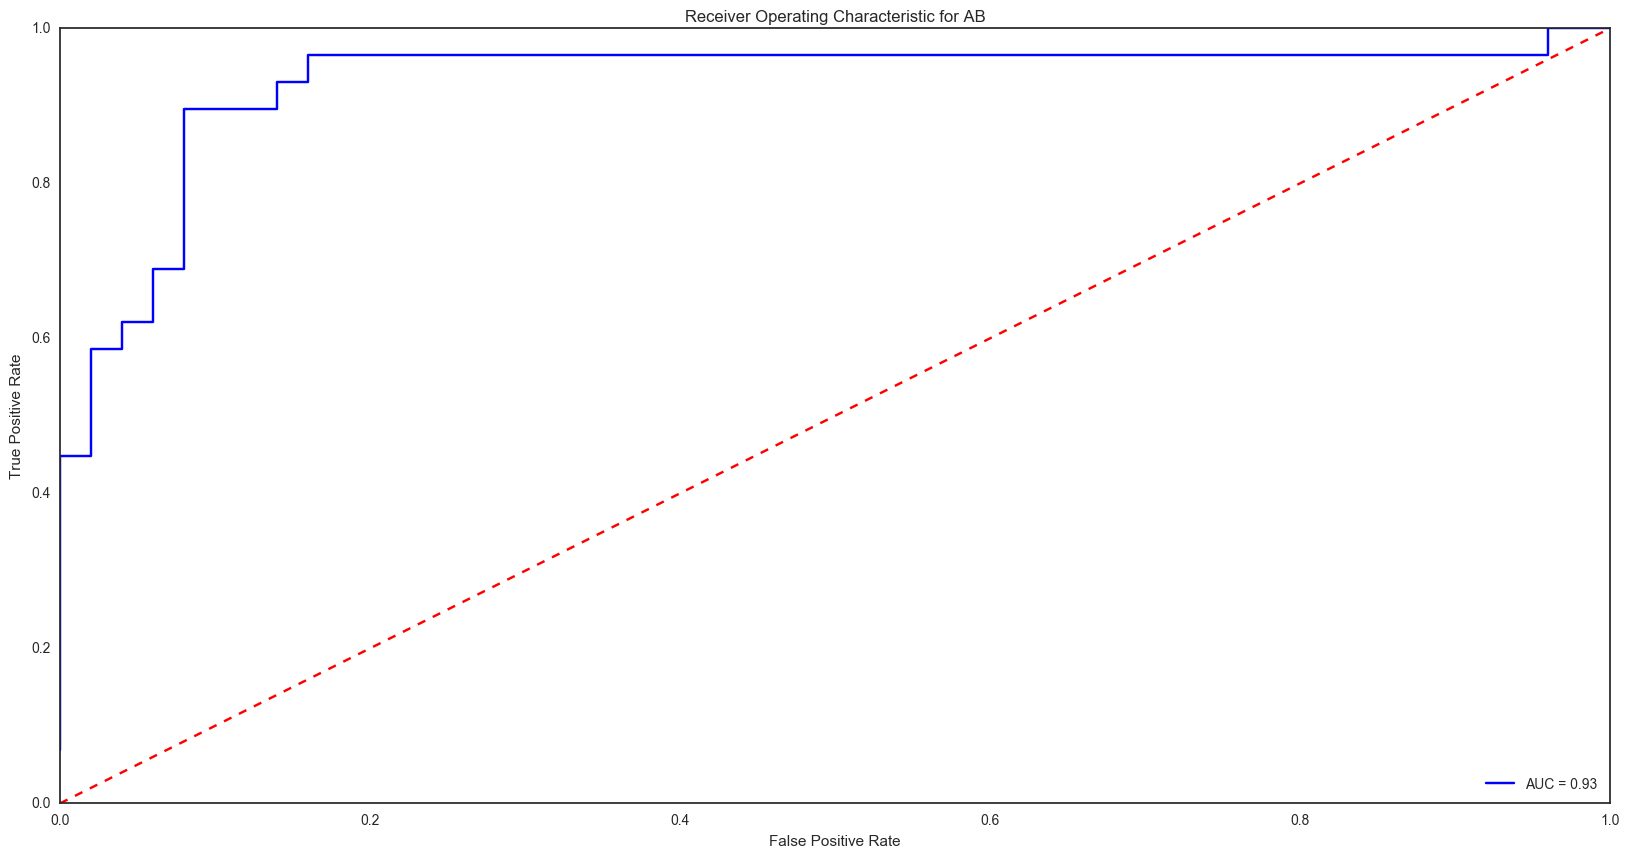

Validation based on GBM
0.886075949367
[[44  6]
 [ 3 26]]
[[44  6]
 [ 3 26]]
             precision    recall  f1-score   support

        0.0       0.94      0.88      0.91        50
        1.0       0.81      0.90      0.85        29

avg / total       0.89      0.89      0.89        79



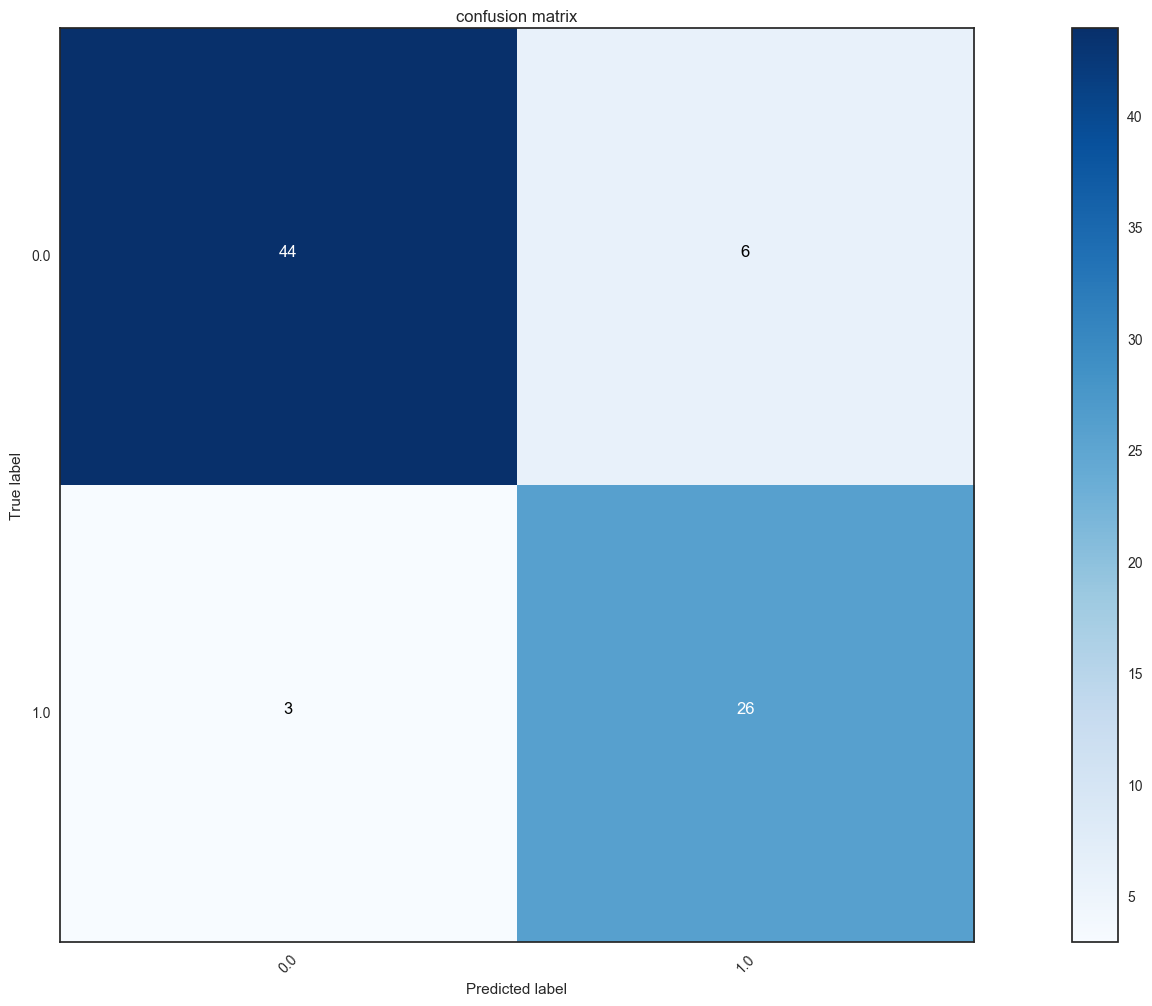

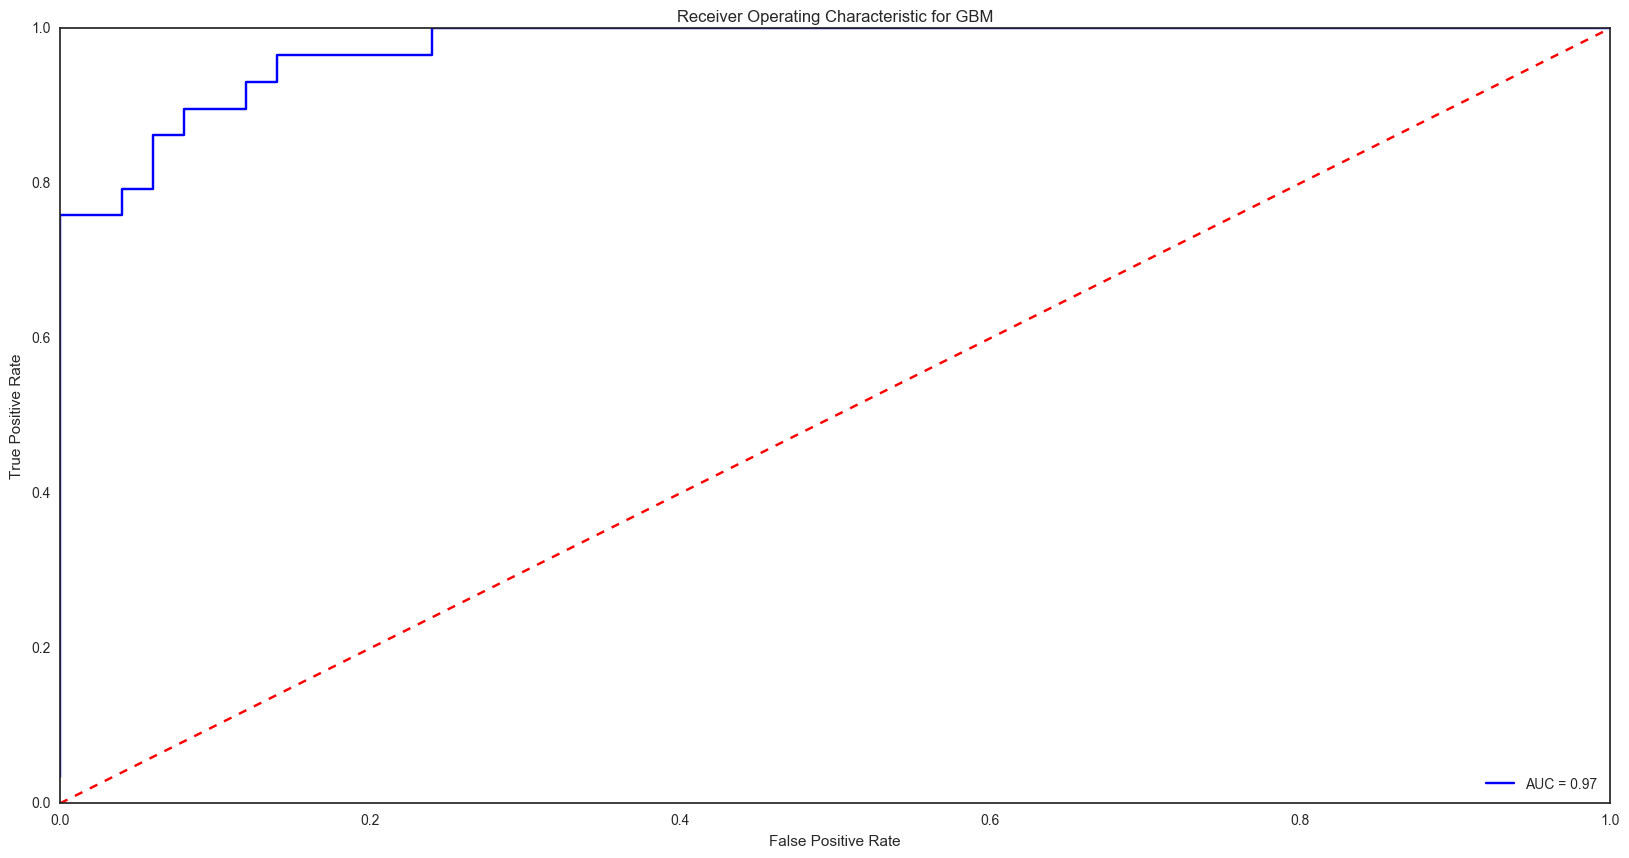

Validation based on RF
0.822784810127
[[40 10]
 [ 4 25]]
[[40 10]
 [ 4 25]]
             precision    recall  f1-score   support

        0.0       0.91      0.80      0.85        50
        1.0       0.71      0.86      0.78        29

avg / total       0.84      0.82      0.83        79



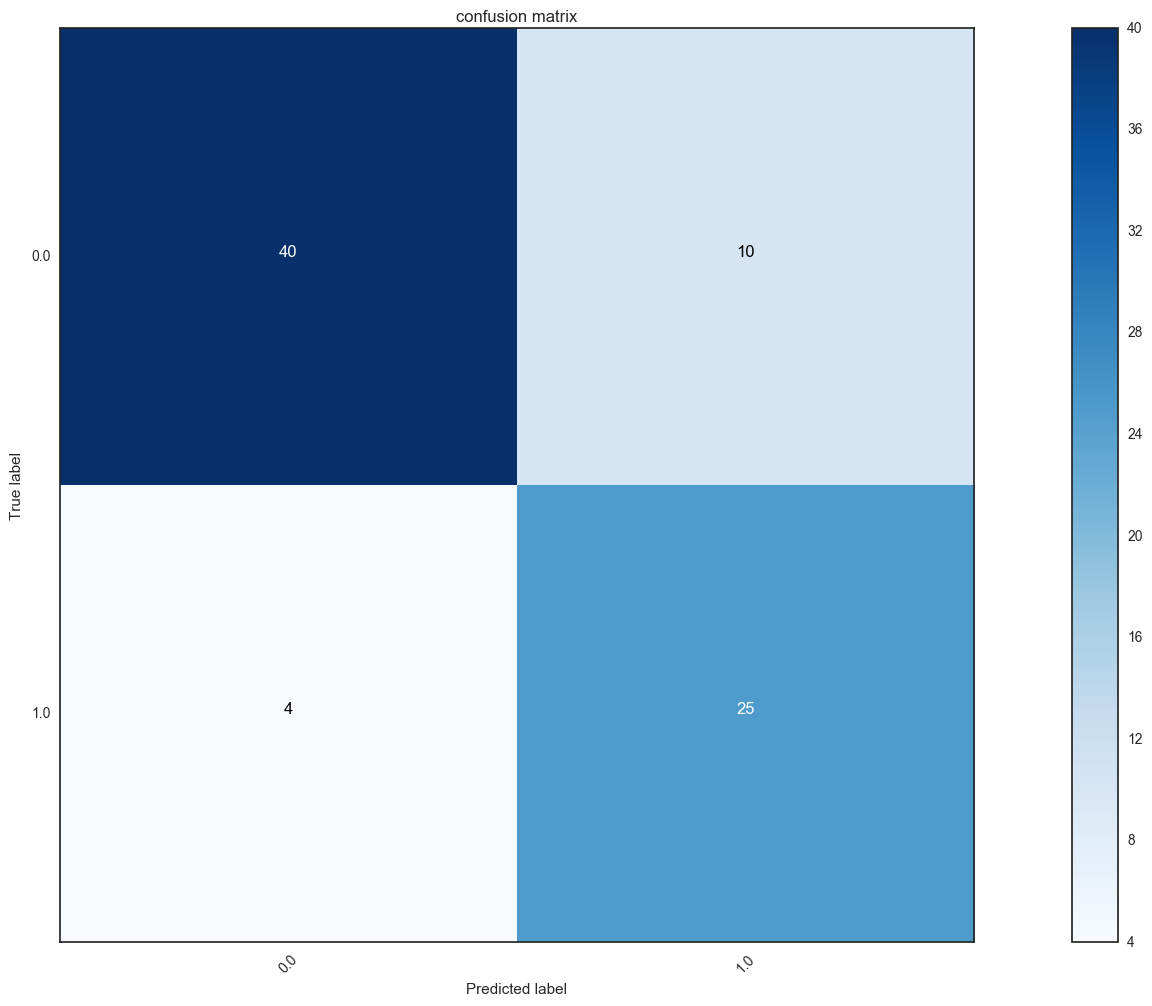

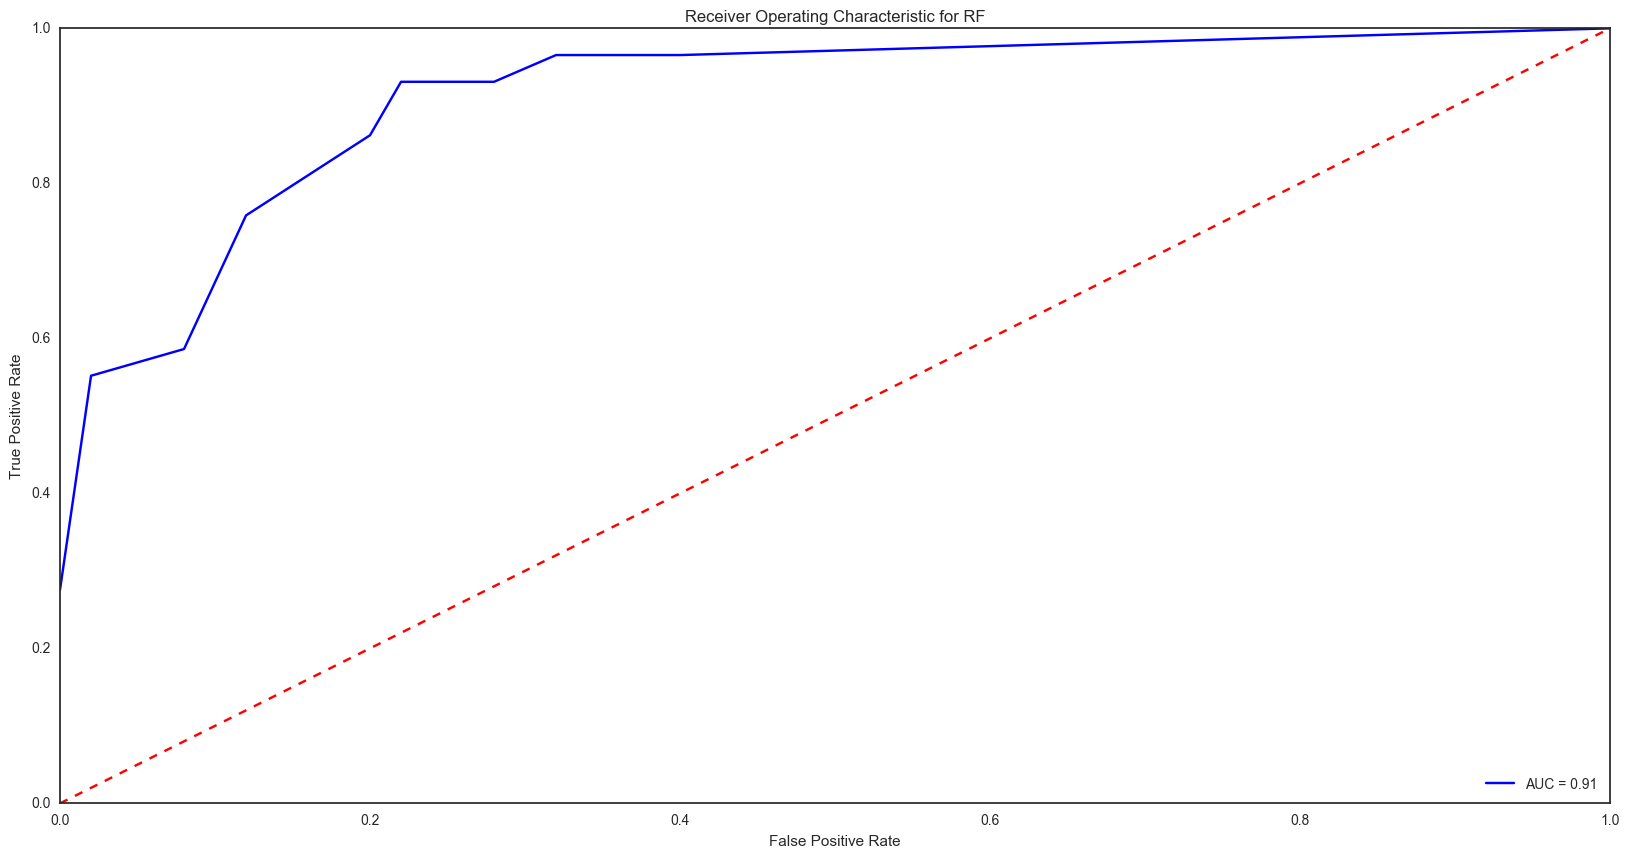

Validation based on ET
0.822784810127
[[43  7]
 [ 7 22]]
[[43  7]
 [ 7 22]]
             precision    recall  f1-score   support

        0.0       0.86      0.86      0.86        50
        1.0       0.76      0.76      0.76        29

avg / total       0.82      0.82      0.82        79



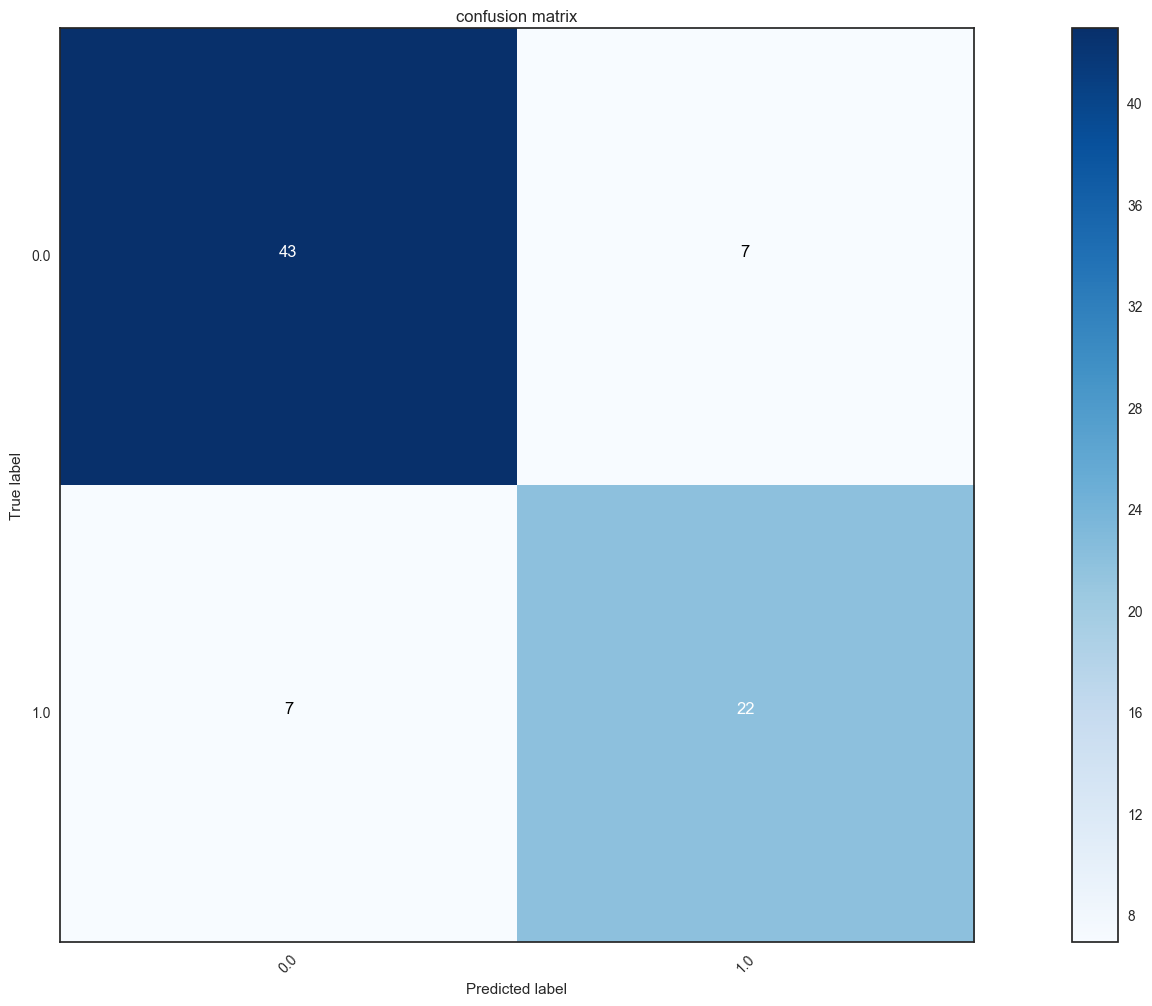

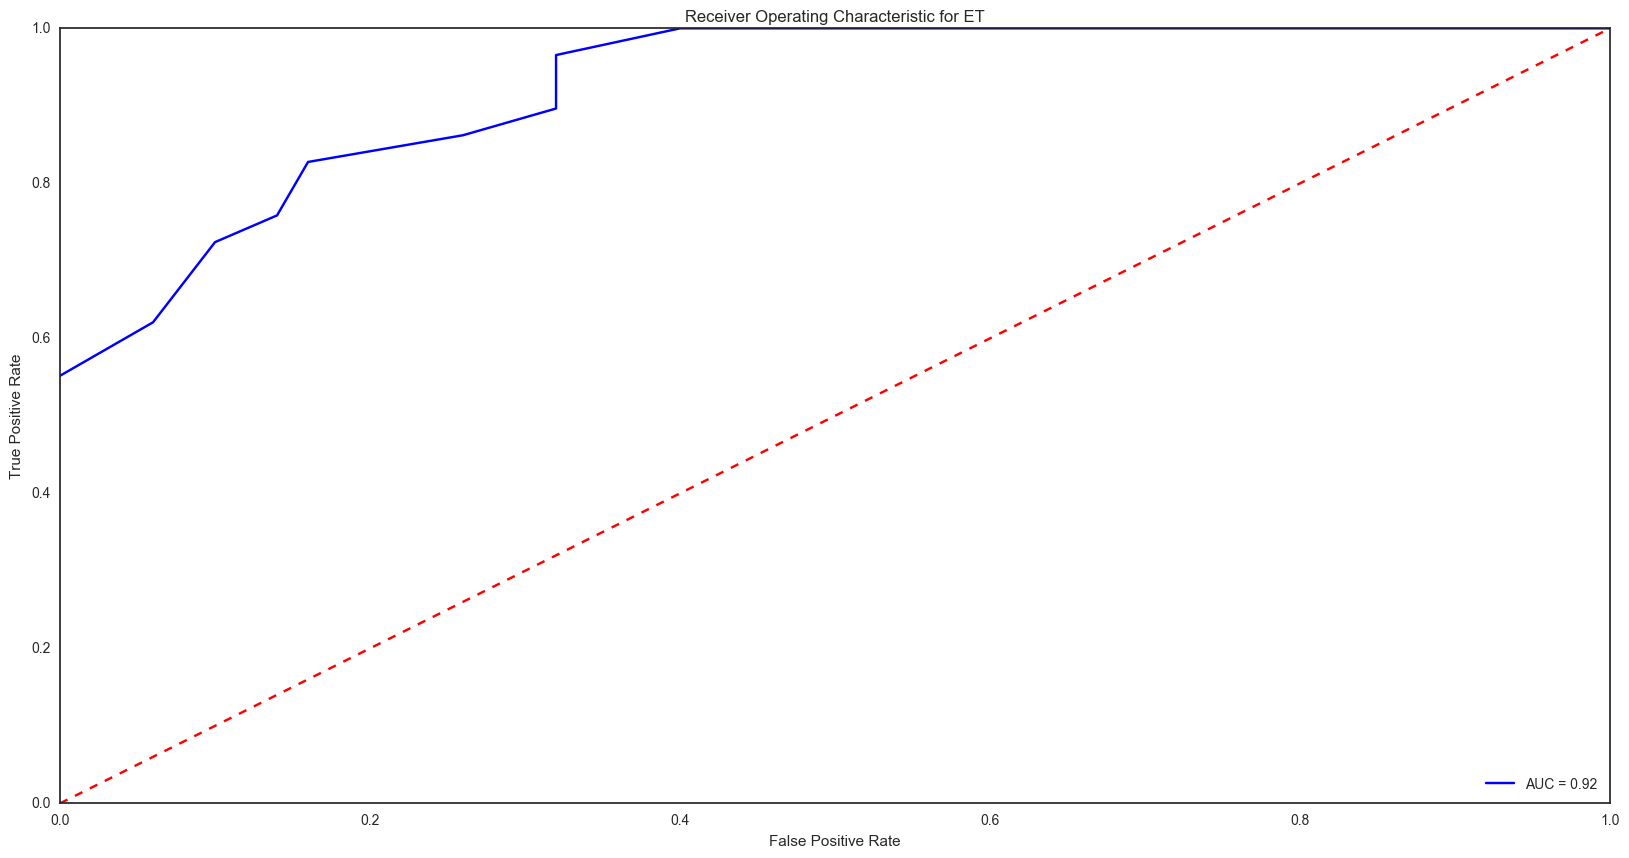

Validation based on XGB
0.886075949367
[[43  7]
 [ 2 27]]
[[43  7]
 [ 2 27]]
             precision    recall  f1-score   support

        0.0       0.96      0.86      0.91        50
        1.0       0.79      0.93      0.86        29

avg / total       0.90      0.89      0.89        79



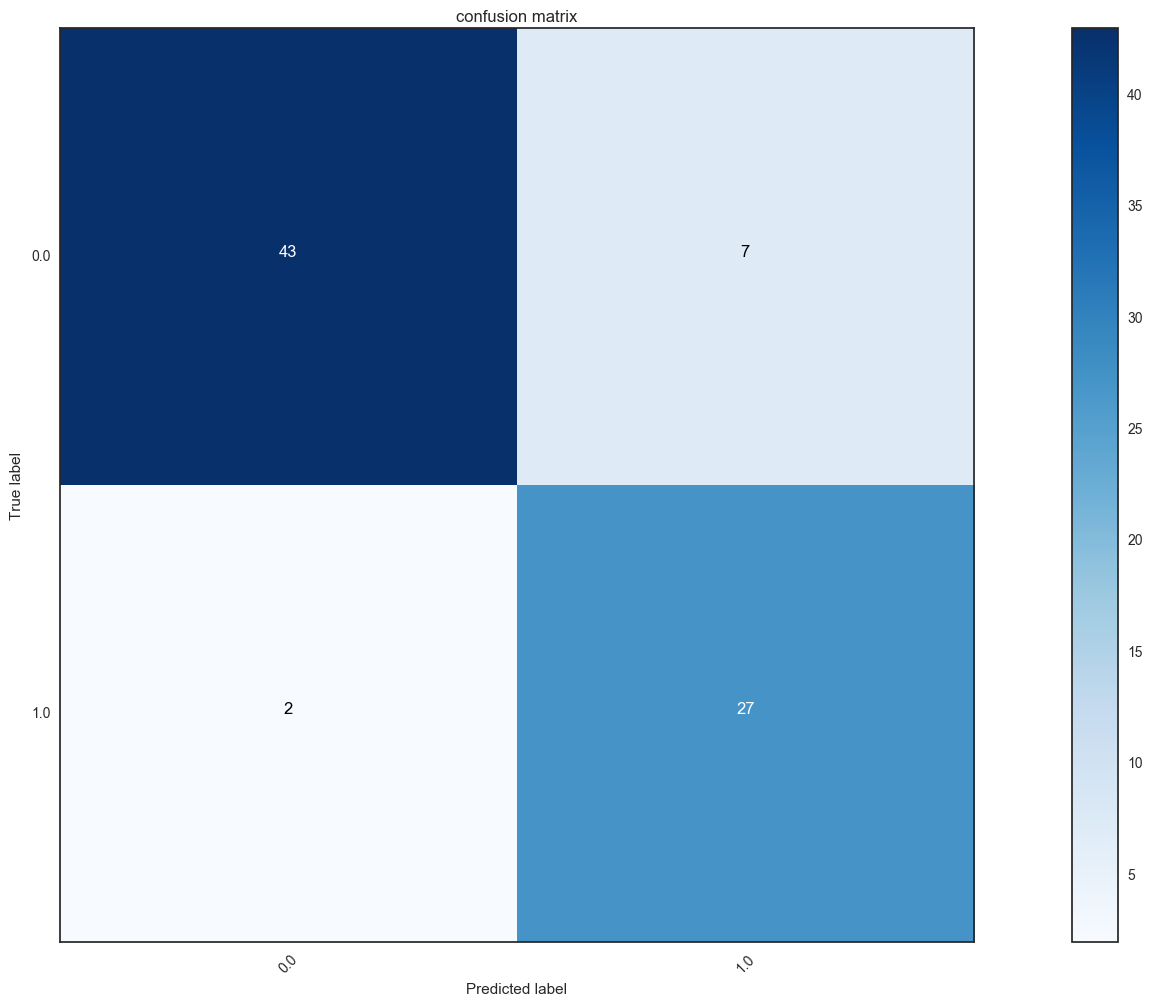

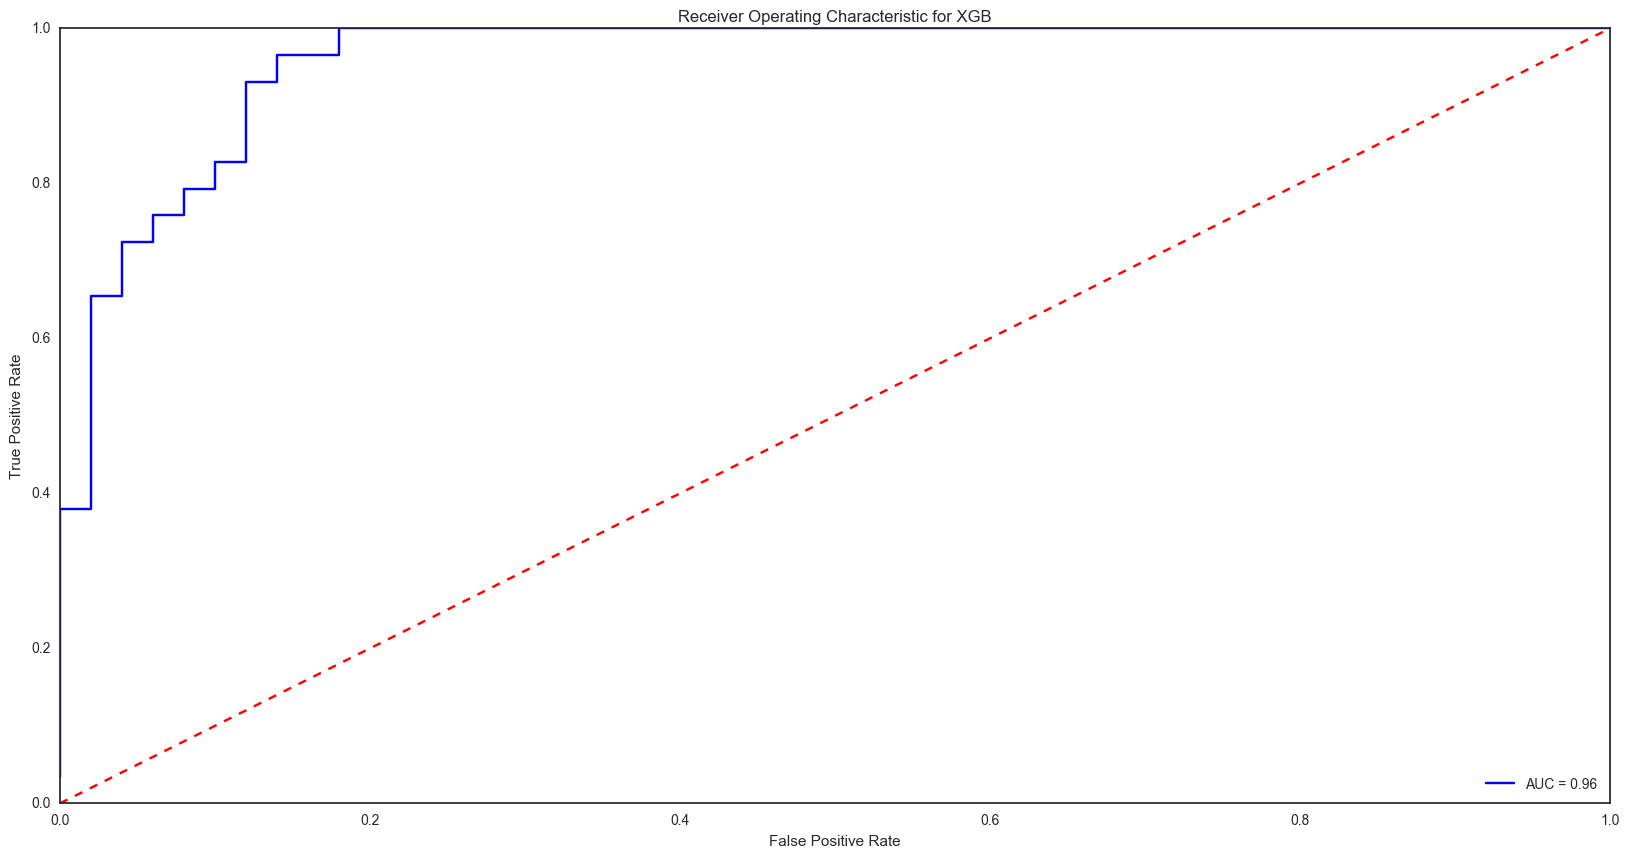

In [44]:
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def validate_models(training_set, outcome, validation_data, validation_outcome):
    
    models = []
    
    #baselines
    
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(probability=True)))
    
    #ensemble
    
    models.append(('AB', AdaBoostClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('ET', ExtraTreesClassifier()))
    models.append(('XGB', xgboost.XGBClassifier()))

    
    for name, model in models:
        mod = model
        mod.fit(training_set, outcome)
        # estimate accuracy on validation dataset
        predictions = mod.predict(validation_data)
        print "Validation based on " + name
        print(accuracy_score(validation_outcome, predictions))
        print(confusion_matrix(validation_outcome, predictions))
        cfmat = confusion_matrix(validation_outcome, predictions)
        plot_confusion_matrix(cfmat, classes=[0.0, 1.0] , title='confusion matrix')
        
        print(classification_report(validation_outcome, predictions))

        # calculate the fpr and tpr for all thresholds of the classification
        probs = mod.predict_proba(validation_data)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(validation_outcome, preds)
        roc_auc = auc(fpr, tpr)
        
        # method I: plt
        plt.figure(2)
        plt.title('Receiver Operating Characteristic for ' + name)
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
validate_models(X_train, Y_train, X_validation, Y_validation)

##  Classification across all datasets

Now that we discovered how the dataset is analyzed for classification we can reproduce the same approach to the other datasets and visualize all classification for all datasets in a single plot.

In these two views we're reporting 3 measures that we discovered earlier, the prediction accuracy, the training accuracy as well as the AUC for each round of training

![](/Users/Rad/Documents/Dev/sepsis_predictor_project/notebooks/images/view1.png)

We have some important points to notice here from this plot :

- Across all datasets, ensemble methods seem to work much better than the baseline algorithms for both training and prediction accuracy, the models trained with boosting algorithms perform better
- xgboost outperforms most of the algorithms almost in all datasets
- We see a slight improvement in accuracy **after feature selection** which proves two important things, the feature selection approach we had is efficient (trying several feature selection algorithms and use the overall average of feature importance) and the features selected are enough to predict the right classes, other features bringing noise are thus discarded and the prediction is more accurate
- There is a sort of pattern in the prediciton accuracies with focus only on the 12-24h time frame, a slight decrease in accuracy related to the reduction of the dataset mainly is obsereved.
- xgboost looks not sensitive to the dataset reduction, and accuracy is almost the same wether it is a full dataset or a sampled one.


# Phase 2 : Visualizing thresholds

In This section we will pick **xgboost** as our winner algorithm and try to visualize the selected features and how they impact the final outcome. To do that we will rollback to the original data instead of the transformed ones, just to see if there is any trend so far 

In [45]:
df_clean_2 = df_clean_2.reset_index(drop=True)
df_final = df_final.reset_index(drop=True)

In [46]:
X = df_final
Y = df_clean_2["outcome"]
X = X[["weight.challenge", "pch.weight", "score.left", "score.right", "score.overall", "hr.post.challenge "]]
names = df_scaled_df.columns


X_final = pd.DataFrame(X, index=X_validation.index)
Y_final = pd.DataFrame(Y, index=X_validation.index)

In [47]:
table = pd.concat([X_final, Y_final], axis=1)
table.head()

,weight.challenge,pch.weight,score.left,score.right,score.overall,hr.post.challenge,outcome
238,3.83,2.350,8.0,8.0,8.0,41.333,0.0
270,3.38,-4.438,5.0,3.0,4.0,13.250,0.0
213,3.93,5.344,8.0,8.0,8.0,41.583,0.0
357,3.23,8.050,8.0,8.0,8.0,47.420,0.0
57,4.99,-7.214,6.0,6.0,6.0,35.433,0.0


Let's use XGBOOST to classify our data

Validation based 
0.886075949367
[[43  7]
 [ 2 27]]
             precision    recall  f1-score   support

        0.0       0.96      0.86      0.91        50
        1.0       0.79      0.93      0.86        29

avg / total       0.90      0.89      0.89        79



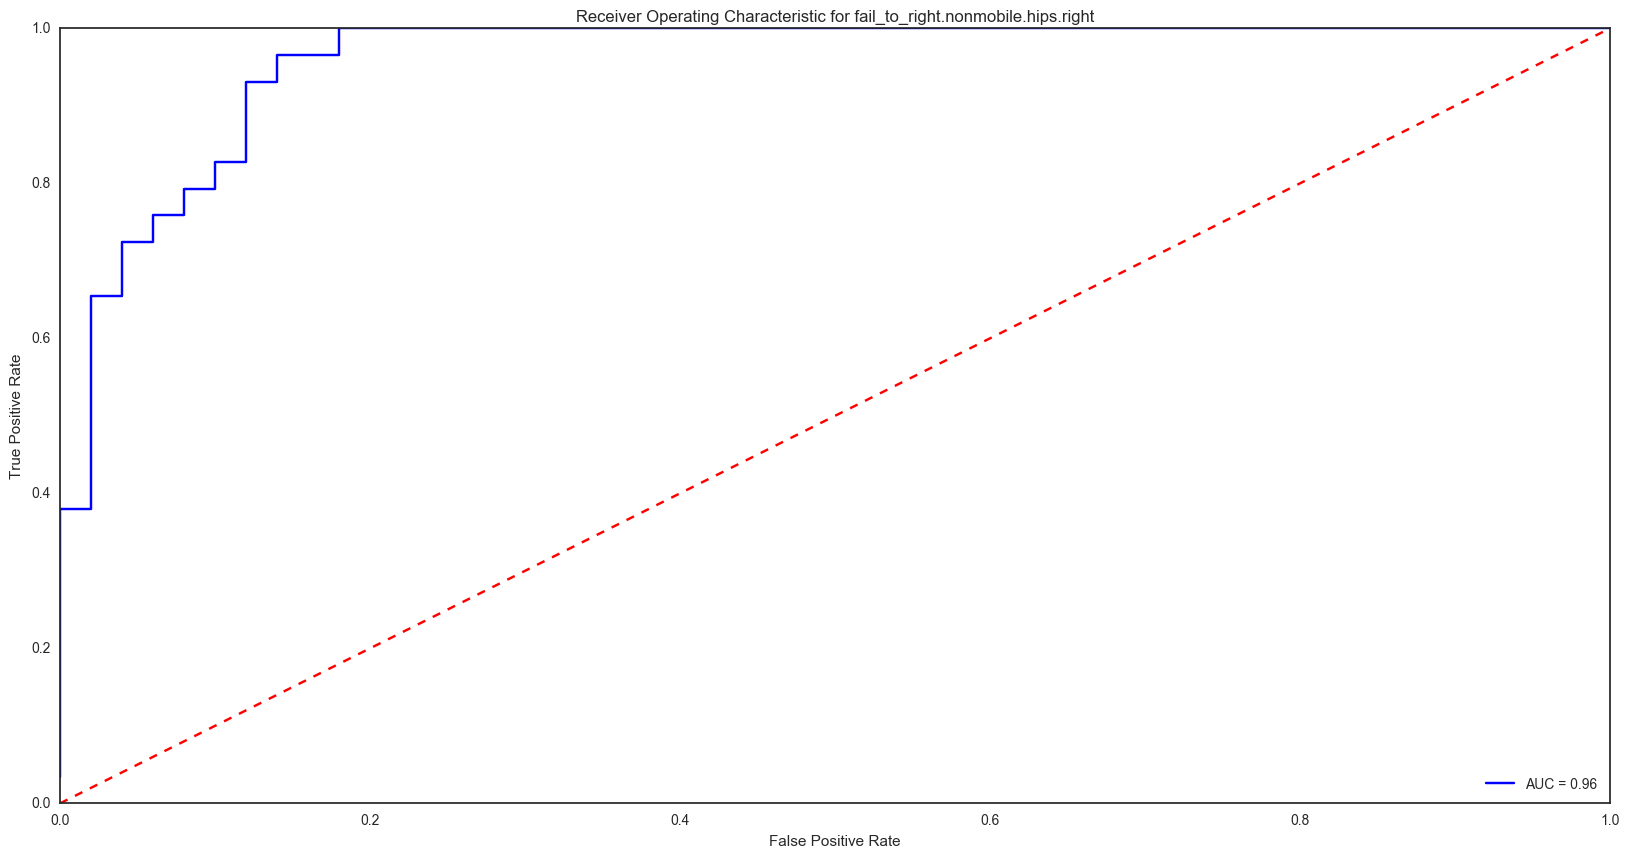

In [48]:
training_set = X_train
outcome = Y_train
validation_data = X_validation
validation_outcome = Y_validation

mod = xgboost.XGBClassifier()
mod.fit(training_set, outcome)
# estimate accuracy on validation dataset
predictions = mod.predict(validation_data)
print "Validation based "
print(accuracy_score(validation_outcome, predictions))
print(confusion_matrix(validation_outcome, predictions))
cfmat = confusion_matrix(validation_outcome, predictions)
#plot_confusion_matrix(cfmat, classes=[0.0, 1.0] , title='confusion matrix')
print(classification_report(validation_outcome, predictions))
# calculate the fpr and tpr for all thresholds of the classification
probs = mod.predict_proba(validation_data)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(validation_outcome, preds)
roc_auc = auc(fpr, tpr)
    
# method I: plt
plt.figure()
plt.title('Receiver Operating Characteristic for ' + name)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

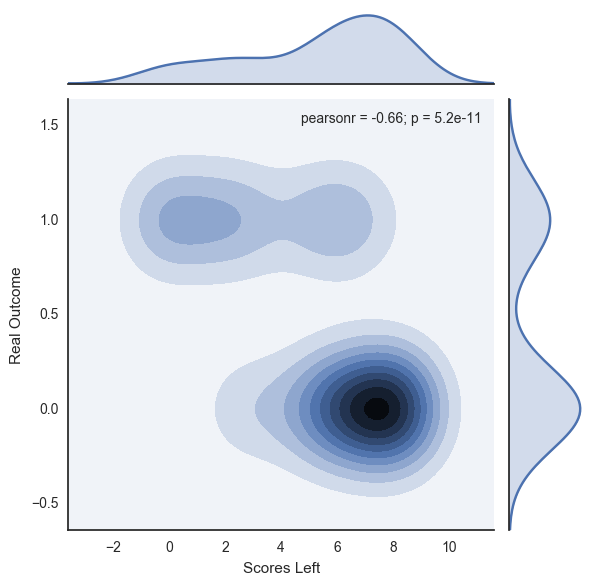

In [49]:
x1 = pd.Series(table["score.left"].values, name="Scores Left")
x2 = pd.Series(Y_validation.values, name="Real Outcome")
g = sns.jointplot(x1, x2, kind="kde")

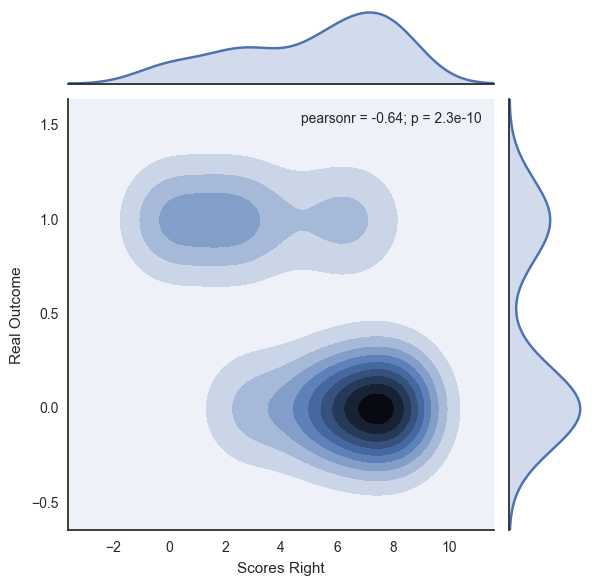

In [50]:
x1 = pd.Series(table["score.right"].values, name="Scores Right")
x2 = pd.Series(Y_validation.values, name="Real Outcome")
g = sns.jointplot(x1, x2, kind="kde")

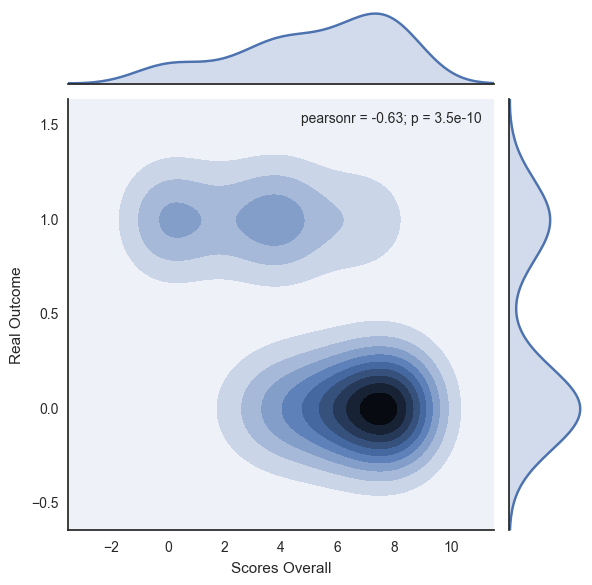

In [51]:
x1 = pd.Series(table["score.overall"].values, name="Scores Overall")
x2 = pd.Series(Y_validation.values, name="Real Outcome")
g = sns.jointplot(x1, x2, kind="kde")

We see a trend here that is confirmed by the data, higher scores seem to be enough to split the data into the class `live` or `die`, there is a strong signal suggesting that scores 7 and up are enough to predict the `live` outcome, **whereas the `die` class seems to be hard to predict with the score features alone**

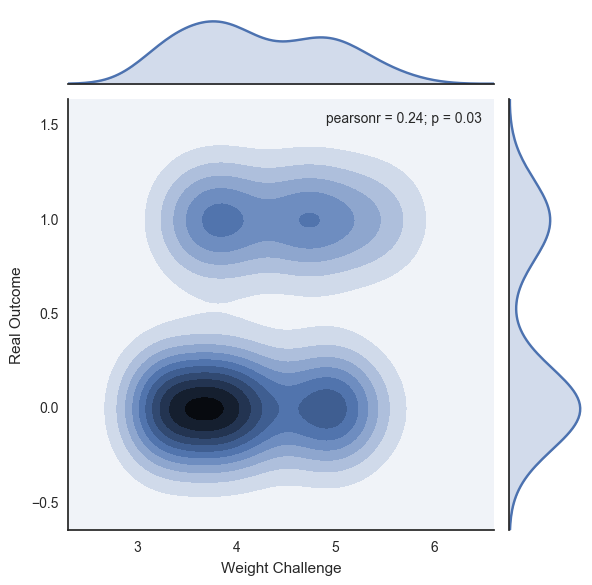

In [52]:
x1 = pd.Series(table["weight.challenge"].values, name="Weight Challenge")
x2 = pd.Series(Y_validation.values, name="Real Outcome")
g = sns.jointplot(x1, x2, kind="kde")

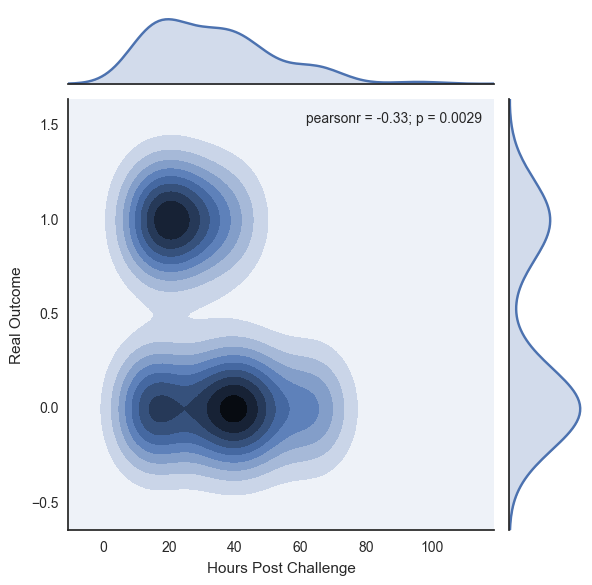

In [55]:
x1 = pd.Series(table["hr.post.challenge "].values, name="Hours Post Challenge")
x2 = pd.Series(Y_validation.values, name="Real Outcome")
g = sns.jointplot(x1, x2, kind="kde")